In [1]:
import os
import astropy
import requests
import pandas as pd
import numpy as np
import lightkurve as lk 
from scipy.interpolate import interp1d
from astropy.modeling import models, fitting
import matplotlib.pyplot as plt
import emcee
import sys
import csv
from astropy.timeseries import LombScargle
from os.path import basename, exists

# change these paths to wherever you have the files
# sys.path.insert(1,'/Users/neisner/Documents/code/utils/')
import filters # Suzanne's functions
import norm

# change these paths to wherever you have the files
# sys.path.insert(1,'/Users/neisner/Documents/code/ETV')
import etv_functions # Nora's functions 

%matplotlib inline

In [2]:
from IPython.display import display, HTML, Javascript, clear_output

display(HTML("<style>.container { width:99% !important; }</style>"))  # Jupyter 6
display(HTML("<style>.jp-Notebook { --jp-notebook-max-width: 98%; }</style>"))  # Jupyter 7

# define the paths where the data will be stores - NEED TO CHANGE THIS TO YOUR OWN PATH
outfile_base = './etv_out'  # for ETV
lk_download_dir = 'C:/dev/_juypter/PH_TESS_LightCurveViewer/data'  

# A command from shell that can be run to notify users, e.g., fitting is finished. Use "echo" if you do not have one
NOTIFY_CMD = "win-notify.bat"

if hasattr(lk, "conf"):  # default download dir
    lk.conf.cache_dir = lk_download_dir
if hasattr(lk.search, "sr_cache"):   # PR for persistent query result cache
    lk.search.sr_cache.cache_dir = lk_download_dir  # None
    lk.search.sr_cache.expire_second = 86400

## Looking for ETVs in TIC 440051305


In [3]:
# define the plotting parameters

figsize = (8,4)

In [4]:
# import the data

# choose a TIC ID to analyze
ticid = 440051305  # EW, only 2 sectors of 2min data

# define the paths where the data will be stores - NEED TO CHANGE THIS TO YOUR OWN PATH
outfile_path = f"{outfile_base}/tic{ticid}_etv_primary.csv"
outfile_path_s = f"{outfile_base}/tic{ticid}_etv_secondary.csv"


# import data using Lightkurve
# sr = lk.search_lightcurve('TIC {}'.format(ticid), author = 'SPOC')  
if not "../.." in sys.path:
    sys.path.append("../..")
import lightkurve_ext as lke  # at ../../
import astropy.units as u


sr = lk.search_lightcurve('TIC {}'.format(ticid))  # get long cadence data too
sr = lke.filter_by_priority(sr, author_priority=['SPOC', 'TESS-SPOC'], exptime_priority=['short', 'long', 'fast'])
# sr = sr[sr.exptime != 1800 *u.s]  # exclude 30min cadence data for now (TESS-SPOC, sectors 18, 19, 23 )
# sr = sr[np.isin(sr.author, ['SPOC', 'TESS-SPOC'])]  # exclude QLP to ensure for uniformity in the data
sr = lke._sort_chronologically(sr)  # workaround lightkurve v2.4.2+ change in sort order
display(sr)
lc_tess = sr.download_all().stitch()
# lc_tess = lc_tess.truncate(None, 1450)  # use data from sectors 2 - 3 for now


search_result = lc_tess

time = search_result.time.value
flux = search_result.flux.value
fluxerr = search_result.flux_err.value
len(search_result)

SearchResult containing 2 data products.

 #     mission     year author exptime target_name distance proposal_id
                                  s                 arcsec             
--- -------------- ---- ------ ------- ----------- -------- -----------
  0 TESS Sector 17 2019   SPOC     120   440051305      0.0         N/A
  1 TESS Sector 57 2022   SPOC     120   440051305      0.0      G05003

34654

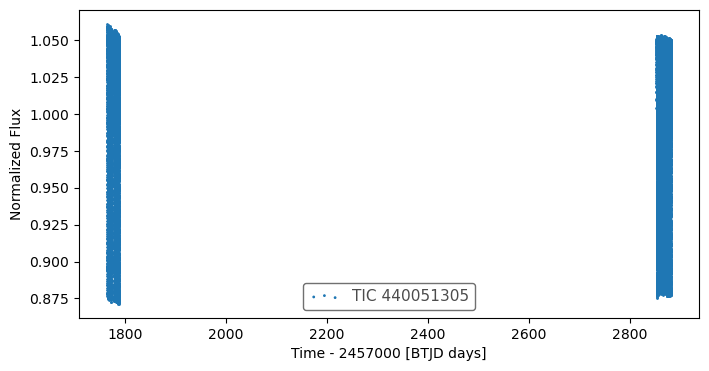

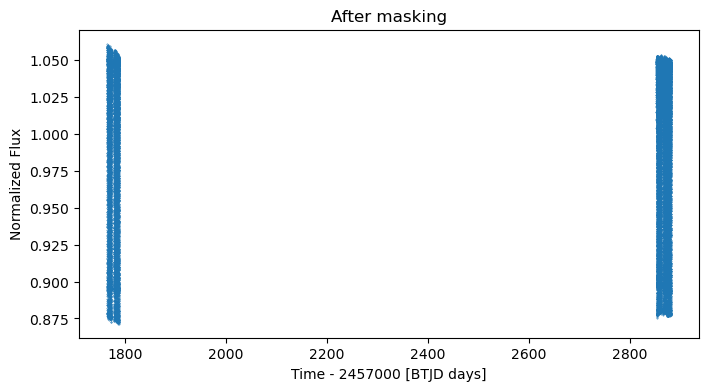

In [5]:
%matplotlib inline
# %matplotlib widget

time = search_result.time.value
flux = search_result.flux.value
fluxerr = search_result.flux_err.value
len(search_result)

# mask out data you don't like...

fig, ax = plt.subplots(figsize=figsize)
search_result.scatter(ax = ax)

# mask = time < 0 #( time > 54950) & (time < 54963)  #  truncate weird spikes at the beginning of Kepler data  
mask = flux < 0.85    # remove occassional outliers

time = time[~mask]
flux = flux[~mask]
fluxerr = fluxerr[~mask]

# make sure that therte are no nans!

finite_mask = np.isfinite(time) * np.isfinite(flux) * np.isfinite(fluxerr)

# make a dictionary of the data 

data = pd.DataFrame({'time': time[finite_mask], 'flux': flux[finite_mask], 'err': fluxerr[finite_mask]})

ax2 = plt.figure(figsize=figsize).gca()
ax2.scatter(data.time, data.flux, s=0.1);
ax2.set_ylabel(ax.get_ylabel())
ax2.set_xlabel(ax.get_xlabel())
ax2.set_title("After masking");

In [6]:
do_bls = False

if do_bls:
    if not "../.." in sys.path:
        sys.path.append("../..")
    import lightkurve_ext_pg_runner as lke_pg_runner  # at ../../

    bls_result = lke_pg_runner.run_bls(
        search_result.remove_nans(),
        pg_kwargs=dict(
            minimum_period=1, maximum_period=20,
            frequency_factor=1,            
            duration=[3.4957 / 24 * f for f in [0.975, 1, 1.025, 1.05, 1.1, 1.15,]],  # based on observed primary eclipse duration for better fit
        ),
    )
    !$NOTIFY_CMD  "BLS Done"

In [7]:
# Visaully compare different candidate period

# ax = search_result.normalize().fold(epoch_time=1471.4196, period=8.418132651611877).truncate(-0.1, 0.1).scatter(label="BLS period, frequency_factor=10");  # HWHM 0.001571020094789155
# ax = search_result.normalize().fold(epoch_time=1471.4196, period=8.418147).truncate(-0.1, 0.1).scatter(label="s0001-s0009:TCE1");

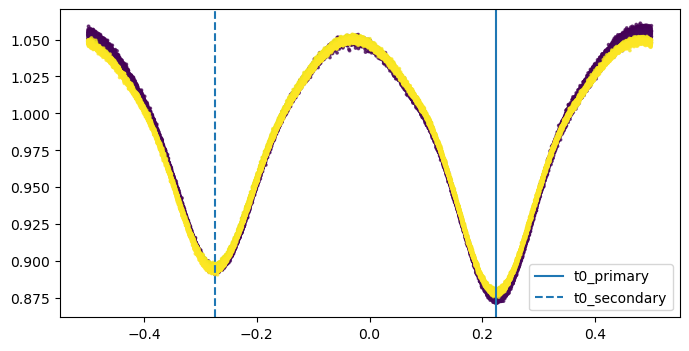

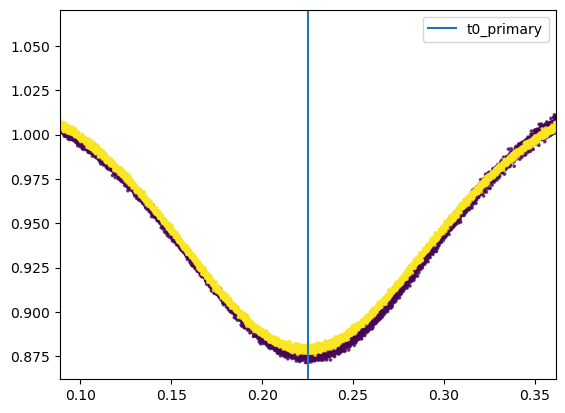

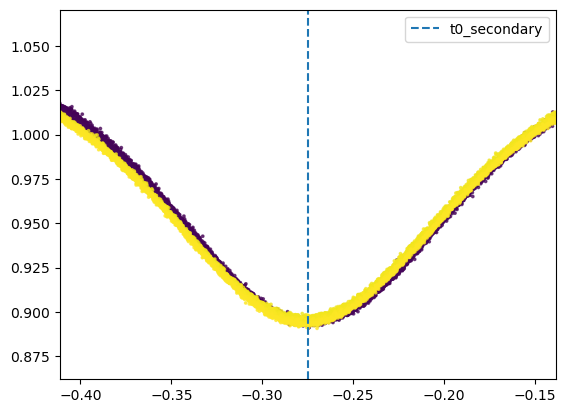

In [28]:
%matplotlib inline
# %matplotlib widget

from astropy.time import Time

# define the orbital period and the t0 

# TESS EB (1 sector):  epoch=1765.0601670041478	, period=0.3296756714374497
# VSX: 0.3296745 
# LombSCargle: 0.32967269065536303  (acutal peak: 0.16483634532768152 (half), -0.022878	+0.0227)3	    
# AoV on data primary: 	0.329653 (bins=10)	0.329771 (bins=1)
# MCMC on df_primary: 0.3296733609775798, std_p: 2.1055535370411986e-09
# MCMC t0: 1764.7310716182485, std_t0: 5.694010656969915e-06

# FILL-IN THE eclipse epoch / period, 
# period = 0.3296727  # LS Period
period = 0.3296734  # MCMC

# t0_primary = 1765.06017
t0_primary = 1764.7311  # MCMC
t0_secondary = t0_primary + period / 2


# convert epoch from BTJD to commonly mjd used here
# t0_primary = Time(t0_primary, format="btjd").to_value("mjd")
# t0_secondary = Time(t0_secondary, format="btjd").to_value("mjd")

# Move t0 to the first dip in the data (some of the subsequent codes, espically fit_each_eclipse(), assumes that)
t0_primary = t0_primary - int((t0_primary - data['time'][0]) / period) * period
if t0_secondary is not None:
    t0_secondary = t0_secondary - int((t0_secondary - data['time'][0]) / period) * period

duration_hr_primary = 1.8
duration_hr_secondary = 1.8

# t0_for_plotting = 0  # keep 0 for plotting purposes
t0_for_plotting = t0_primary - np.abs(t0_primary - t0_secondary) * 0.45  # use a custom one so that the eclipses are not near the edge (-0.5 or +0.5)

phase = etv_functions.phase_data(data['time'], t0_for_plotting, period)

fig, ax = plt.subplots(figsize = (8,4))

plt.scatter(phase,data['flux'], s = 3, alpha = 0.7, c = data['time'])

# add the phase to the dataframe
data['phase'] = phase

plt.axvline(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0], label="t0_primary")
if t0_secondary is not None:
    plt.axvline(etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0], linestyle="--", label="t0_secondary")
plt.legend()
# plt.ylim(0.535, 0.55)
# plt.xlim(-0.5, 0.1)
plt.show();

plt.scatter(phase,data['flux'], s = 3, alpha = 0.7, c = data['time'])
plt.axvline(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0], label="t0_primary")
plt.xlim(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0] - 0.6 * duration_hr_primary / 24/ period, etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0] + 0.6 * duration_hr_primary / 24/ period);
plt.legend();
# plt.ylim(0.75, 0.85);
plt.show()

plt.scatter(phase,data['flux'], s = 3, alpha = 0.7, c = data['time'])
plt.axvline(etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0], linestyle="--", label="t0_secondary")
plt.xlim(etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0] - 0.6 * duration_hr_secondary / 24/ period, etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0] + 0.6 * duration_hr_secondary / 24/ period);
plt.legend();
# plt.ylim(0.975, 1.005);
plt.show()

### Detrend (optional)

- detrended flux is in `flux_detrended`, and won't be used in subsequent work by default

In [ ]:
# show data to visualize what's changed in each step below
data  

In [ ]:
# phase fold the data and create an appoximate binary model (top) and subtract it from the data (bottom)
#_, _ , flux_sub_binary, model, _, _ = etv_functions.trend_removal_interact(period, 0, data['time'], data['flux'], data['time'], data['flux'])

data = etv_functions.trend_removal_interact(period, t0_for_plotting, data)
data

In [ ]:
# if you want to detrend the data run this line!

data = etv_functions.detrend_suz(data, T_dur = 10, plot = True)
data

In [ ]:
# plot the phase folded data here so that you know at what phase you want to cut the data to model 
fig, ax = plt.subplots(figsize = figsize)
plt.scatter(data.phase, data.flux_detrended, s = 1, label="flux_detrended")
plt.legend()
plt.show()

plt.scatter(phase,data['flux_detrended'], s = 3, alpha = 0.7, c = data['time'])
plt.axvline(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0], label="t0_primary")
plt.xlim(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0] - 0.6 * duration_hr_primary / 24/ period, etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0] + 0.6 * duration_hr_primary / 24/ period);
plt.legend();
# plt.ylim(0.75, 0.85);
plt.show()

plt.scatter(phase,data['flux_detrended'], s = 3, alpha = 0.7, c = data['time'])
plt.axvline(etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0], linestyle="--", label="t0_secondary")
plt.xlim(etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0] - 0.6 * duration_hr_secondary / 24/ period, etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0] + 0.6 * duration_hr_secondary / 24/ period);
plt.legend();
# plt.ylim(0.75, 0.85);
plt.show()

<span style="background-color: rgba(255, 0, 0, 0.6);"> NOTE: </span> The zoom windows below for the eclipses are made **smaller**, an attempt to reduce the complications of EW variability outside the minima (and some assymetery)

### Now that the data is ready we can start 

In [29]:
# define the midpoints of the primary and secondary eclipses and the window width

# if these don't look central - change them!! the eclipses should be central
midpoint_p =  etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0]  # convet to time in phase
# midpoint_p -= 0.004  # the offset is added back to t0_primary (& secondary above
print('Primary:  ', t0_primary, midpoint_p)

# change depending on the width of the eclipses, default to be slightly larger than the primary eclipse
window_width_p = 1.0 * duration_hr_primary / 24 / period   # it seems to be difficult to bit model the flat bottom and the curves outside, focus on the overall shape for now
# use a shoter duration to avoid fitting the out-of-eclipse LC, which has its own variability that the model is not equipped to hanlde
# window_width_p = 0.095
print("window_width_p (phase):", window_width_p)

data_primary = data[(data['phase'] > midpoint_p - window_width_p / 2) & (data['phase'] < midpoint_p + window_width_p / 2) ]
ph_binned,flux_binned,err_binned = etv_functions.run_binning_phased(data_primary.phase, data_primary.flux, yerr=data_primary.err,nbins=1000)


if t0_secondary is not None:
    midpoint_s =  etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0]
    print('Secondary:', t0_secondary, midpoint_s)

    # the coshgauss model seems problematic, try to use a larger width to give it more shape to fit
    window_width_s = 1.0 * duration_hr_secondary / 24 / period  
    # window_width_s = 0.22
    print("window_width_s (phase):", window_width_s)
    
    data_secondary = data[(data['phase'] > midpoint_s - window_width_s / 2) & (data['phase'] < midpoint_s + window_width_s / 2) ]
    ph_binned_s,flux_binned_s,err_binned_s = etv_functions.run_binning_phased(data_secondary.phase, data_secondary.flux, yerr=data_secondary.err,nbins=1000)


### # you need initial guesses!! The order is :
# alpha0, alpha1, t0, d, Tau - CHANGE THESE TO YOUR OWN INITIAL GUESSES
# median flux, -eclipse depth, t0, related to duration, related to shape (U or V) 
# t0 in normalixed phase
start_vals = [1.0108, -0.1340, midpoint_p, 0.06870, 0.915]
start_vals_s = [1.024, -0.130, midpoint_s, 0.075, 0.881]
    
# -- -- -- -- -- -- -- -- --
# etv_functions.plot_initial_guess(data_primary, ph_binned, flux_binned, err_binned, *start_vals)
etv_functions.plot_initial_guess_interactive(data_primary, ph_binned, flux_binned, err_binned, "midpoint_p", *start_vals)
if t0_secondary is not None:
    # etv_functions.plot_initial_guess(data_secondary, ph_binned_s, flux_binned_s, err_binned_s, *start_vals_s)
    etv_functions.plot_initial_guess_interactive(data_secondary, ph_binned_s, flux_binned_s, err_binned_s, "midpoint_s", *start_vals_s)

print("Start params for  fitting period with MCMC on df_primary:")
print(f"[{start_vals[0]}, {start_vals[1]}, {t0_primary}, {start_vals[3]}, {start_vals[4]}, {period}],");

Primary:   1764.7311 0.22500000000027343
window_width_p (phase): 0.2274978812363994
Secondary: 1764.8959367 -0.2749999999996553
window_width_s (phase): 0.2274978812363994


Output(layout=Layout(padding='1em 0px'))

Output(layout=Layout(padding='1em'))

Output(layout=Layout(padding='1em 0px'))

Output(layout=Layout(padding='1em'))

Start params for  fitting period with MCMC on df_primary:
[1.0108, -0.134, 1764.7311, 0.0687, 0.915, 0.3296734],


In [19]:
if False: 
    # Export the data around primary eclipses, for period analysis outside of notebook
    data_primary[["time", "flux", "err"]].to_csv(f"tmp/data_primary_{ticid}.csv", index=False)

emcee parallel enabled, use 4 CPUs.


100%|██████████████████████████████████████████████████████████| 1000/1000 [03:21<00:00,  4.97it/s]


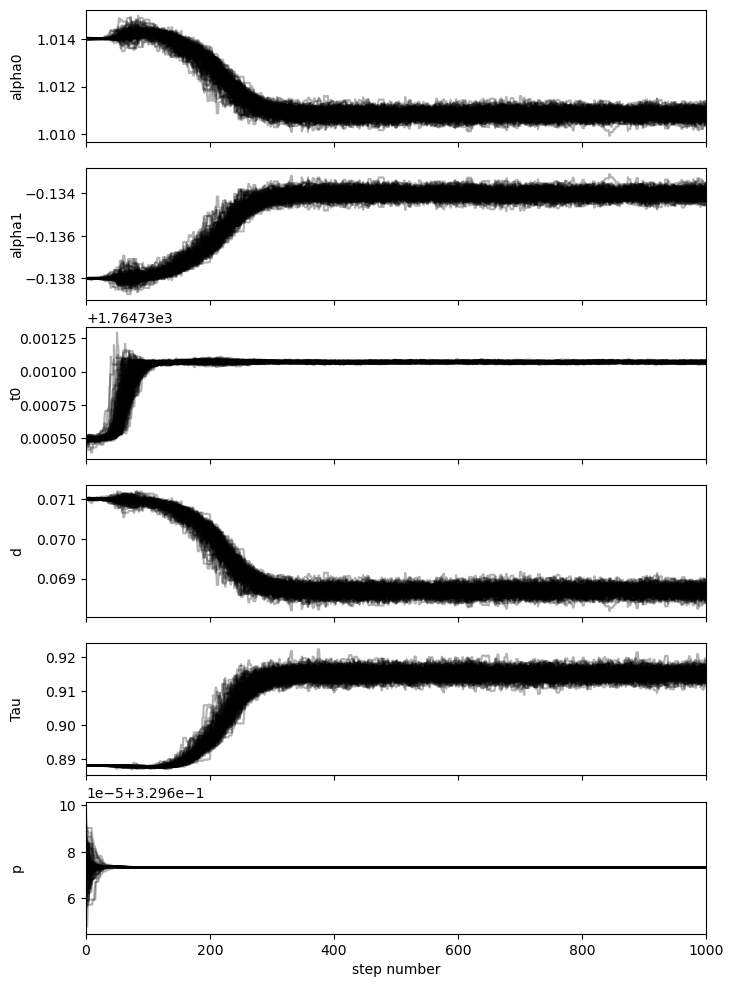

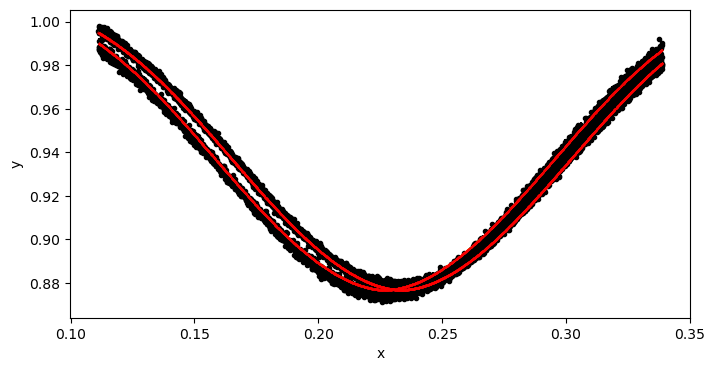

mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p = 1.0108432195900237, -0.13403915396747323, 1764.7310716182485, 0.0686951955984063, 0.9150568277309232, 0.3296733609775798
std_p: 2.1055535370411986e-09 ; std_t0: 5.694010656969915e-06


In [27]:
# use MCMC to refine the period

use_mcmc_to_fit_period = True


if use_mcmc_to_fit_period:
    import etv_functions_with_period as etvp

    etv_functions.enable_info_log_for_jupyter()

    # MCMC result
    mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p, fit_params_p_stats = etvp.run_mcmc_initial_fit_p(
        data_primary[:],
        [1.014, -0.138, 1764.7304973, 0.071, 0.888, 0.3296727],
        # nruns=20, discard=1, # for a sanity test,  to ensure the initial guess is not way off.
        nruns=1000, discard=600,
        pool=-2,
        plot_chains=True,
        plot=True,
        also_return_stats=True,
    )
    print("mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p = " + ", ".join([str(v) for v in [mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p]]))
    print("std_p:", fit_params_p_stats["std_p"], "; std_t0:", fit_params_p_stats['std_t0'])
    !$NOTIFY_CMD "Fitting period done."

emcee parallel enabled, use 4 CPUs.


100%|██████████████████████████████████████████████████████████| 1000/1000 [01:11<00:00, 14.02it/s]


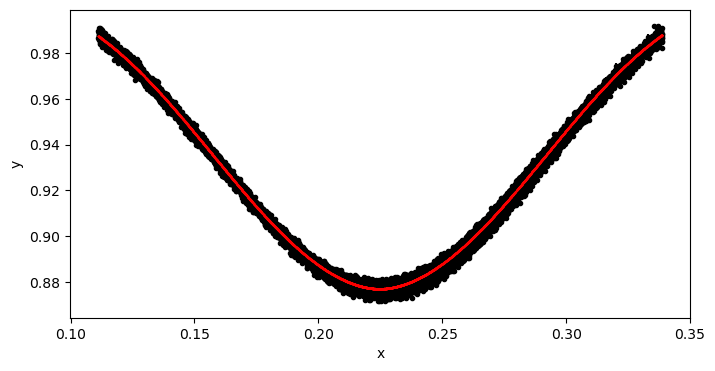

emcee parallel enabled, use 4 CPUs.


100%|██████████████████████████████████████████████████████████| 1000/1000 [01:14<00:00, 13.46it/s]


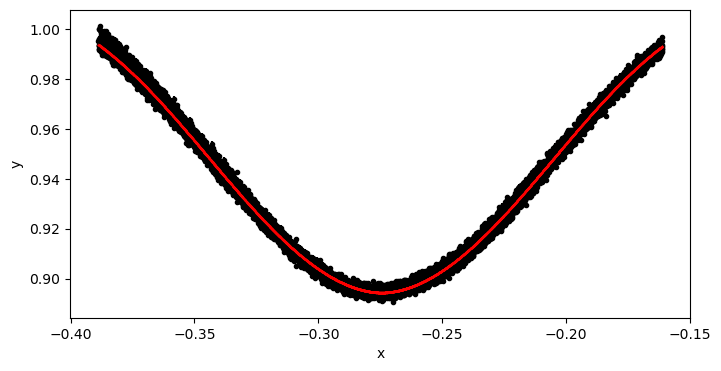

In [30]:
# run the initial model fit using MCMC for the primary and secondary eclipses 
run_init_fit = True

if run_init_fit:
    mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = etv_functions.run_mcmc_initial_fit(data_primary, start_vals, nruns = 1000, pool=-2, plot_chains = False, plot = True)
    if t0_secondary is not None:
        mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = etv_functions.run_mcmc_initial_fit(data_secondary, start_vals_s, nruns = 1000, pool=-2, plot_chains = False, plot = True)
    !$NOTIFY_CMD "Initial fit done"

In [46]:
if not run_init_fit:  # case init fit has been previously saved and to be reussed
    print("Use pre-defined inital model params:")
    # initial fit params from TESS data
    # # LS Period, clipped LC: 1.2XD
    # mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = 1.0236974229571598, -0.12982154789033262, -0.26792291349889563, 0.07502819879844122, 0.8811107790471274
    # mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = 1.0148412739248864, -0.1382231493062348, 0.2312342989509577, 0.07127284131143338, 0.888418197129901

    # use MCMC Period and t0, narrower clipped LC: 1.0XD7
    mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = 1.0069772642763068, -0.130011085474523, 0.22464279787761138, 0.06664044804384145, 0.9328898692297569
    mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = 1.013081338351713, -0.11868709084275225, -0.2745389012425915, 0.06822470076070729, 0.9411113072508461


    etv_functions.plot_initial_guess(data_primary, ph_binned, flux_binned, err_binned, *[mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau])
    etv_functions.plot_initial_guess(data_secondary, ph_binned_s, flux_binned_s, err_binned_s, *[mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s])    

In [32]:
print("Initial model params:")  # For information, and they can be copied to the cell above for future reuse

print("mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = " + ", ".join([str(v) for v in [mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau]]))
if t0_secondary is not None:
    print("mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = " + ", ".join([str(v) for v in [mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s]]))

Initial model params:
mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = 1.0069772642763068, -0.130011085474523, 0.22464279787761138, 0.06664044804384145, 0.9328898692297569
mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = 1.013081338351713, -0.11868709084275225, -0.2745389012425915, 0.06822470076070729, 0.9411113072508461


3389

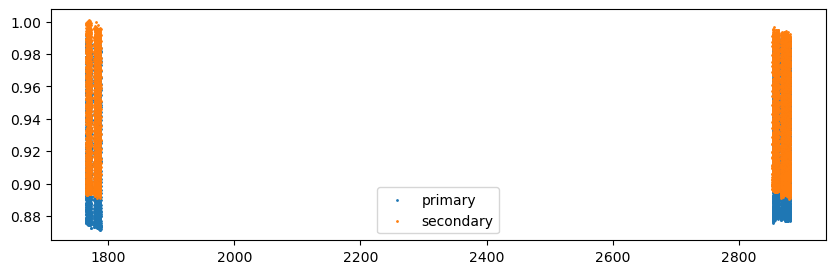

In [33]:
fig = plt.subplots(figsize=(10, 3), sharex=True)
plt.scatter(data_primary.time,data_primary.flux , s = 1, label = 'primary')
if t0_secondary is not None:
    plt.scatter(data_secondary.time,data_secondary.flux , s = 1, label = 'secondary')
plt.legend()

# calculate the number of transits there are within the data 
n_transits = int((max(data_primary.time) - min(data_primary.time)) / period)
n_transits

1764.7311 0.3296734 1764.7311


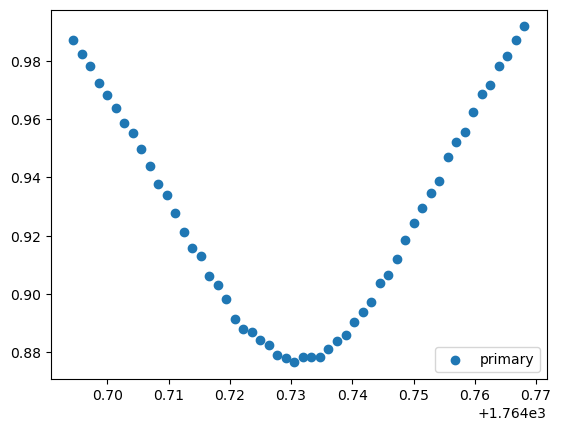

1764.7311 0.3296734 1765.0607734


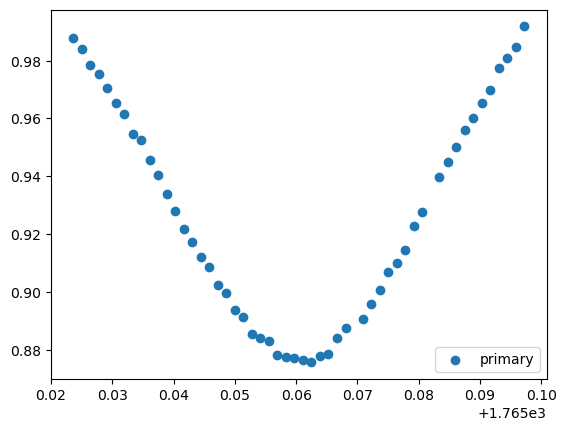

1764.7311 0.3296734 1765.3904468


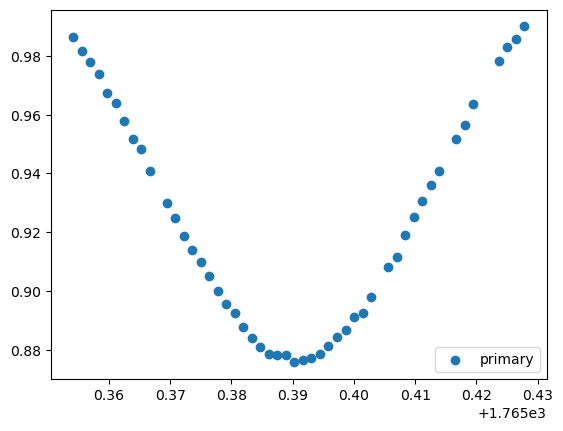

1764.8959367 0.3296734 1764.8959367


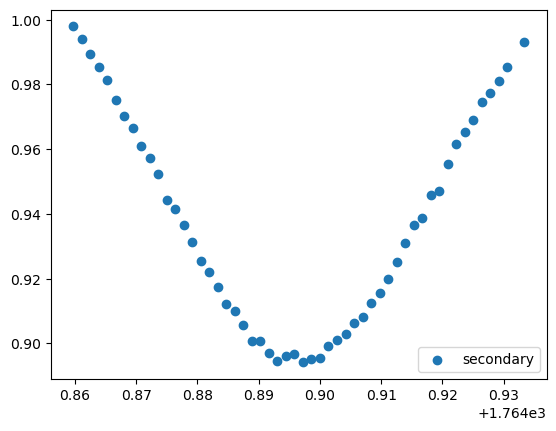

1764.8959367 0.3296734 1765.2256101


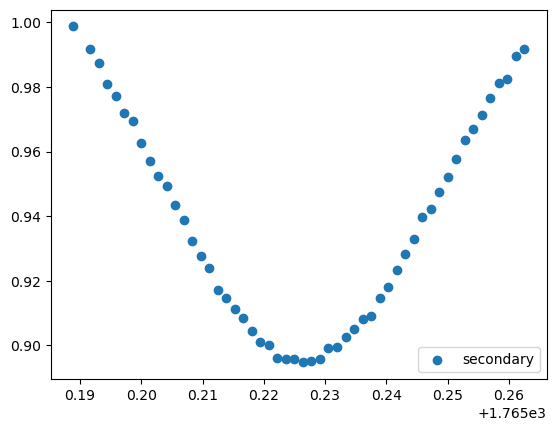

1764.8959367 0.3296734 1765.5552835


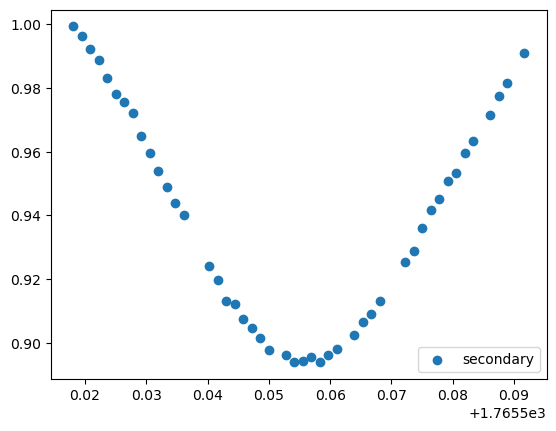

In [34]:
tr_index = range(0,n_transits)

for i in tr_index[0:3]:        
    transit_time = t0_primary+(period*i)
    x = np.array(data_primary.time)
    y = np.array(data_primary.flux) 
    yerr = np.array(data_primary.err)
    
    print (t0_primary, period, transit_time)
    
    mask = (x > (transit_time - (0.2*period))) & (x < (transit_time + (0.2*period))) 
    
    x = np.array(x[mask])
    y = np.array(y[mask]) 
    yerr = np.array(yerr[mask])
    fig, ax = plt.subplots()
    plt.scatter(x,y, label="primary")
    plt.legend(loc="lower right")
    plt.show()
    

if t0_secondary is not None:
    for i in tr_index[0:3]:        
        transit_time = t0_secondary+(period*i)
        x = np.array(data_secondary.time)
        y = np.array(data_secondary.flux) 
        yerr = np.array(data_secondary.err)
        
        print (t0_secondary, period, transit_time)
        
        mask = (x > (transit_time - (0.2*period))) & (x < (transit_time + (0.2*period))) 
        
        x = np.array(x[mask])
        y = np.array(y[mask]) 
        yerr = np.array(yerr[mask])
        fig, ax = plt.subplots()
        plt.scatter(x,y, label="secondary")
        plt.legend(loc="lower right")
        plt.show()

In [55]:
# Provide a warning if the expected number of data points per clipped LC is smaller than the default minimum (20)
longest_cadence = np.max(sr.exptime)
est_number_data_primary   = int(duration_hr_primary / longest_cadence.to(u.hr).value)
est_number_data_secondary = int(duration_hr_secondary / longest_cadence.to(u.hr).value)
print(f"Expected num of data points of a clipped LC in longest cadence ({longest_cadence}): {est_number_data_primary} / {est_number_data_secondary}")
if est_number_data_primary < 20:
    display(HTML("<span style='background-color: rgba(255, 0, 0, 0.7); padding-left: 1ch; padding-right: 1ch;'>WARN:</span> num of data points for a clipped LC (primary) < 20"))
if est_number_data_secondary < 20:
    display(HTML("<span style='background-color: rgba(255, 0, 0, 0.7); padding-left: 1ch; padding-right: 1ch;'>WARN:</span> num of data points for a clipped LC (secondary) < 20"))

Expected num of data points of a clipped LC in longest cadence (120.0 s): 54 / 54


Fitting individual primary eclipses...
Existing manifest file found, will skip previously processed LCs and append to end of manifest file
Number 0 has already been completed -- skip
Number 1 has already been completed -- skip
Number 2 has already been completed -- skip
1765.7201201999999 1.0069772642763068 -0.130011085474523 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 397.00it/s]


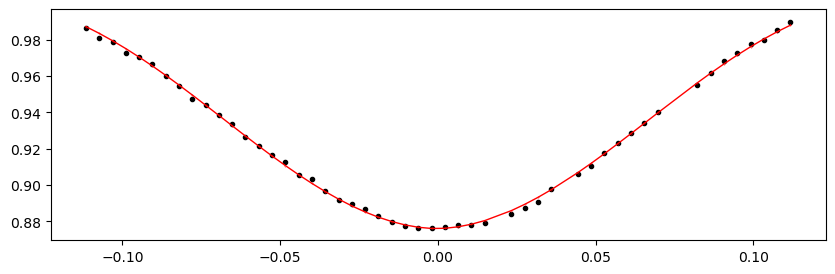

1766.0497936 1.0069772642763068 -0.130011085474523 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 389.91it/s]


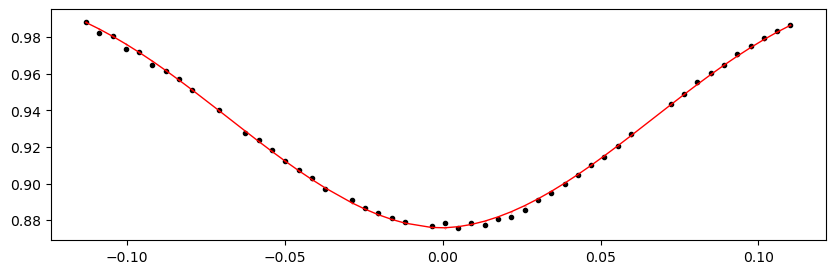

1766.379467 1.0069772642763068 -0.130011085474523 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 392.73it/s]


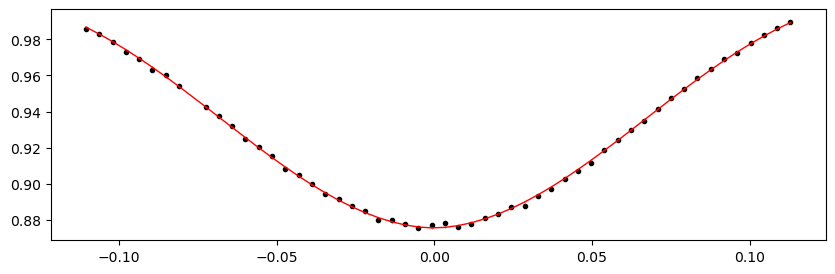

1766.7091404 1.0069772642763068 -0.130011085474523 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 378.24it/s]


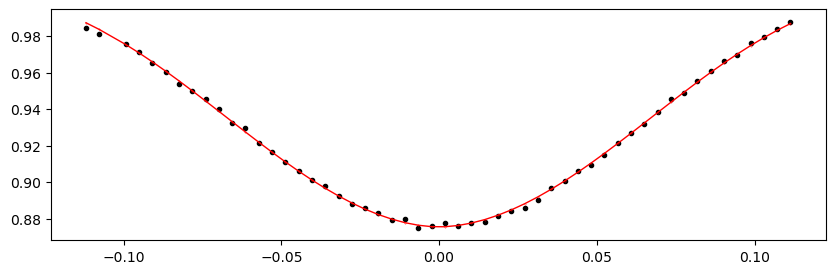

1767.0388138 1.0069772642763068 -0.130011085474523 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 401.05it/s]


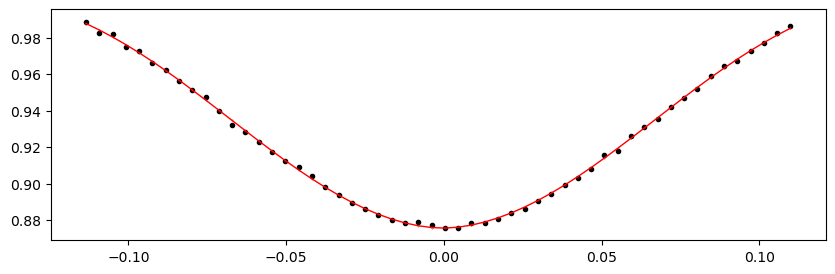

1767.3684872 1.0069772642763068 -0.130011085474523 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 374.13it/s]


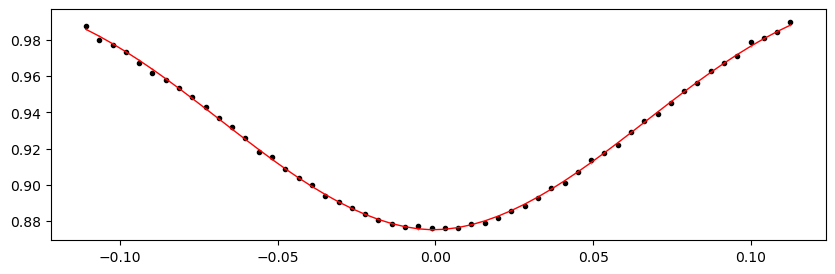

1767.6981606 1.0069772642763068 -0.130011085474523 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 390.99it/s]


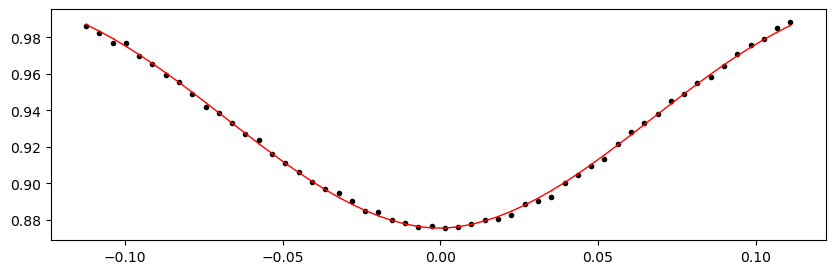

1768.027834 1.0069772642763068 -0.130011085474523 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 393.66it/s]


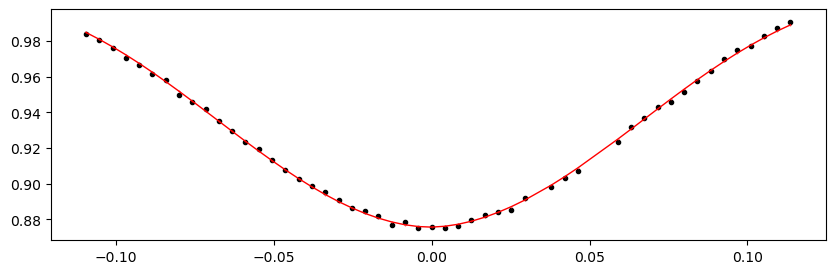

1768.3575074 1.0069772642763068 -0.130011085474523 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 395.00it/s]


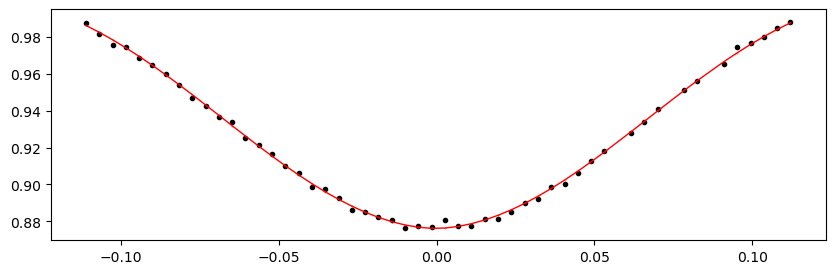

1768.6871808 1.0069772642763068 -0.130011085474523 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 399.80it/s]


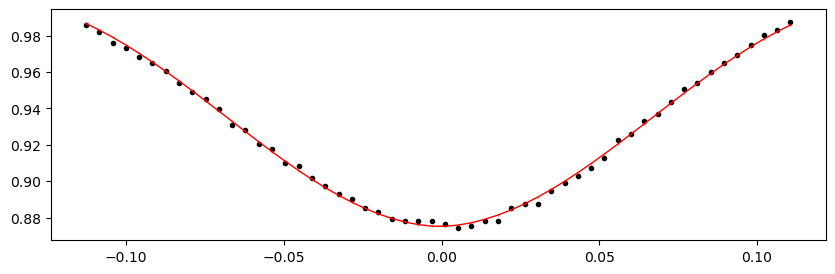

1769.0168542 1.0069772642763068 -0.130011085474523 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 400.25it/s]


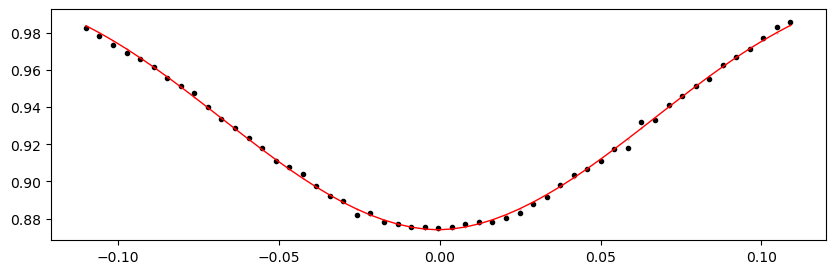

1769.3465276 1.0069772642763068 -0.130011085474523 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 391.95it/s]


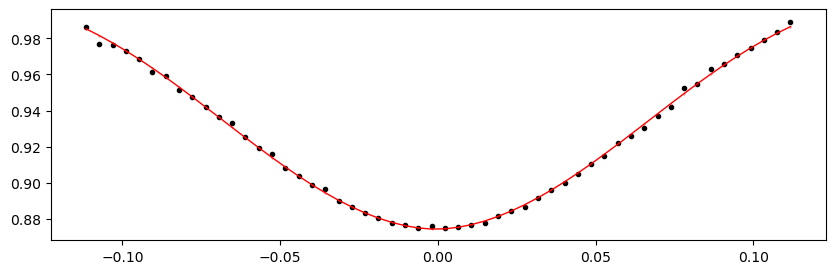

1769.676201 1.0069772642763068 -0.130011085474523 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 397.39it/s]


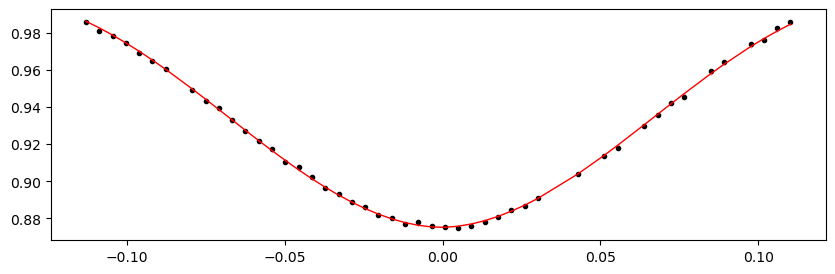

1770.0058744 1.0069772642763068 -0.130011085474523 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 391.78it/s]


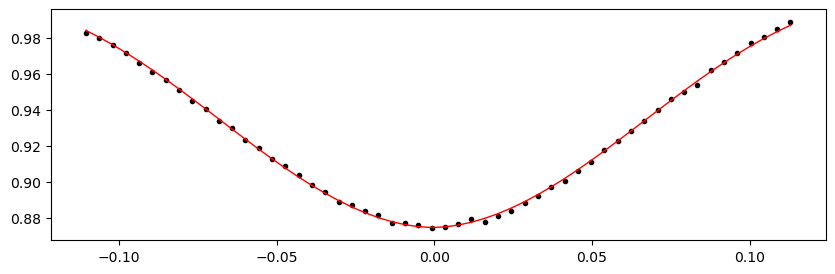

1770.3355477999999 1.0069772642763068 -0.130011085474523 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 407.35it/s]


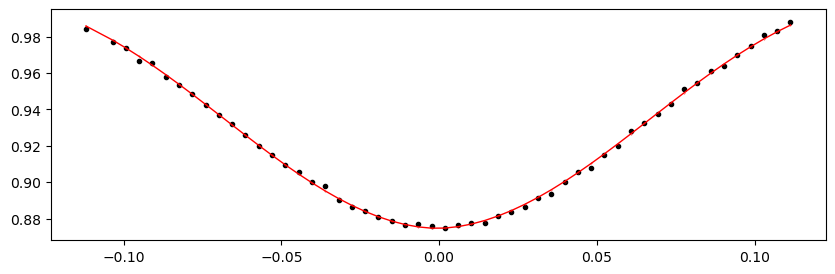

1770.6652212 1.0069772642763068 -0.130011085474523 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 400.84it/s]


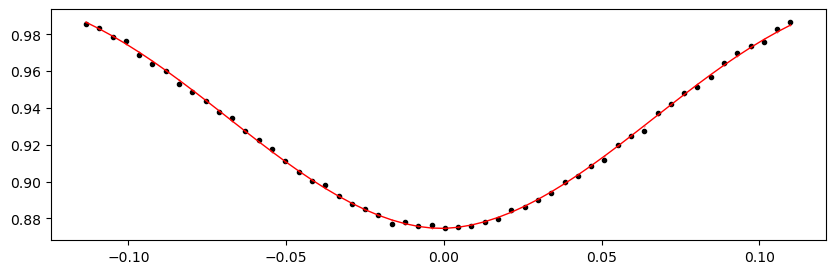

1770.9948946 1.0069772642763068 -0.130011085474523 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 362.79it/s]


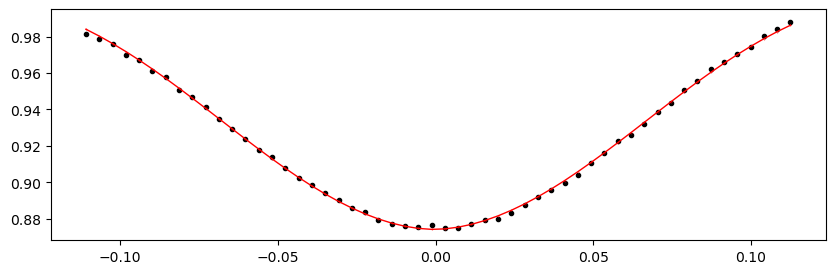

1771.324568 1.0069772642763068 -0.130011085474523 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 387.88it/s]


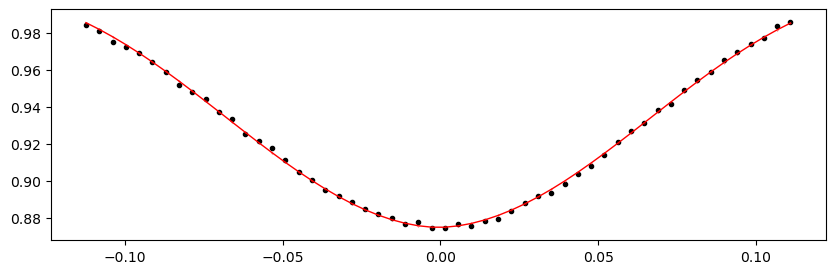

1771.6542414 1.0069772642763068 -0.130011085474523 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 389.45it/s]


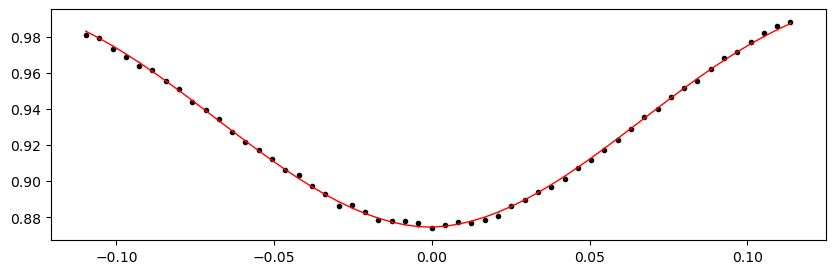

1771.9839147999999 1.0069772642763068 -0.130011085474523 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 382.88it/s]


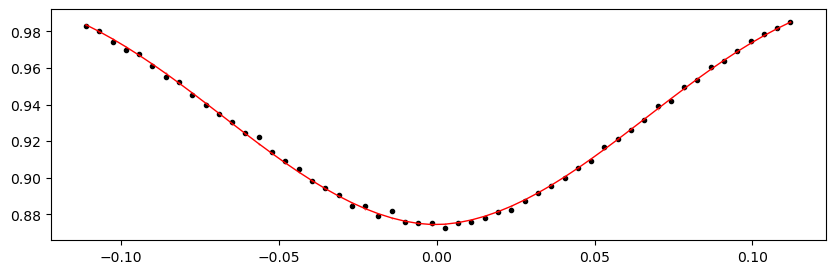

1772.3135882 1.0069772642763068 -0.130011085474523 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 370.69it/s]


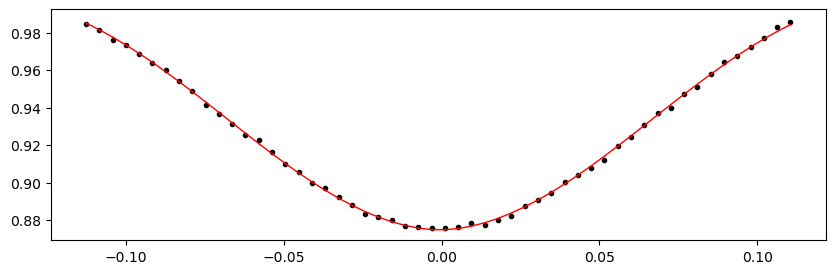

1772.6432616 1.0069772642763068 -0.130011085474523 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 380.64it/s]


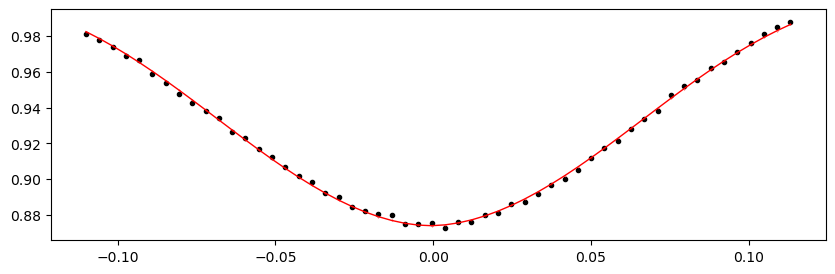

1777.918036 1.0069772642763068 -0.130011085474523 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 397.32it/s]


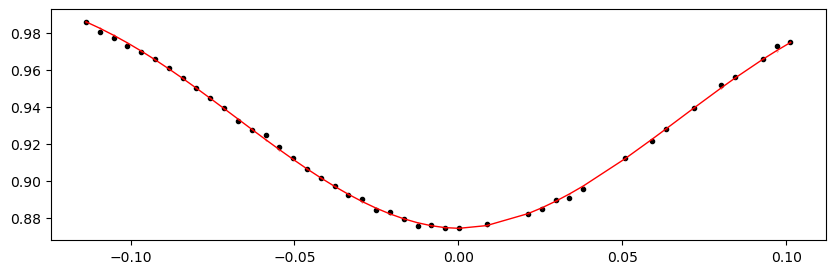

1778.2477094 1.0069772642763068 -0.130011085474523 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 392.05it/s]


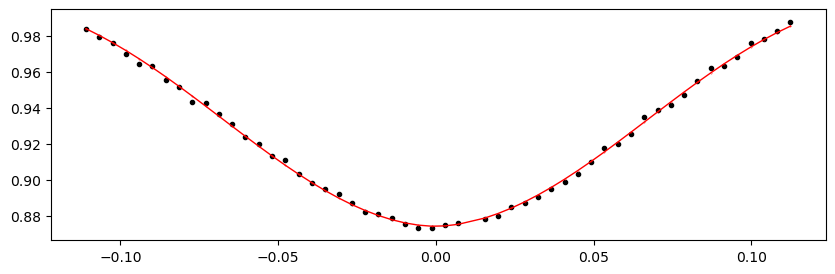

1778.5773828 1.0069772642763068 -0.130011085474523 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 394.66it/s]


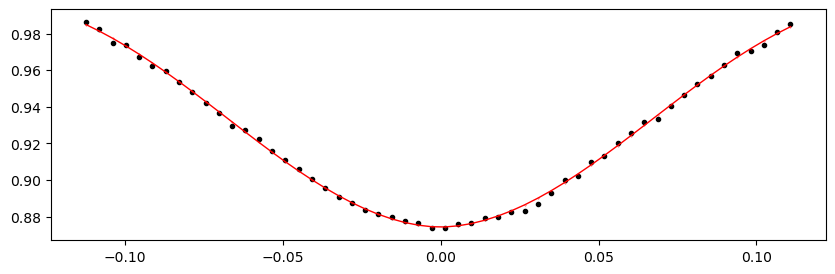

1778.9070562 1.0069772642763068 -0.130011085474523 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 405.16it/s]


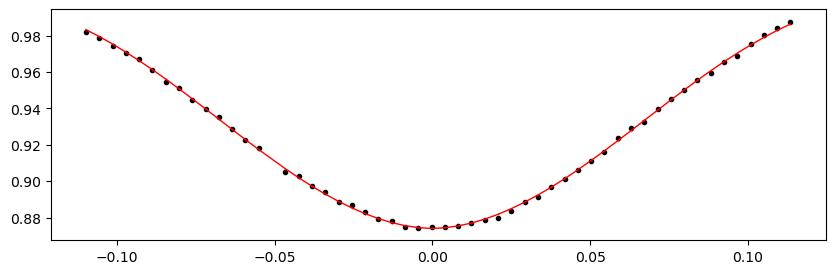

1779.2367296 1.0069772642763068 -0.130011085474523 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 402.42it/s]


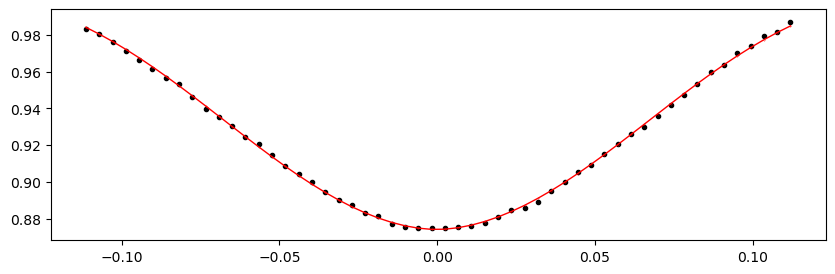

1779.566403 1.0069772642763068 -0.130011085474523 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 406.46it/s]


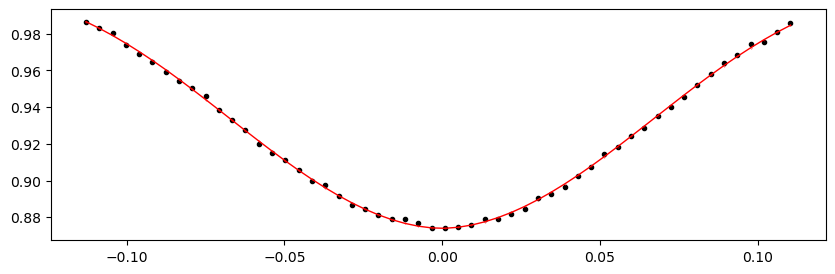

1779.8960763999999 1.0069772642763068 -0.130011085474523 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 403.54it/s]


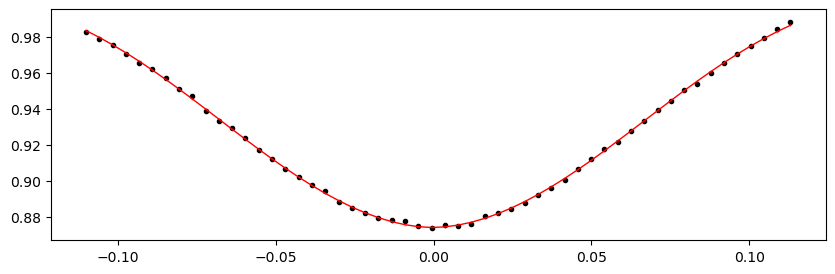

1780.2257498 1.0069772642763068 -0.130011085474523 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 399.88it/s]


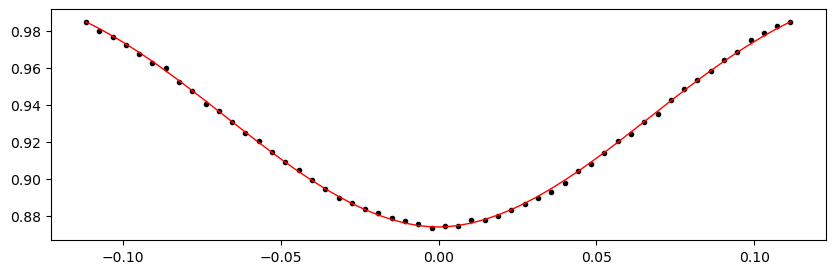

1780.5554232 1.0069772642763068 -0.130011085474523 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 395.19it/s]


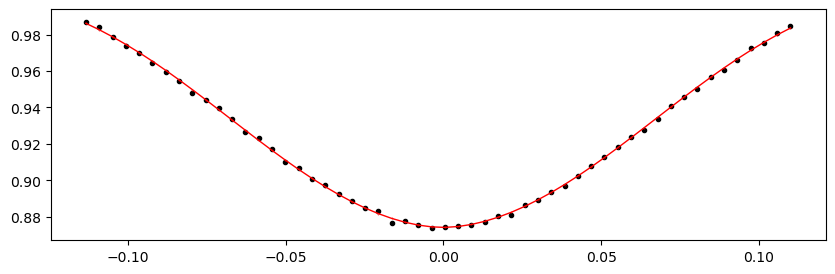

1780.8850966 1.0069772642763068 -0.130011085474523 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 396.58it/s]


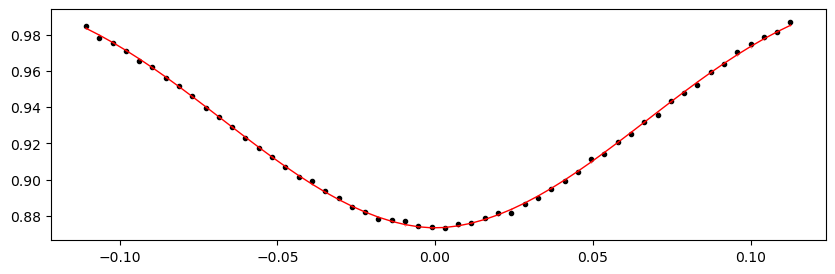

1781.21477 1.0069772642763068 -0.130011085474523 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 403.00it/s]


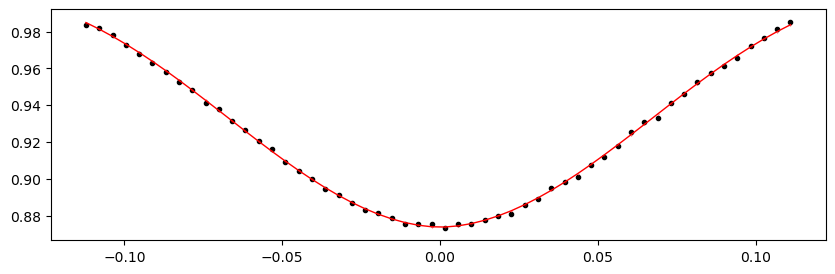

1781.5444433999999 1.0069772642763068 -0.130011085474523 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 405.74it/s]


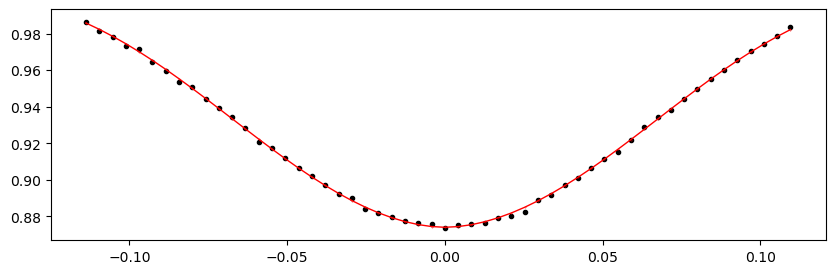

1781.8741168 1.0069772642763068 -0.130011085474523 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 405.05it/s]


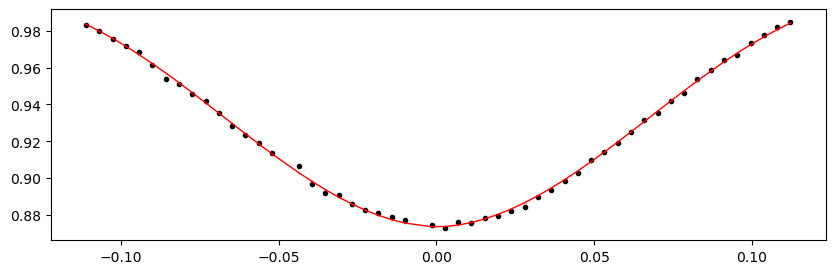

1782.2037902 1.0069772642763068 -0.130011085474523 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 406.34it/s]


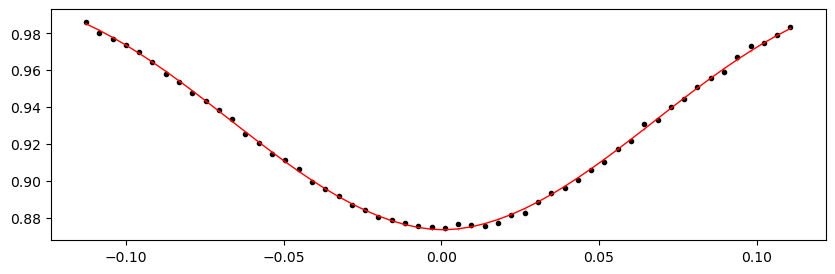

1782.5334636 1.0069772642763068 -0.130011085474523 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 403.26it/s]


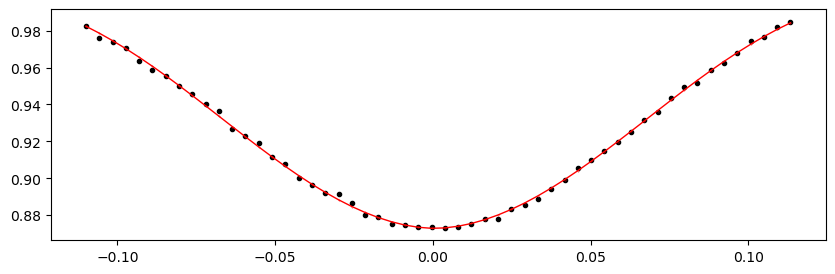

1782.863137 1.0069772642763068 -0.130011085474523 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 401.79it/s]


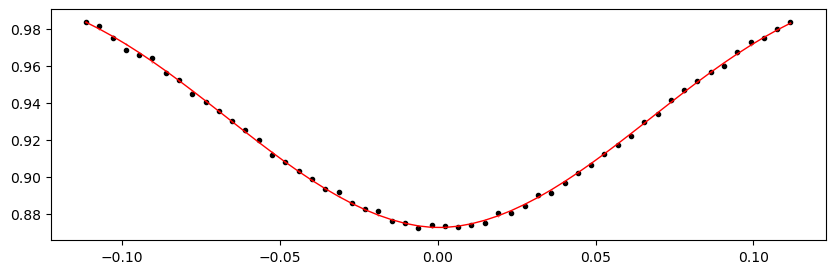

1783.1928103999999 1.0069772642763068 -0.130011085474523 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 394.65it/s]


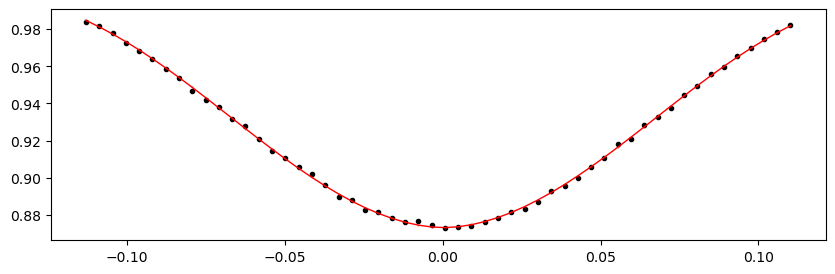

1783.5224838 1.0069772642763068 -0.130011085474523 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 372.68it/s]


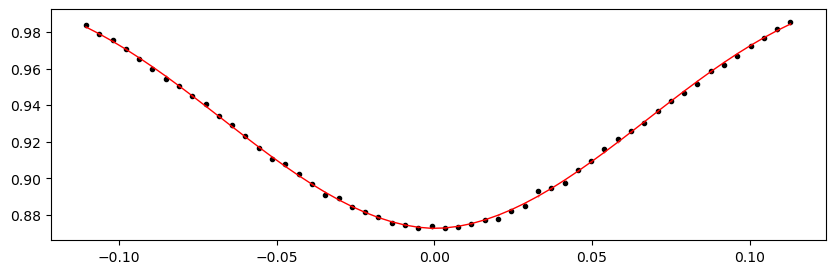

1783.8521572 1.0069772642763068 -0.130011085474523 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 375.67it/s]


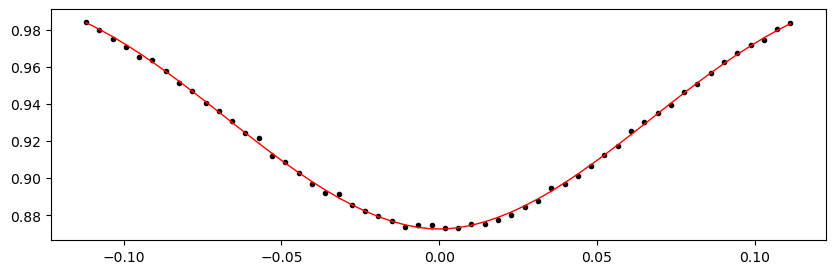

1784.1818306 1.0069772642763068 -0.130011085474523 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 389.09it/s]


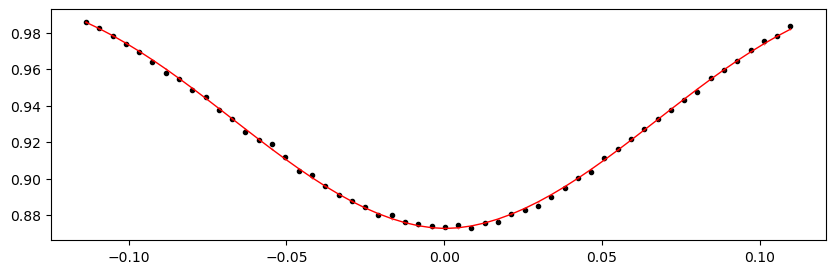

1784.511504 1.0069772642763068 -0.130011085474523 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 381.98it/s]


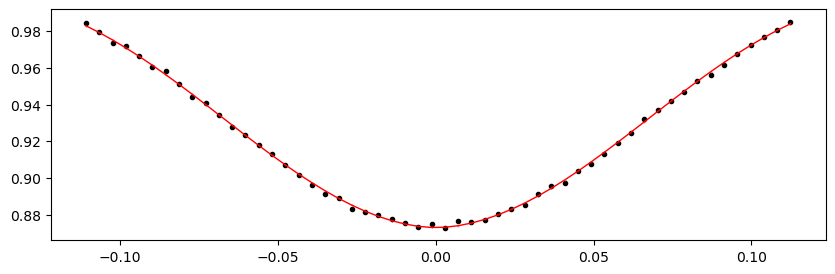

1784.8411773999999 1.0069772642763068 -0.130011085474523 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 388.98it/s]


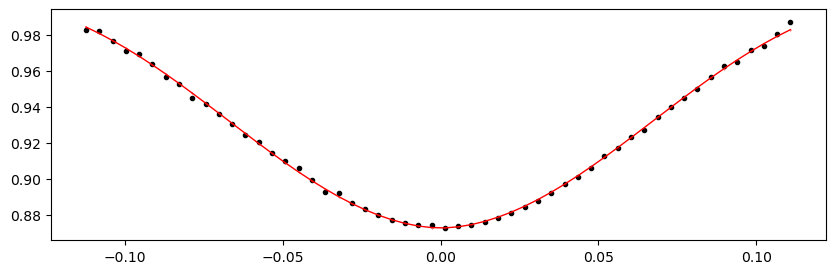

1785.1708508 1.0069772642763068 -0.130011085474523 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 370.40it/s]


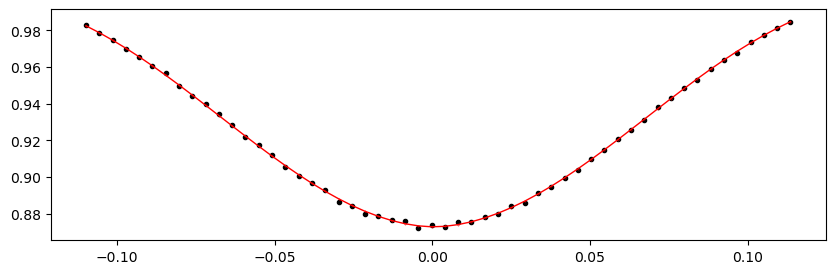

1785.5005242 1.0069772642763068 -0.130011085474523 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 399.98it/s]


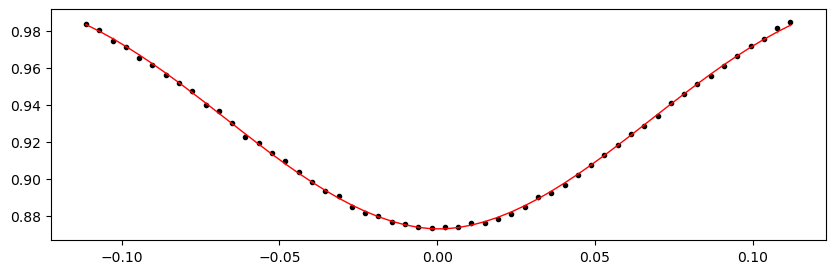

1785.8301976 1.0069772642763068 -0.130011085474523 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 404.47it/s]


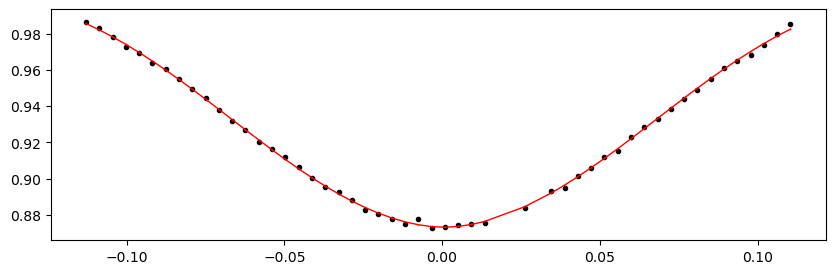

1786.159871 1.0069772642763068 -0.130011085474523 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 397.92it/s]


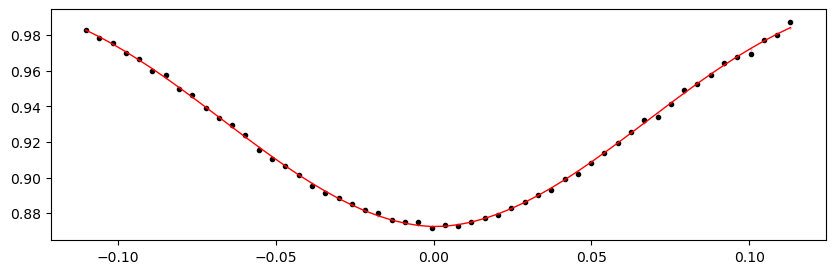

1786.4895443999999 1.0069772642763068 -0.130011085474523 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 400.48it/s]


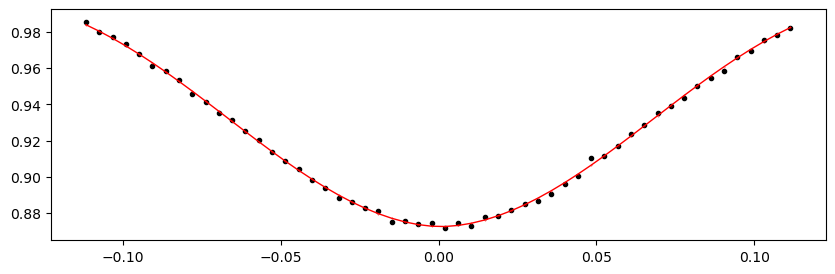

1786.8192178 1.0069772642763068 -0.130011085474523 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 399.18it/s]


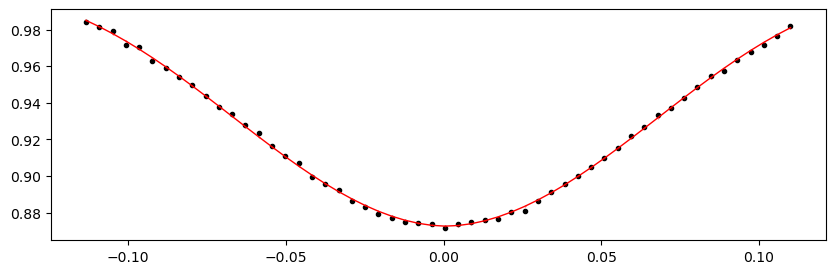

1787.1488912 1.0069772642763068 -0.130011085474523 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 398.52it/s]


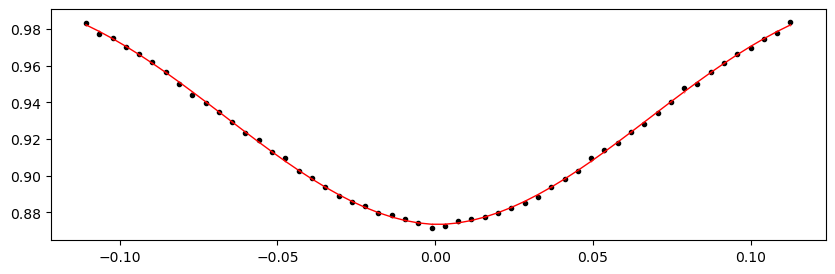

1787.4785646 1.0069772642763068 -0.130011085474523 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 391.35it/s]


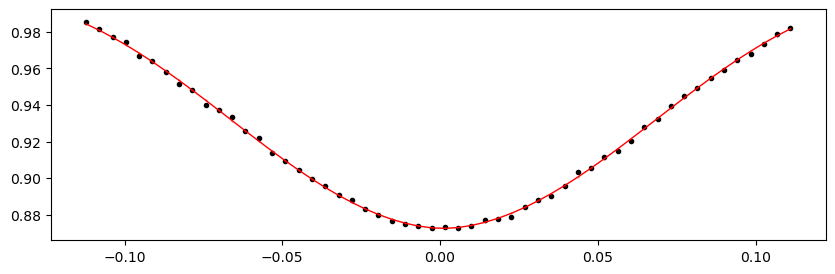

1787.808238 1.0069772642763068 -0.130011085474523 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 390.29it/s]


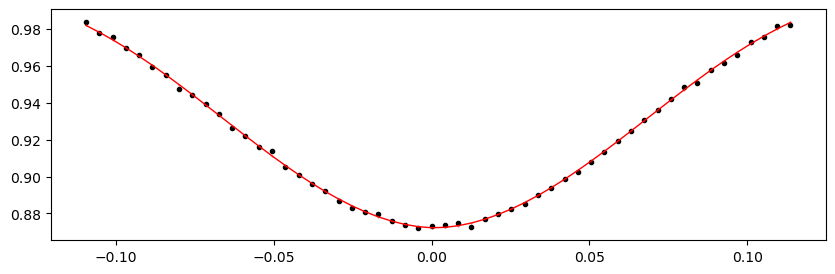

2853.6423402 1.0069772642763068 -0.130011085474523 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 392.86it/s]


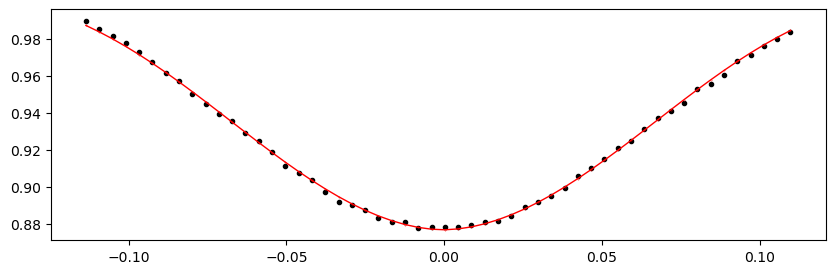

2853.9720136 1.0069772642763068 -0.130011085474523 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 390.22it/s]


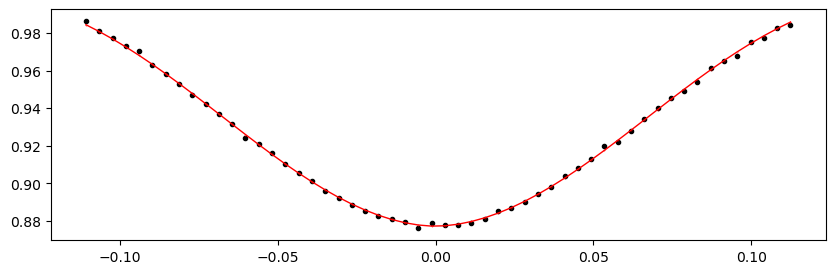

2854.301687 1.0069772642763068 -0.130011085474523 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 387.26it/s]


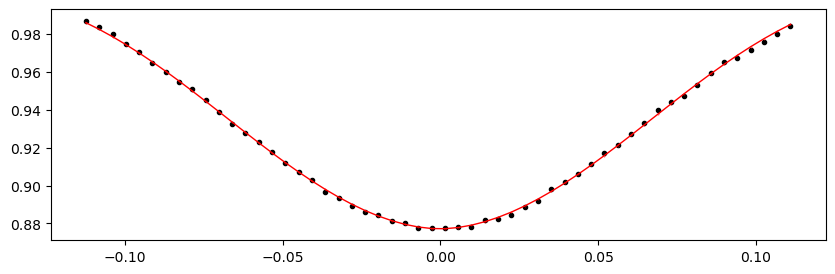

2854.6313603999997 1.0069772642763068 -0.130011085474523 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 391.90it/s]


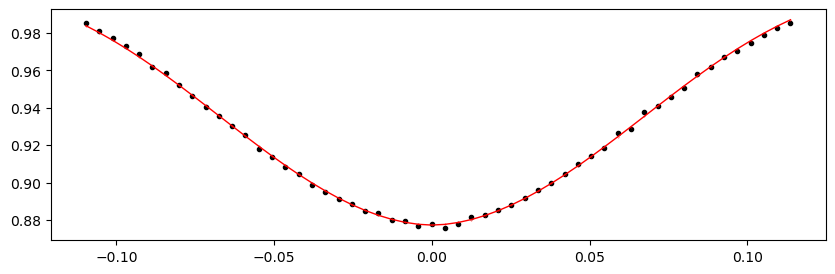

2854.9610338 1.0069772642763068 -0.130011085474523 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 390.08it/s]


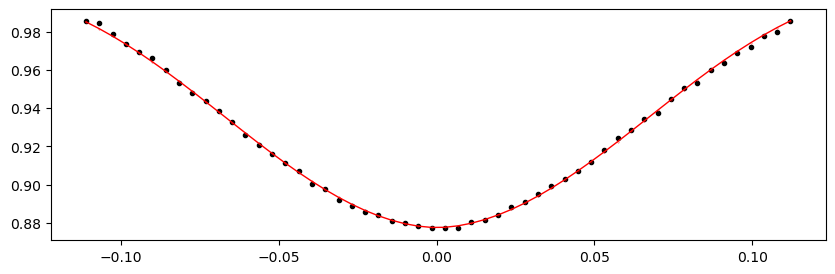

2855.2907072 1.0069772642763068 -0.130011085474523 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 387.90it/s]


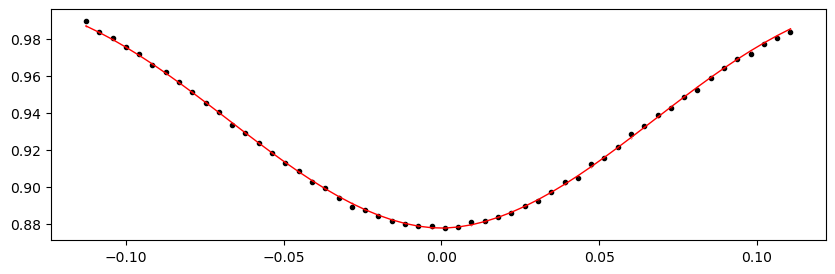

2855.6203806000003 1.0069772642763068 -0.130011085474523 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 384.57it/s]


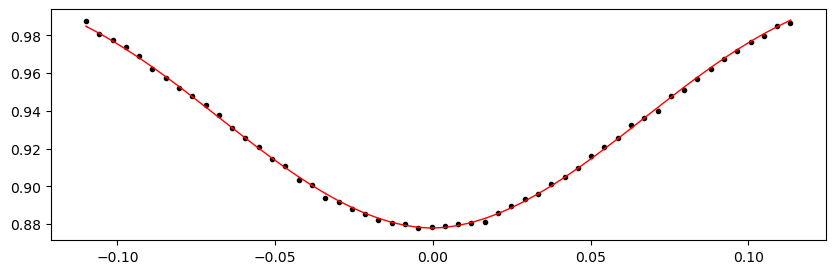

2855.950054 1.0069772642763068 -0.130011085474523 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 388.20it/s]


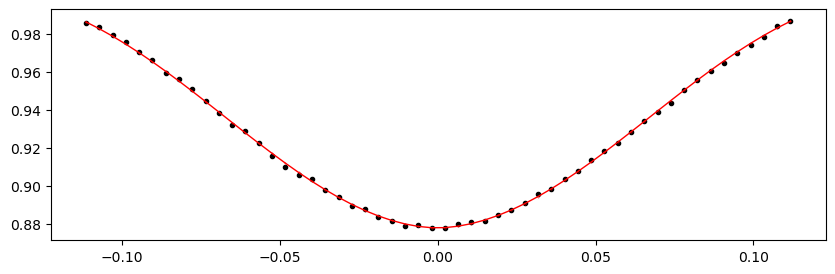

2856.2797274 1.0069772642763068 -0.130011085474523 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 389.87it/s]


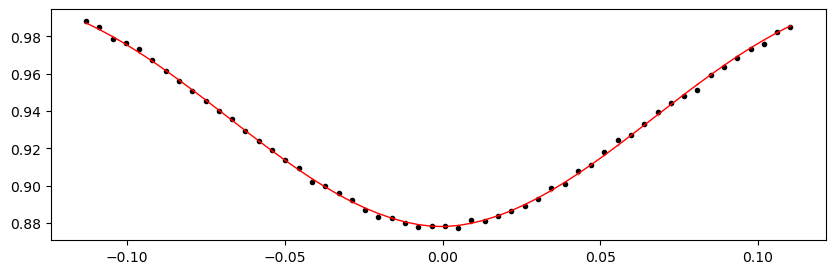

2856.6094008 1.0069772642763068 -0.130011085474523 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 390.16it/s]


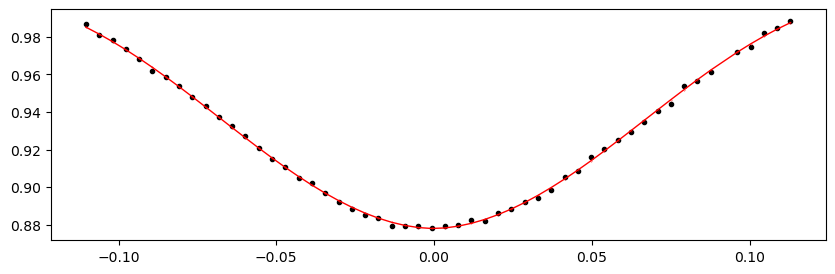

2856.9390742 1.0069772642763068 -0.130011085474523 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 389.31it/s]


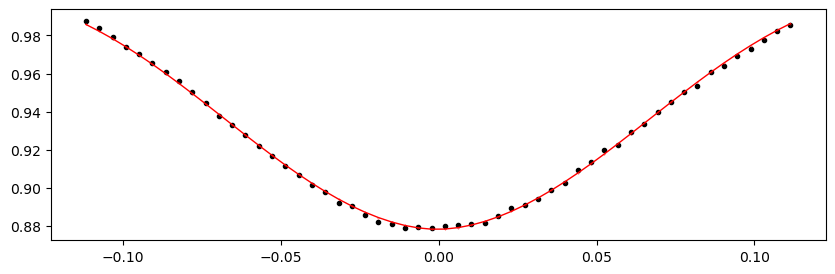

2857.2687476 1.0069772642763068 -0.130011085474523 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 389.84it/s]


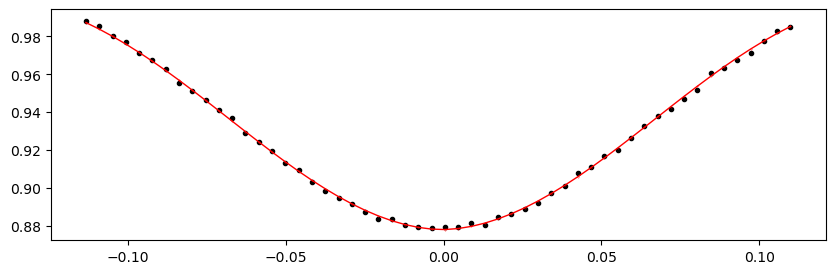

2857.5984209999997 1.0069772642763068 -0.130011085474523 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 390.33it/s]


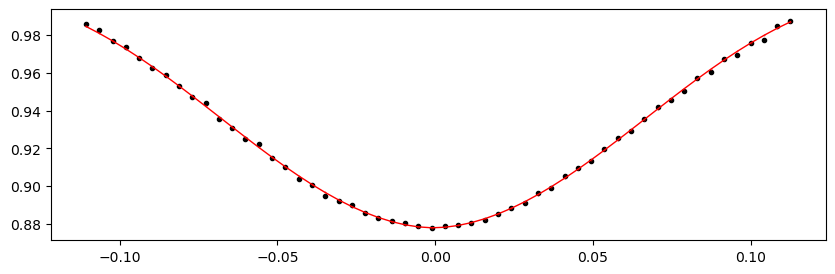

2857.9280944 1.0069772642763068 -0.130011085474523 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 384.17it/s]


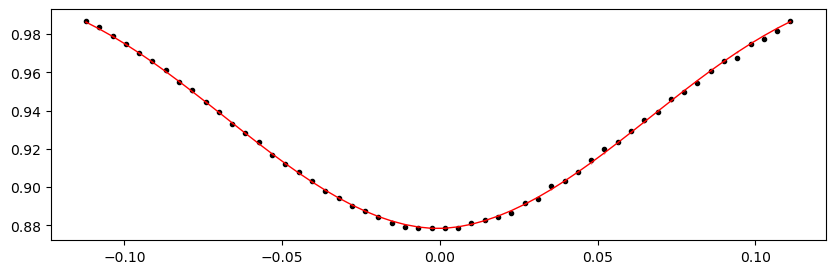

2858.2577678 1.0069772642763068 -0.130011085474523 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 392.65it/s]


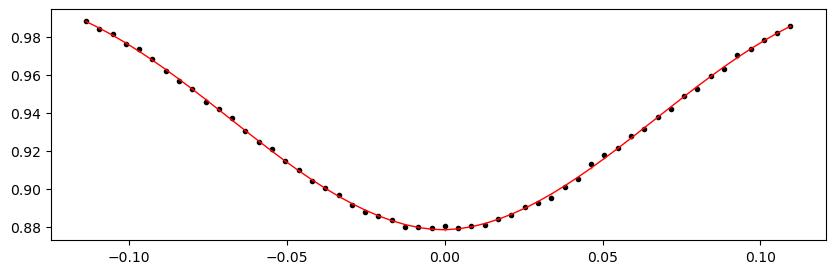

2858.5874412000003 1.0069772642763068 -0.130011085474523 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 392.08it/s]


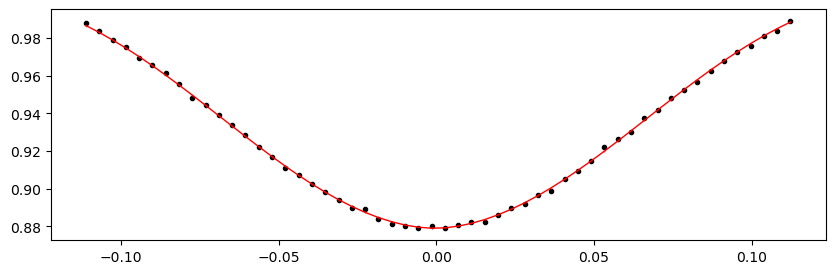

2858.9171146 1.0069772642763068 -0.130011085474523 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 385.18it/s]


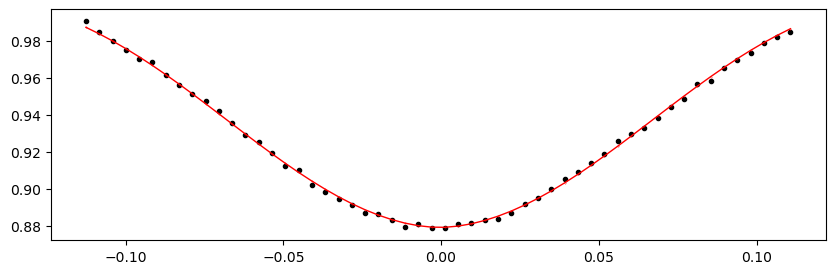

2859.246788 1.0069772642763068 -0.130011085474523 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 382.67it/s]


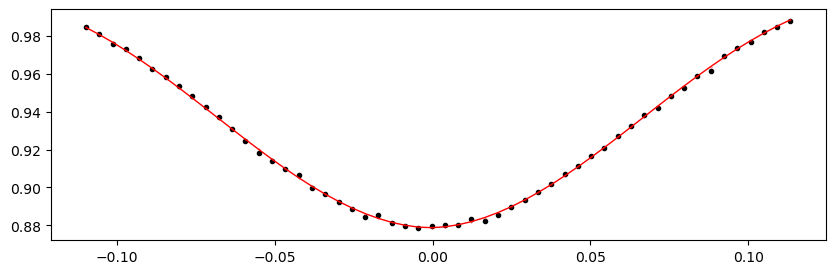

2859.5764614 1.0069772642763068 -0.130011085474523 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 386.40it/s]


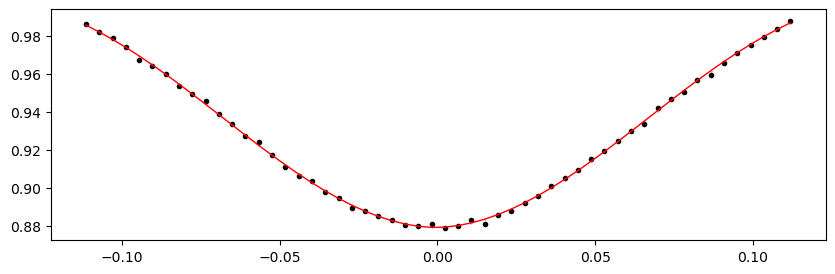

2859.9061348 1.0069772642763068 -0.130011085474523 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 386.16it/s]


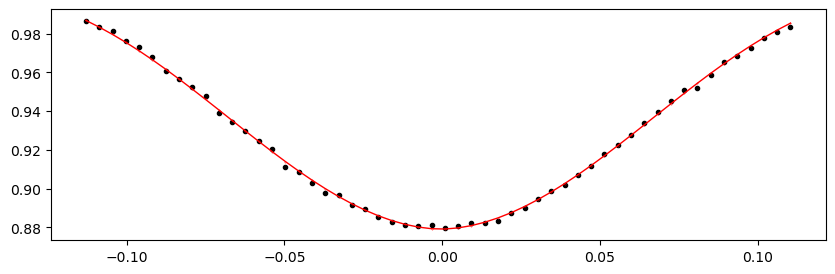

2860.2358082 1.0069772642763068 -0.130011085474523 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 389.09it/s]


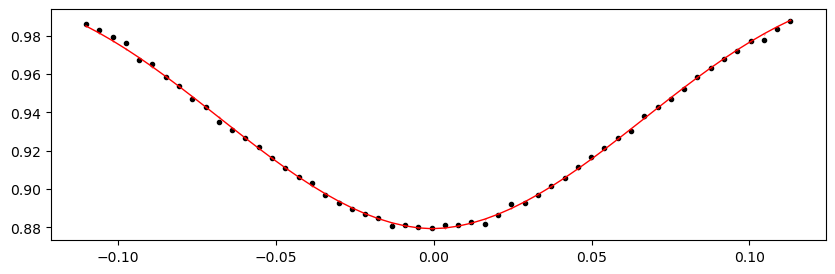

2860.5654815999997 1.0069772642763068 -0.130011085474523 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 349.81it/s]


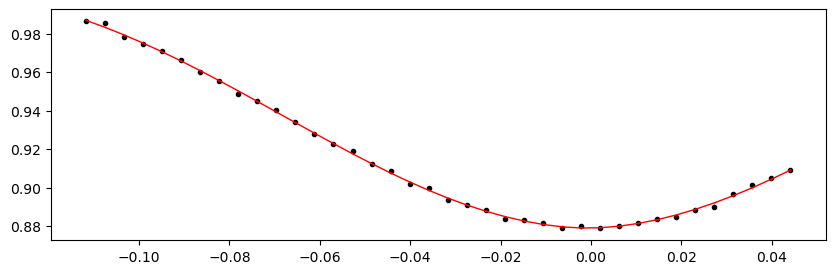

2860.895155 1.0069772642763068 -0.130011085474523 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 346.58it/s]


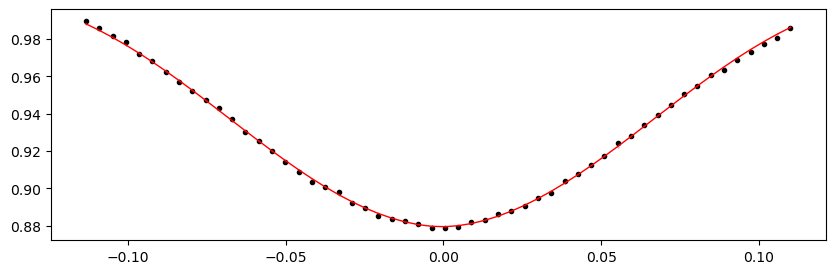

2861.2248283999998 1.0069772642763068 -0.130011085474523 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 345.23it/s]


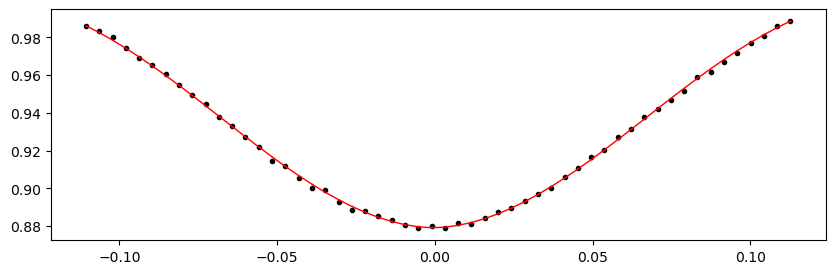

2861.5545018000003 1.0069772642763068 -0.130011085474523 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 388.29it/s]


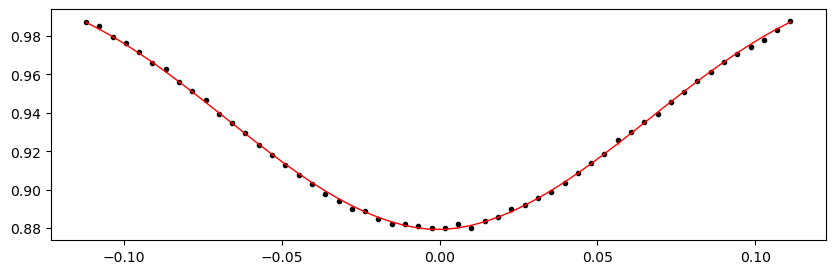

2861.8841752 1.0069772642763068 -0.130011085474523 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 385.62it/s]


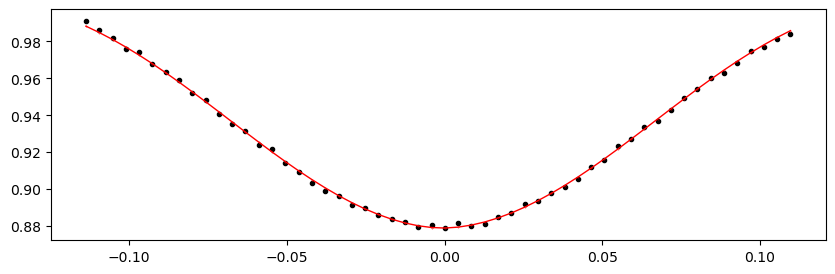

2862.2138486 1.0069772642763068 -0.130011085474523 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 384.51it/s]


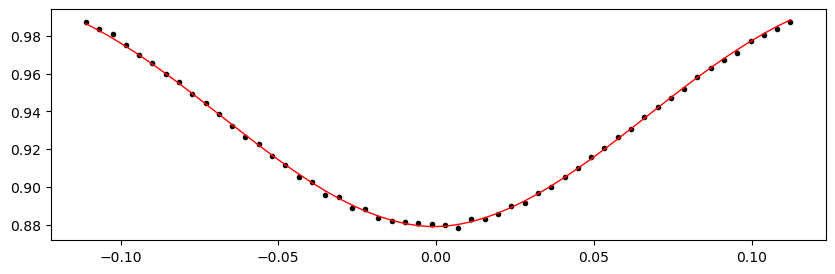

2862.543522 1.0069772642763068 -0.130011085474523 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 391.58it/s]


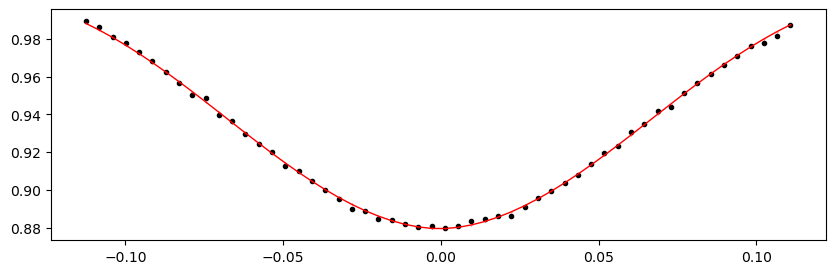

2862.8731954 1.0069772642763068 -0.130011085474523 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 381.77it/s]


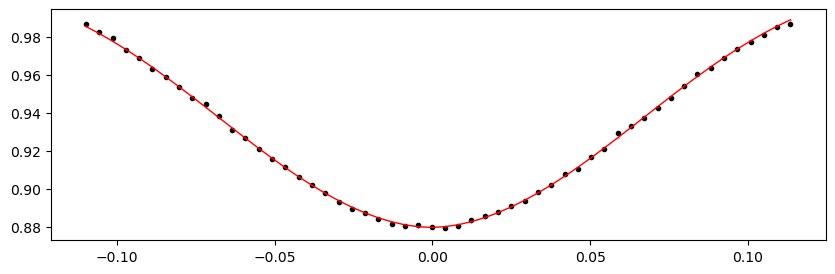

2863.2028688 1.0069772642763068 -0.130011085474523 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 390.43it/s]


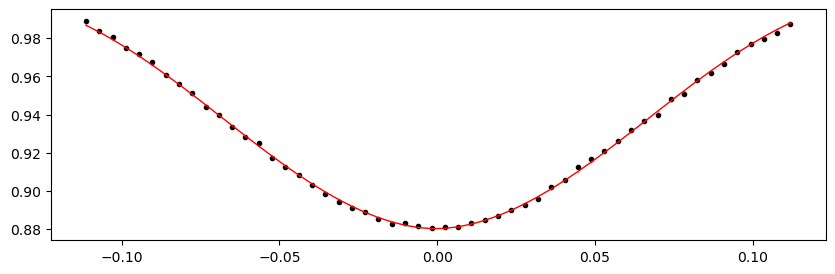

2866.4996028 1.0069772642763068 -0.130011085474523 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 383.08it/s]


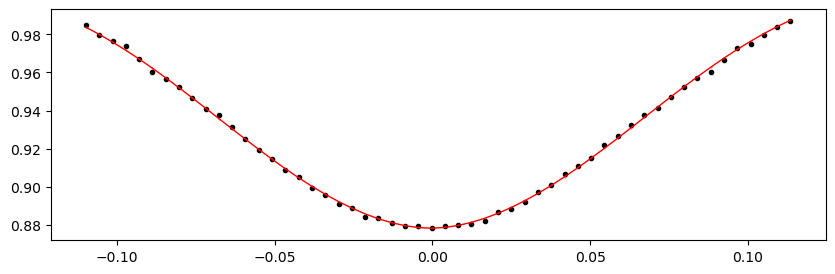

2866.8292762 1.0069772642763068 -0.130011085474523 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 391.23it/s]


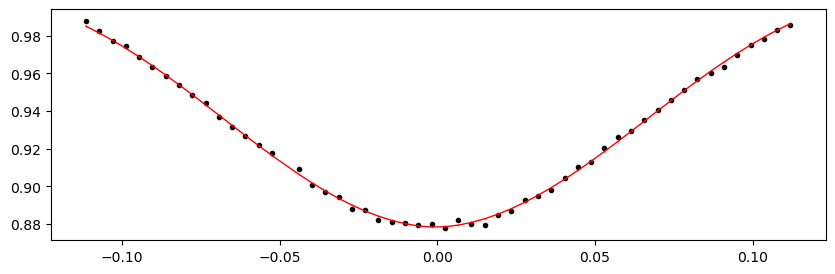

2867.1589495999997 1.0069772642763068 -0.130011085474523 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 389.45it/s]


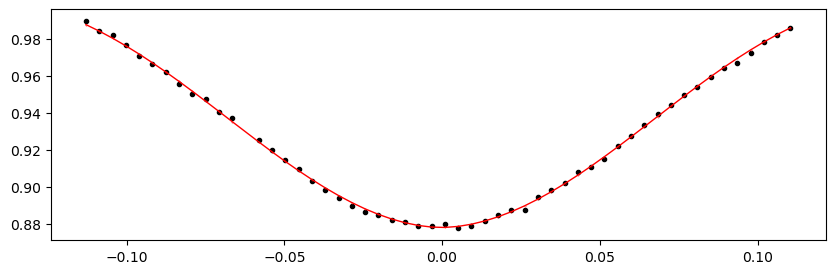

2867.488623 1.0069772642763068 -0.130011085474523 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 391.67it/s]


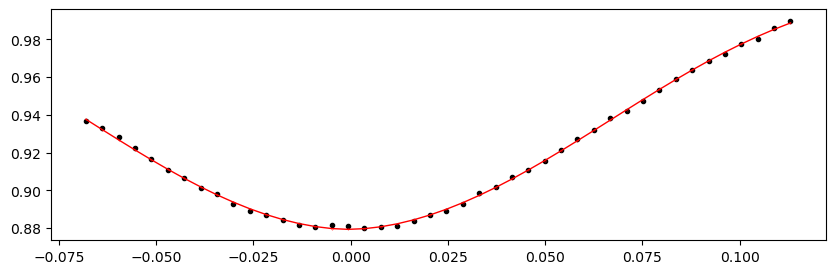

2867.8182964 1.0069772642763068 -0.130011085474523 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 389.38it/s]


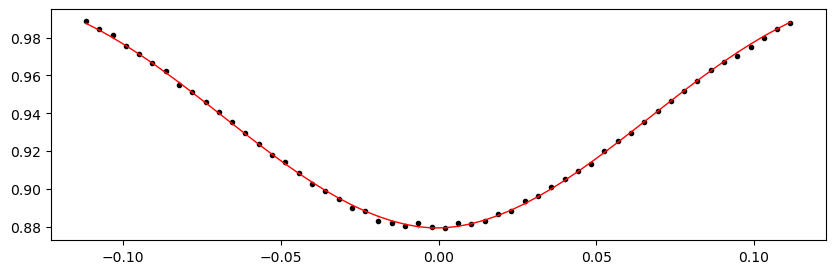

2868.1479698000003 1.0069772642763068 -0.130011085474523 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 391.14it/s]


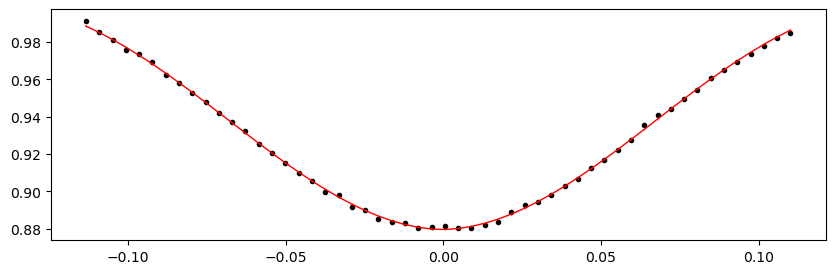

2868.4776432 1.0069772642763068 -0.130011085474523 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 389.49it/s]


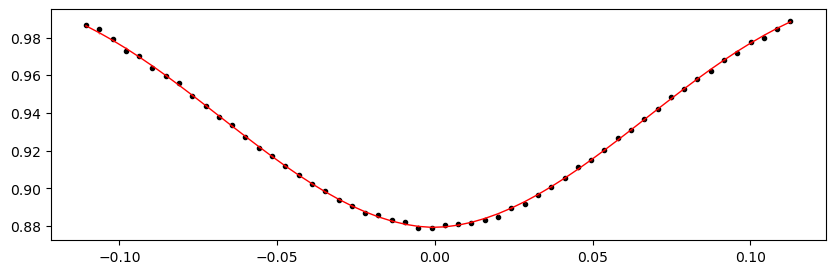

2868.8073166 1.0069772642763068 -0.130011085474523 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 390.73it/s]


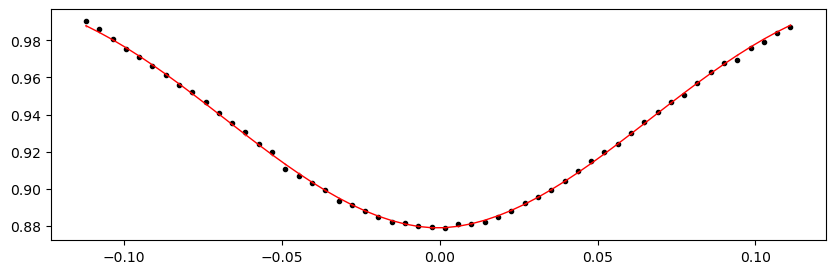

2869.13699 1.0069772642763068 -0.130011085474523 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 387.85it/s]


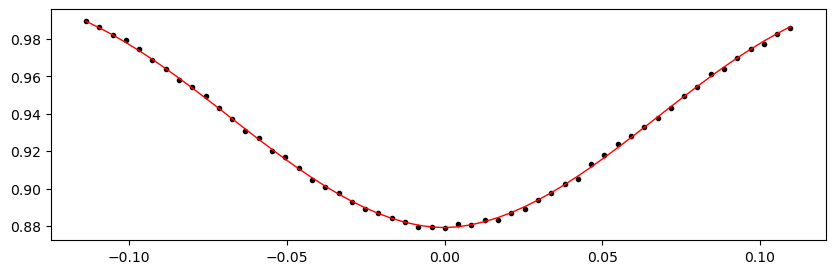

2869.4666634 1.0069772642763068 -0.130011085474523 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 387.40it/s]


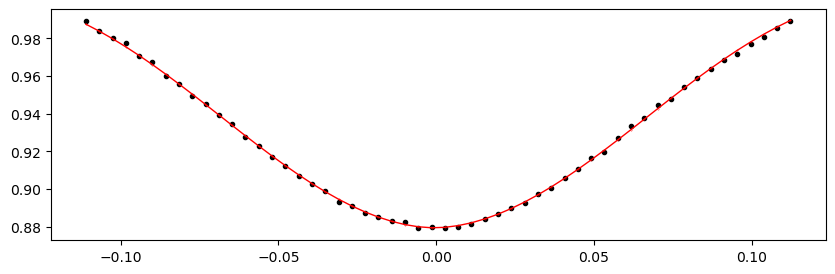

2869.7963368 1.0069772642763068 -0.130011085474523 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 385.21it/s]


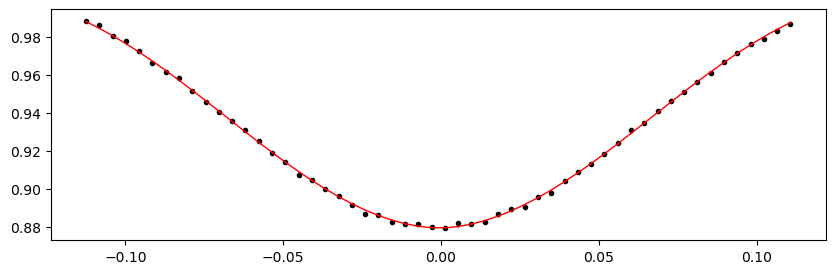

2870.1260101999997 1.0069772642763068 -0.130011085474523 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 390.65it/s]


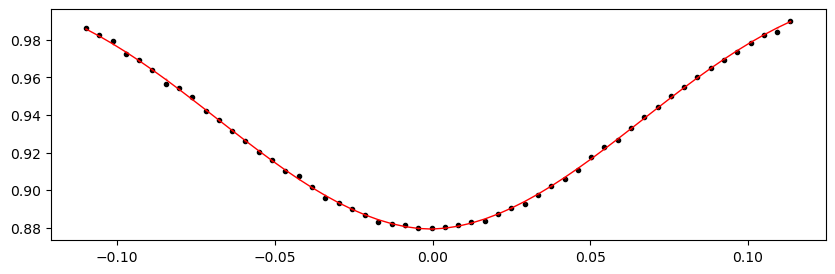

2870.4556836 1.0069772642763068 -0.130011085474523 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 389.62it/s]


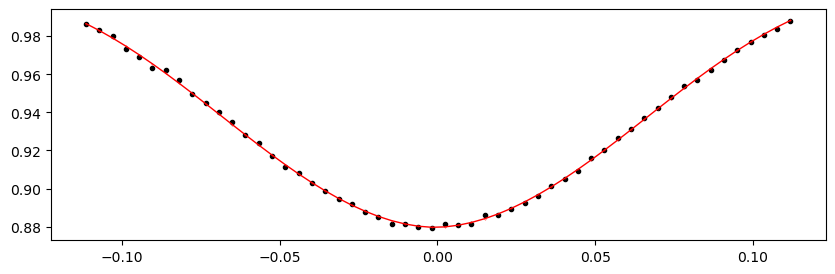

2870.7853569999997 1.0069772642763068 -0.130011085474523 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 390.55it/s]


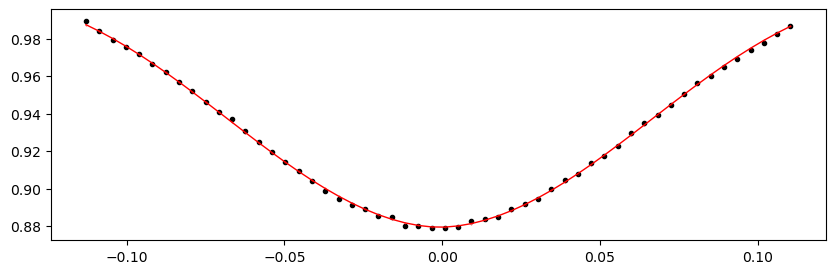

2871.1150304000003 1.0069772642763068 -0.130011085474523 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 384.61it/s]


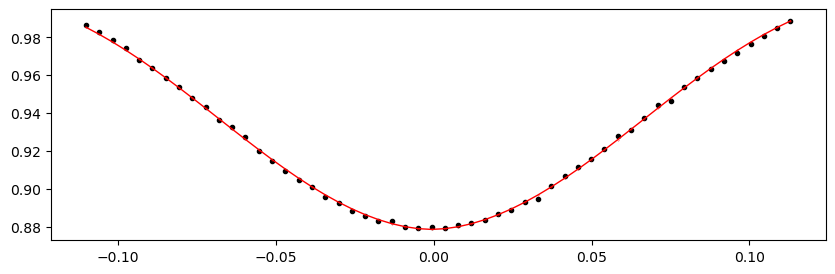

2871.4447038 1.0069772642763068 -0.130011085474523 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 386.08it/s]


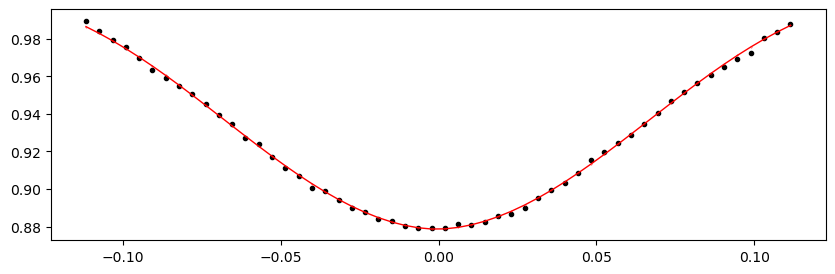

2871.7743772 1.0069772642763068 -0.130011085474523 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 385.97it/s]


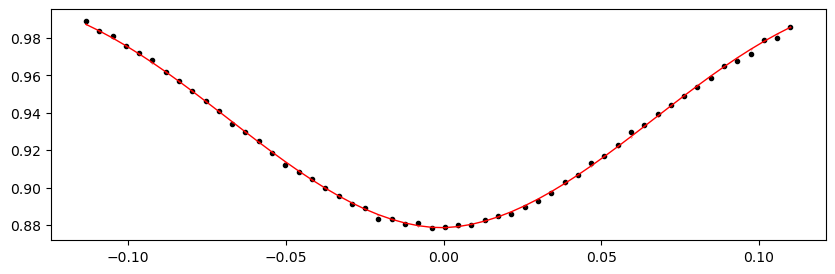

2872.1040506 1.0069772642763068 -0.130011085474523 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 387.00it/s]


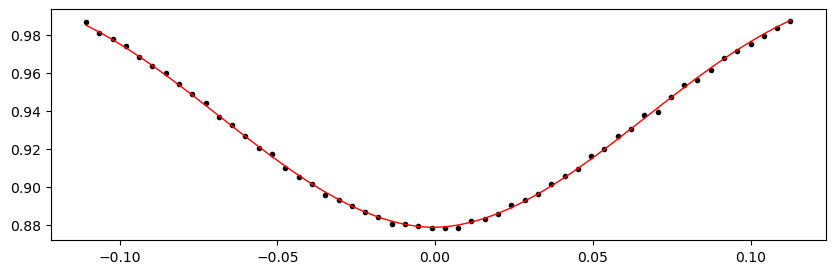

2872.433724 1.0069772642763068 -0.130011085474523 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 379.85it/s]


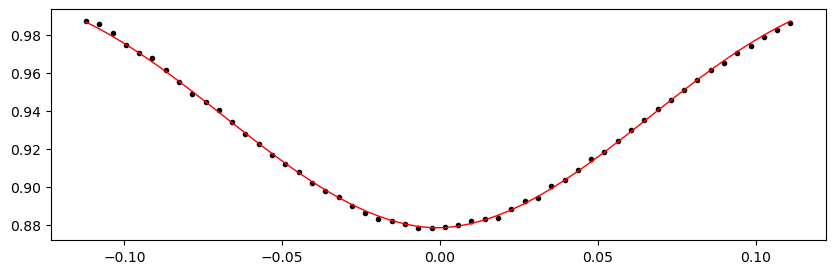

2872.7633974 1.0069772642763068 -0.130011085474523 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 404.06it/s]


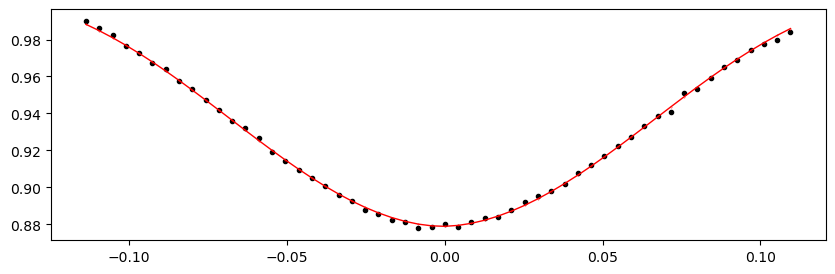

2873.0930708 1.0069772642763068 -0.130011085474523 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 406.26it/s]


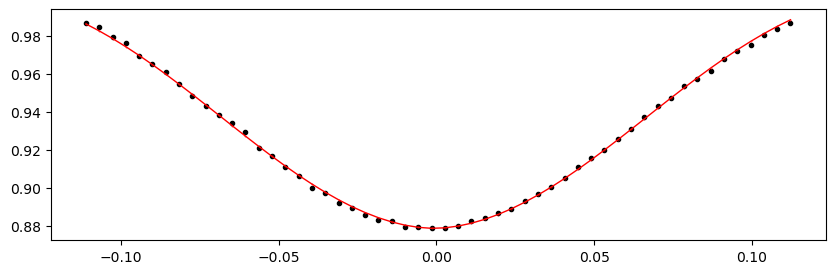

2873.4227442 1.0069772642763068 -0.130011085474523 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 404.31it/s]


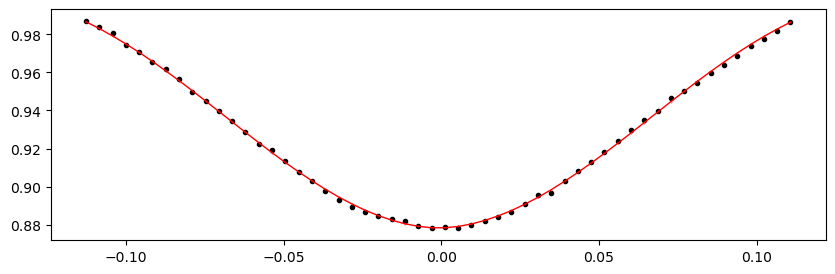

2873.7524175999997 1.0069772642763068 -0.130011085474523 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 401.92it/s]


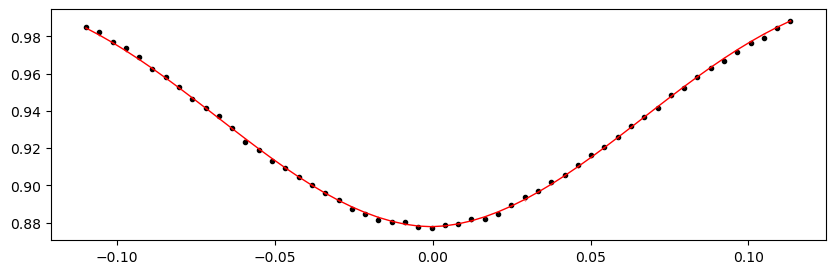

2874.082091 1.0069772642763068 -0.130011085474523 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 406.80it/s]


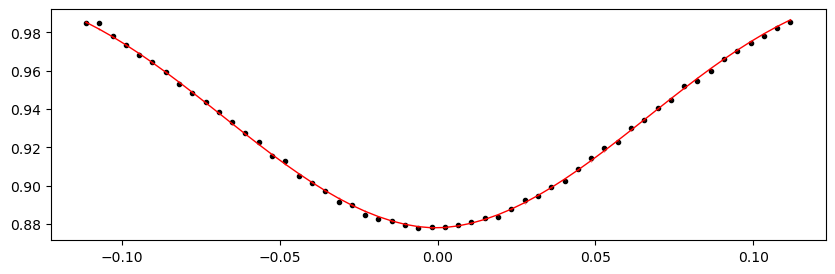

2874.4117644 1.0069772642763068 -0.130011085474523 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 405.90it/s]


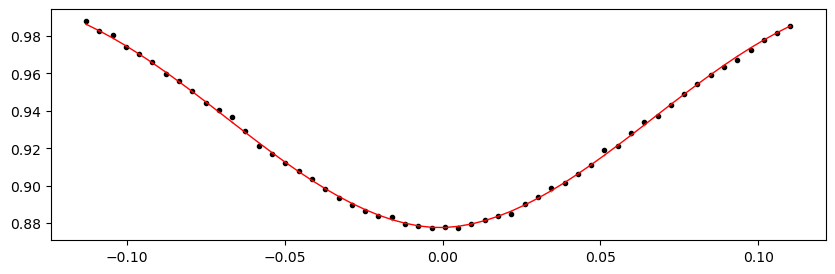

2875.0711112 1.0069772642763068 -0.130011085474523 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 379.03it/s]


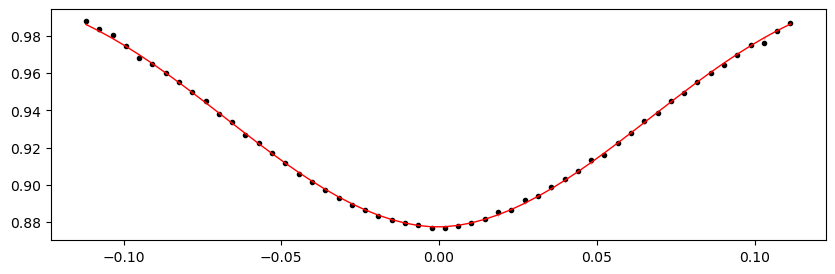

2875.4007846 1.0069772642763068 -0.130011085474523 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 359.59it/s]


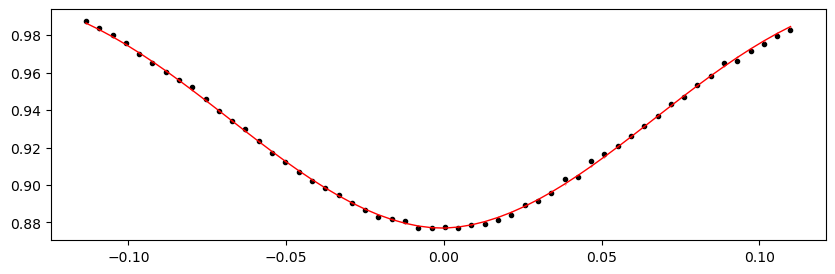

2875.730458 1.0069772642763068 -0.130011085474523 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 382.77it/s]


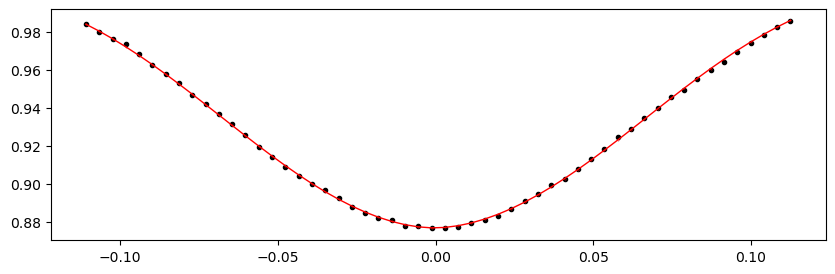

2876.0601314 1.0069772642763068 -0.130011085474523 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 394.52it/s]


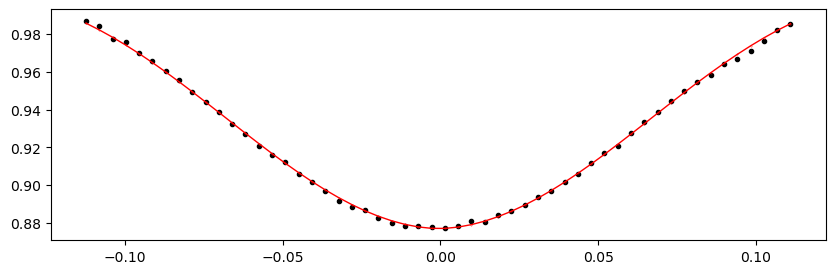

2876.3898048 1.0069772642763068 -0.130011085474523 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 393.80it/s]


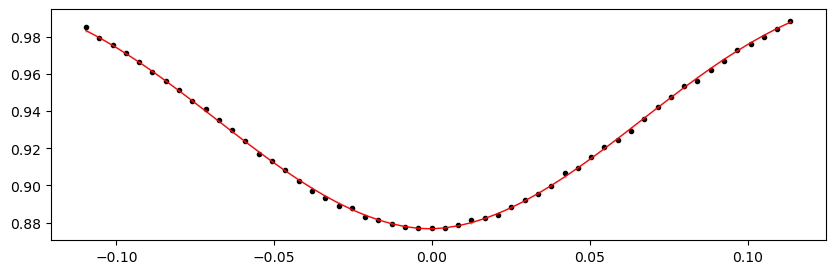

2876.7194781999997 1.0069772642763068 -0.130011085474523 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 389.41it/s]


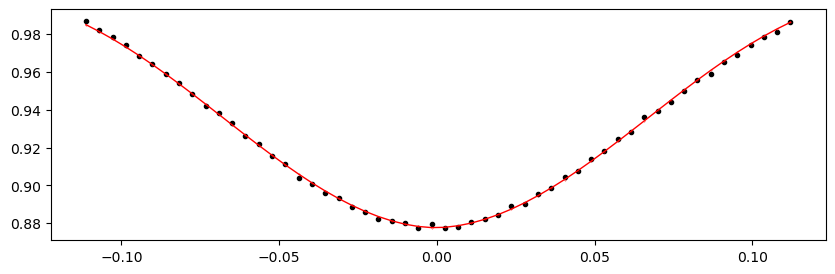

2877.0491516 1.0069772642763068 -0.130011085474523 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 375.15it/s]


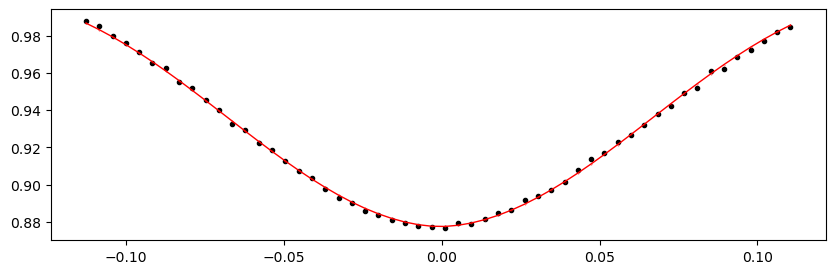

2877.378825 1.0069772642763068 -0.130011085474523 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 367.43it/s]


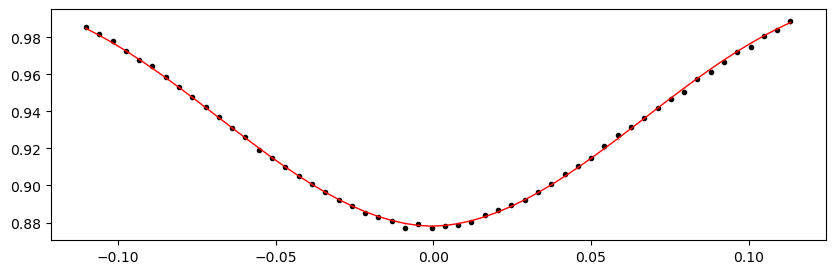

2877.7084984000003 1.0069772642763068 -0.130011085474523 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 379.47it/s]


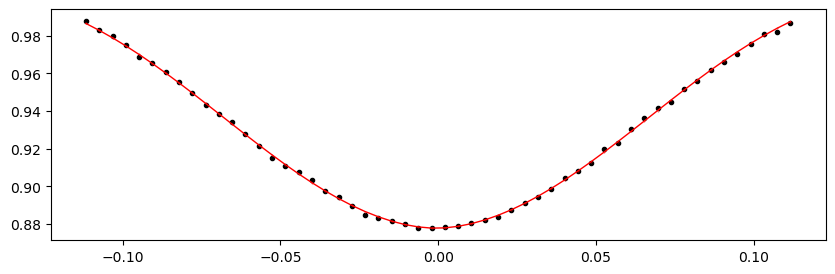

2878.0381718 1.0069772642763068 -0.130011085474523 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 388.14it/s]


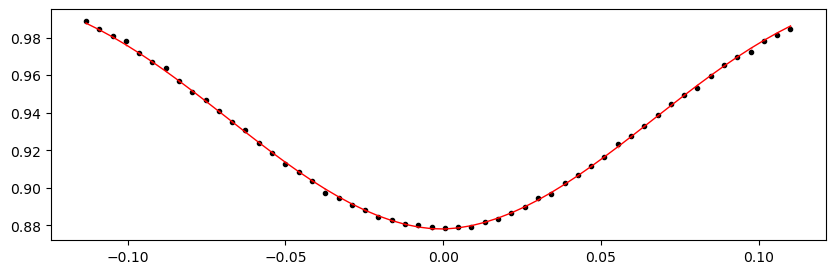

2878.3678452 1.0069772642763068 -0.130011085474523 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 404.03it/s]


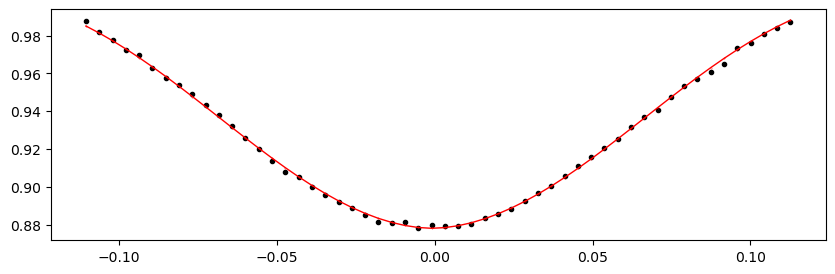

2878.6975186 1.0069772642763068 -0.130011085474523 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 403.50it/s]


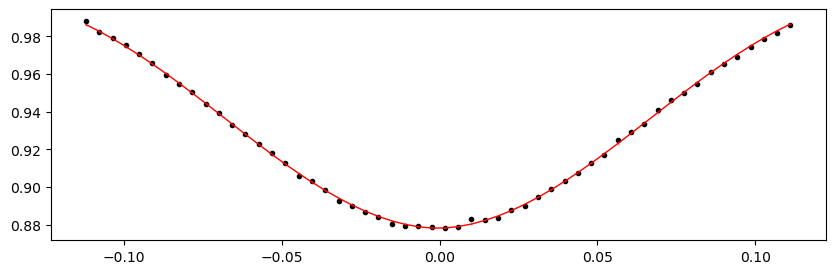

2879.027192 1.0069772642763068 -0.130011085474523 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 405.32it/s]


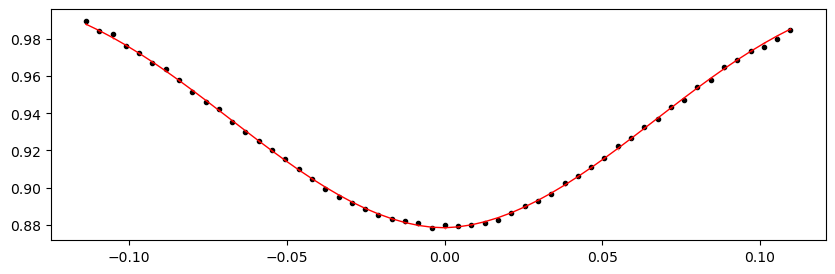

2879.3568654 1.0069772642763068 -0.130011085474523 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 398.84it/s]


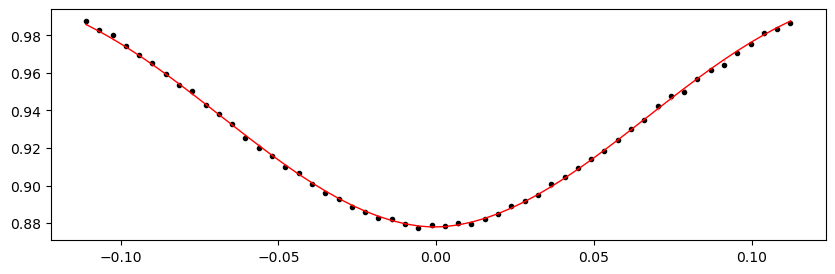

2879.6865387999997 1.0069772642763068 -0.130011085474523 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 401.61it/s]


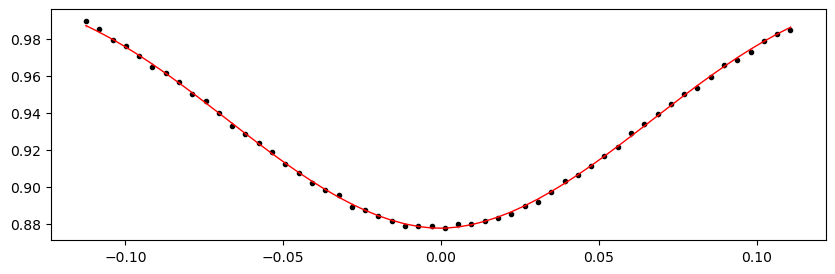

2880.0162122 1.0069772642763068 -0.130011085474523 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 400.45it/s]


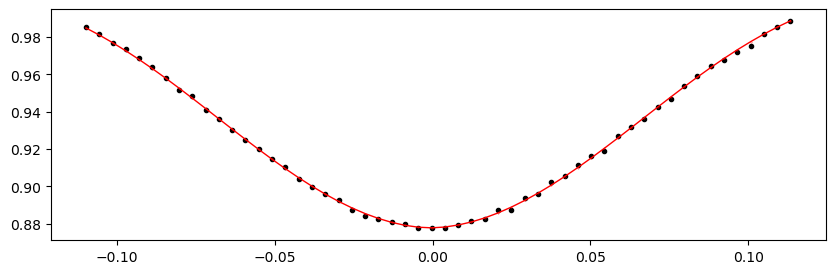

2880.3458855999997 1.0069772642763068 -0.130011085474523 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 402.50it/s]


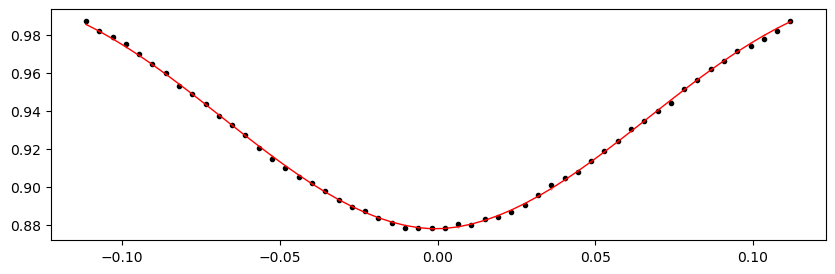

2880.6755590000002 1.0069772642763068 -0.130011085474523 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 405.55it/s]


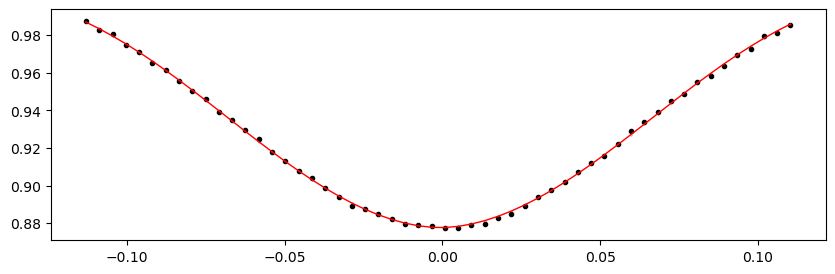

2881.0052324 1.0069772642763068 -0.130011085474523 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 402.77it/s]


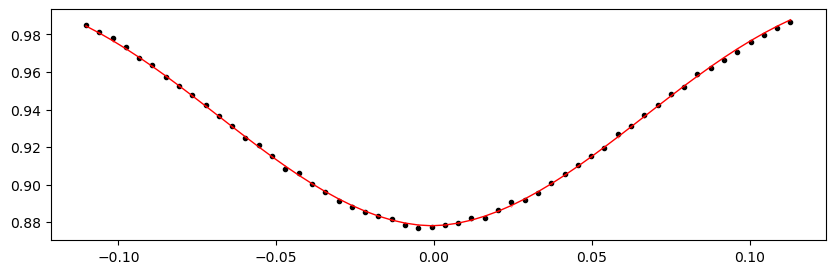

2881.3349058 1.0069772642763068 -0.130011085474523 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 402.85it/s]


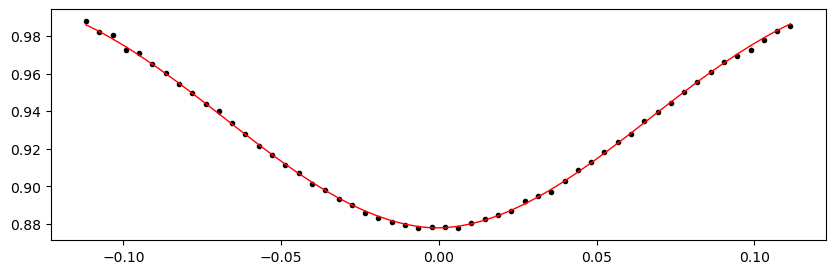

2881.6645792 1.0069772642763068 -0.130011085474523 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 384.15it/s]


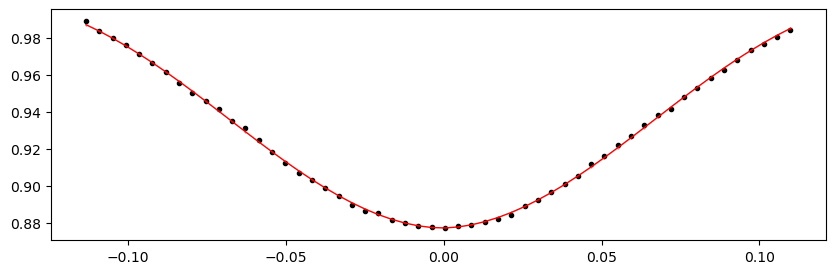

In [58]:
%matplotlib inline

from importlib import reload
reload(etv_functions)

print("Fitting individual primary eclipses...")
etv_functions.fit_each_eclipse(data_primary, n_transits, t0_primary, period, mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau, outfile_path,
                               min_number_data=20, 
                              )
!$NOTIFY_CMD "Individual primary eclipses fit done"

Fitting individual secondary eclipses...
Existing manifest file found, will skip previously processed LCs and append to end of manifest file
Number 0 has already been completed -- skip
1765.2256101 1.013081338351713 -0.11868709084275225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 365.62it/s]


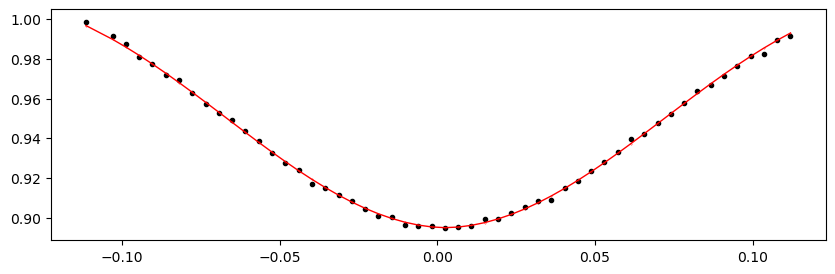

1765.5552835 1.013081338351713 -0.11868709084275225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 390.26it/s]


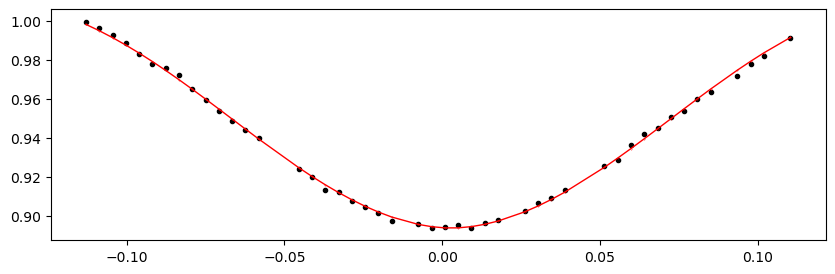

1765.8849569 1.013081338351713 -0.11868709084275225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 397.50it/s]


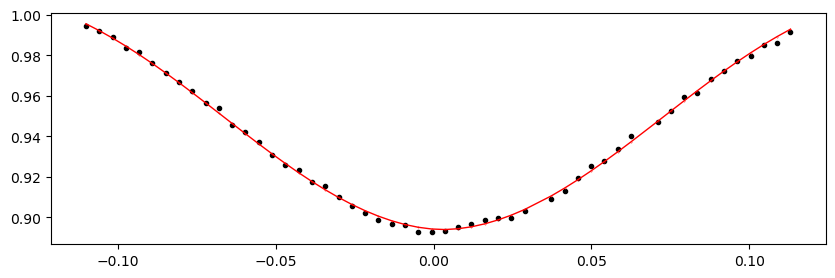

1766.2146303 1.013081338351713 -0.11868709084275225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 396.12it/s]


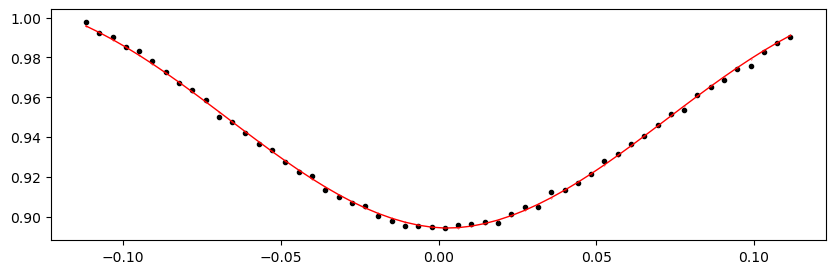

1766.5443037 1.013081338351713 -0.11868709084275225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 397.85it/s]


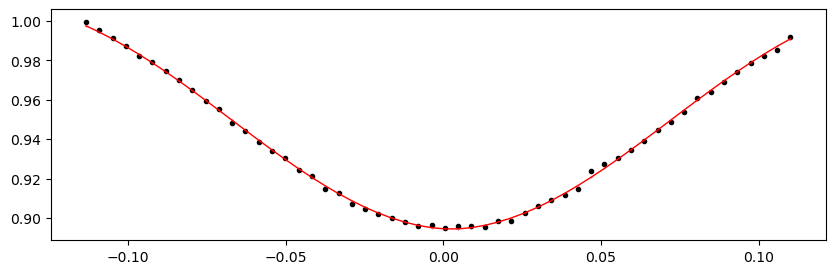

1766.8739771 1.013081338351713 -0.11868709084275225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 398.96it/s]


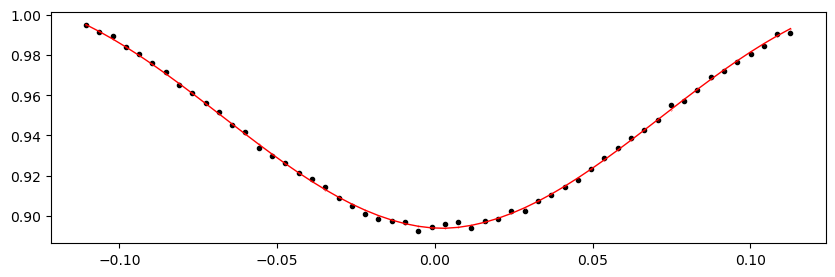

1767.2036505 1.013081338351713 -0.11868709084275225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 400.64it/s]


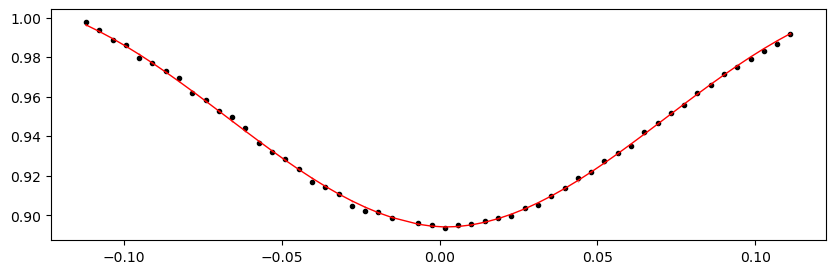

1767.5333239 1.013081338351713 -0.11868709084275225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 401.37it/s]


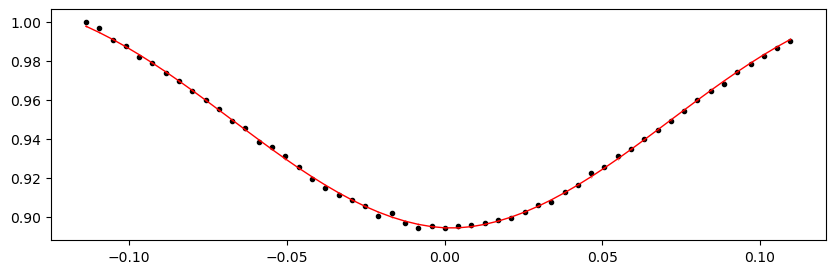

1767.8629973 1.013081338351713 -0.11868709084275225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 402.91it/s]


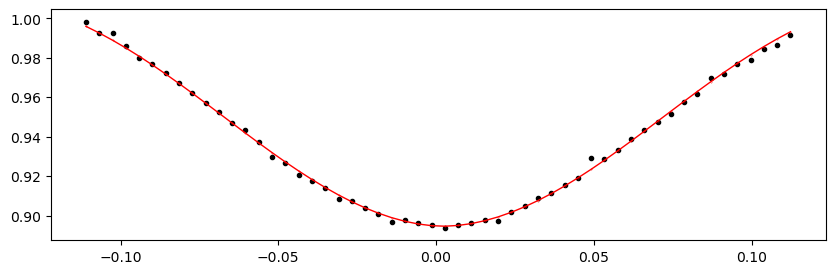

1768.1926707 1.013081338351713 -0.11868709084275225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 396.75it/s]


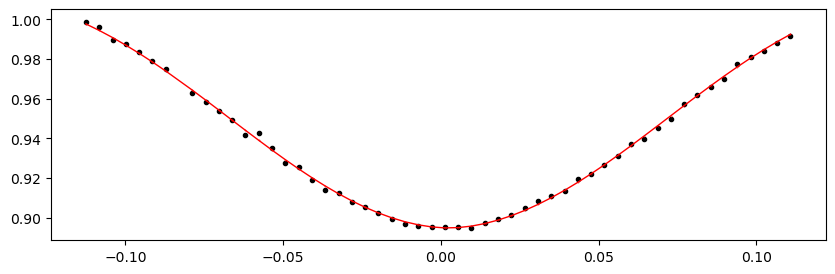

1768.5223441 1.013081338351713 -0.11868709084275225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 397.77it/s]


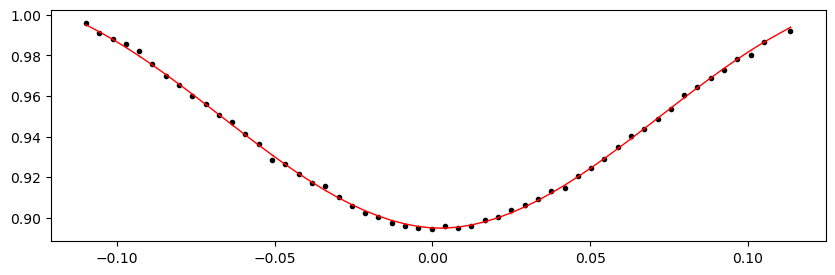

1768.8520175 1.013081338351713 -0.11868709084275225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 398.72it/s]


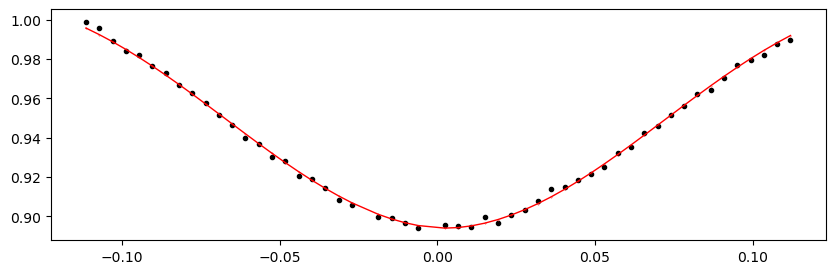

1769.1816909 1.013081338351713 -0.11868709084275225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 399.21it/s]


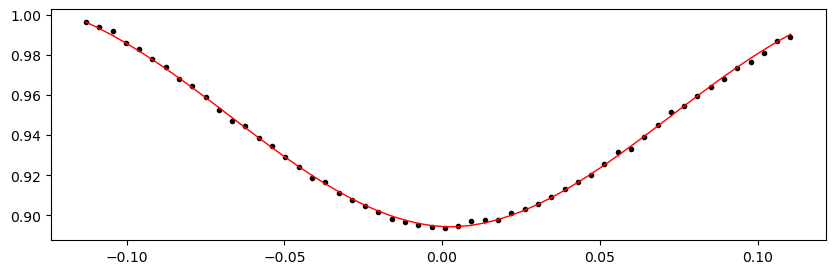

1769.5113643 1.013081338351713 -0.11868709084275225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 396.64it/s]


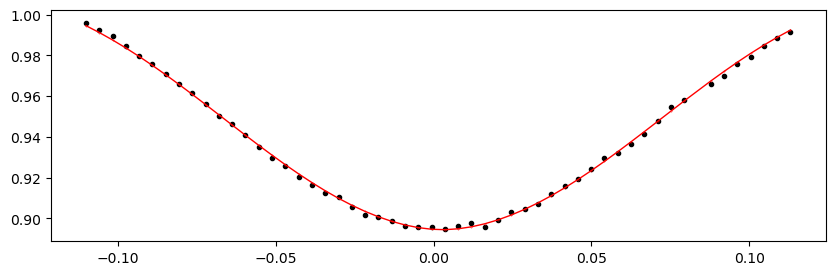

1769.8410377 1.013081338351713 -0.11868709084275225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 397.22it/s]


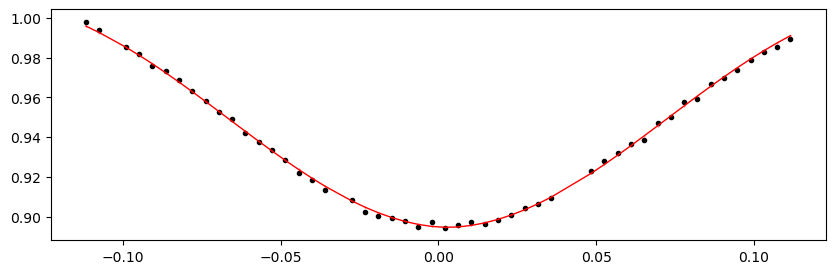

1770.1707111 1.013081338351713 -0.11868709084275225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 401.68it/s]


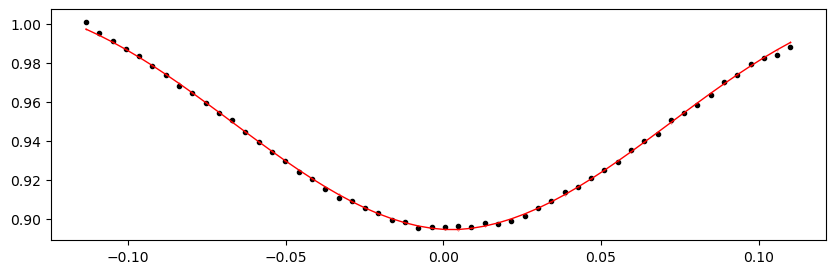

1770.5003844999999 1.013081338351713 -0.11868709084275225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 397.88it/s]


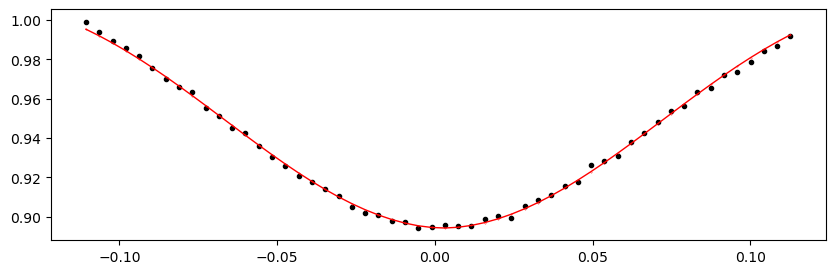

1770.8300579 1.013081338351713 -0.11868709084275225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 395.75it/s]


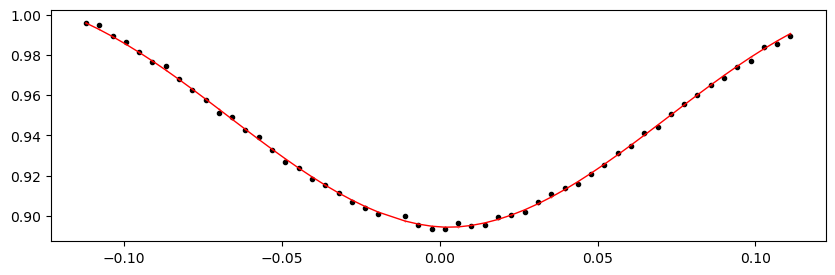

1771.1597313 1.013081338351713 -0.11868709084275225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 401.62it/s]


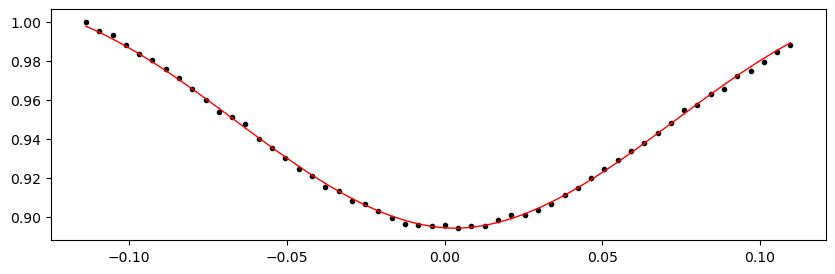

1771.4894047 1.013081338351713 -0.11868709084275225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 394.48it/s]


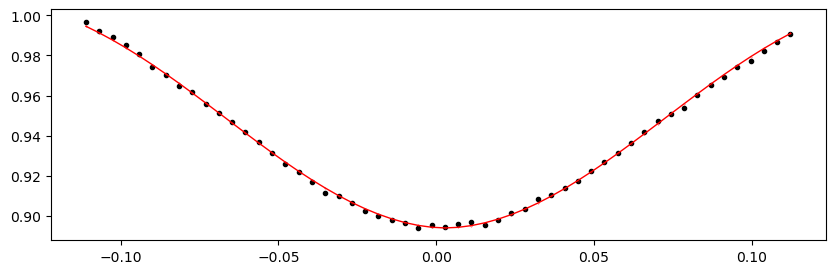

1771.8190781 1.013081338351713 -0.11868709084275225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 403.39it/s]


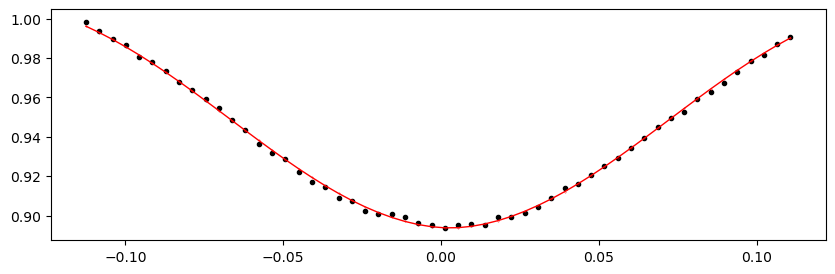

1772.1487515 1.013081338351713 -0.11868709084275225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 400.16it/s]


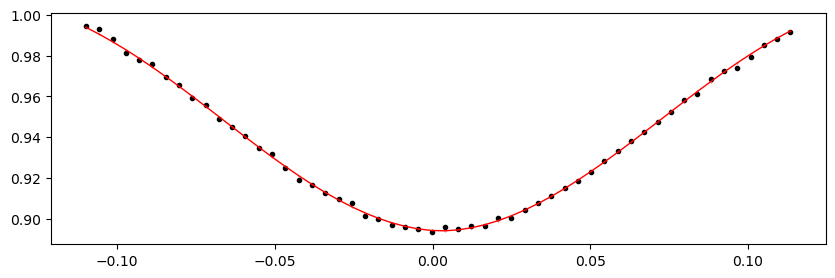

1772.4784249 1.013081338351713 -0.11868709084275225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 405.11it/s]


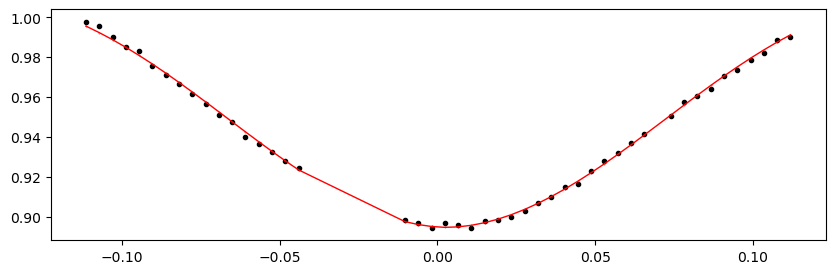

1772.8080983 1.013081338351713 -0.11868709084275225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 400.80it/s]


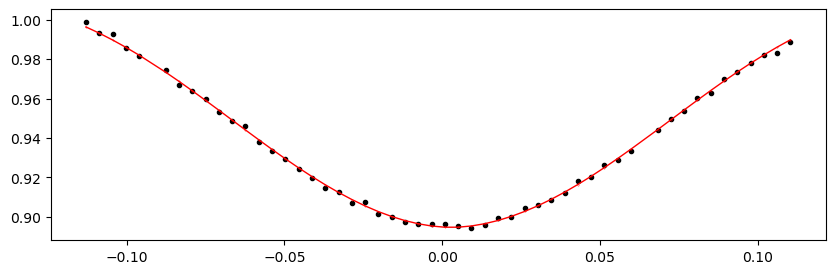

1777.7531993 1.013081338351713 -0.11868709084275225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 407.61it/s]


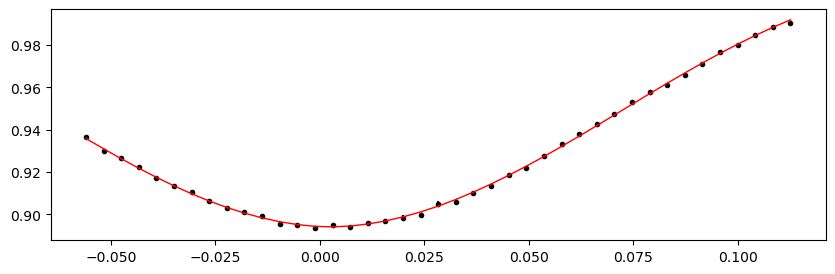

1778.0828727 1.013081338351713 -0.11868709084275225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 403.18it/s]


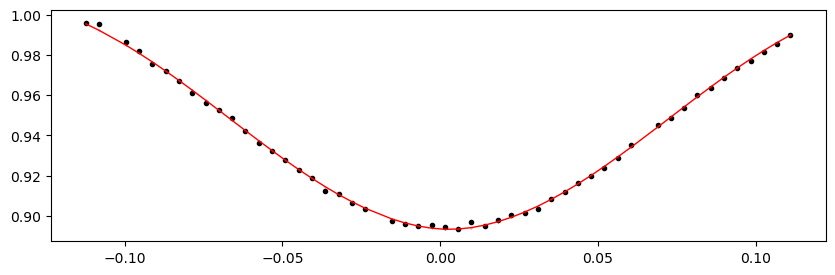

1778.4125461 1.013081338351713 -0.11868709084275225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 400.88it/s]


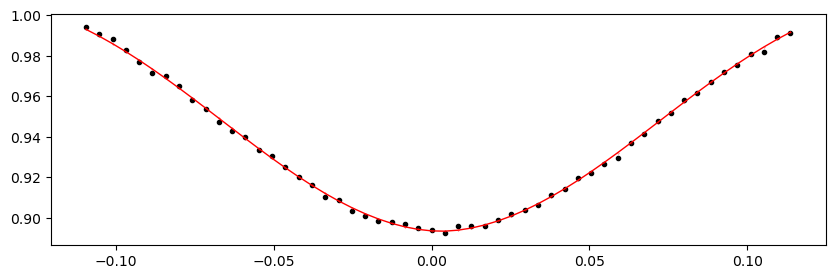

1778.7422195 1.013081338351713 -0.11868709084275225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 398.04it/s]


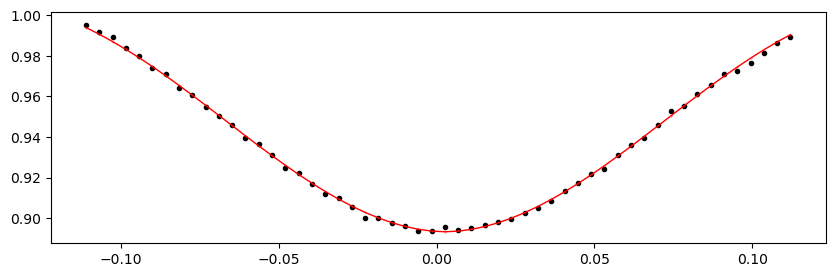

1779.0718929 1.013081338351713 -0.11868709084275225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 395.25it/s]


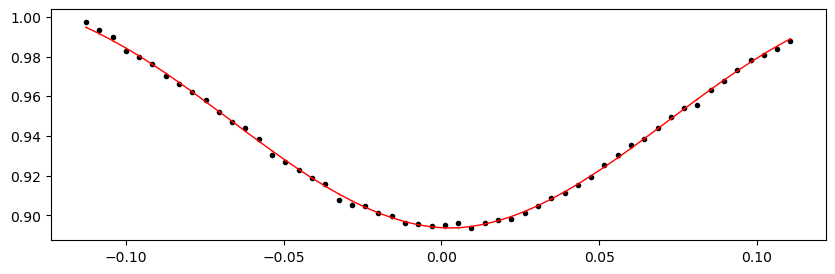

1779.4015663 1.013081338351713 -0.11868709084275225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 398.50it/s]


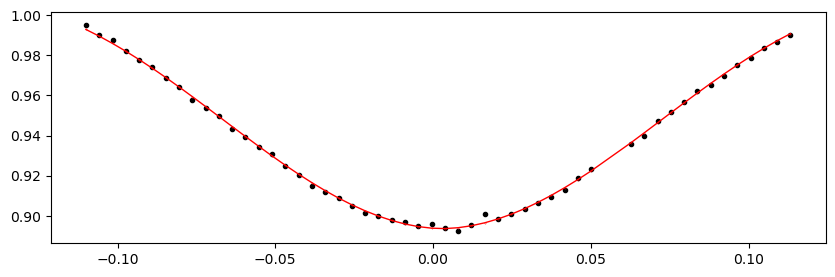

1779.7312397 1.013081338351713 -0.11868709084275225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 400.41it/s]


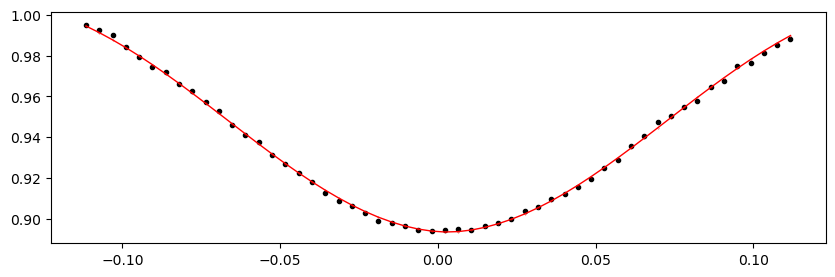

1780.0609131 1.013081338351713 -0.11868709084275225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 404.18it/s]


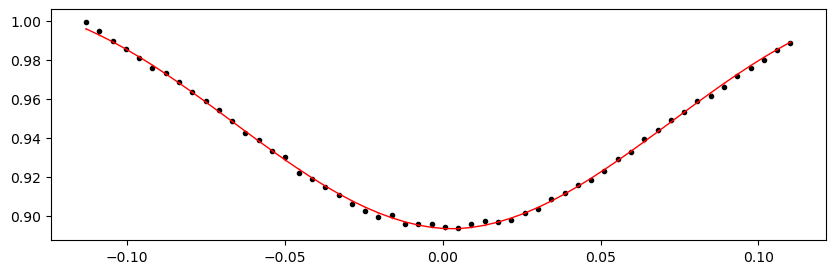

1780.3905865 1.013081338351713 -0.11868709084275225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 392.53it/s]


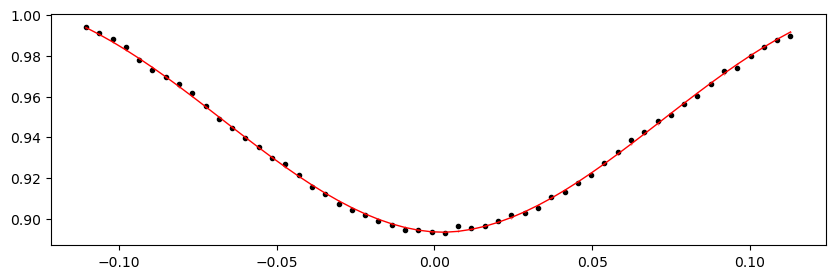

1780.7202599 1.013081338351713 -0.11868709084275225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 399.45it/s]


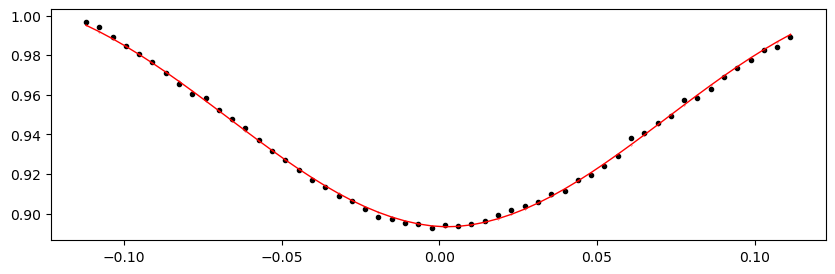

1781.0499333 1.013081338351713 -0.11868709084275225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 400.26it/s]


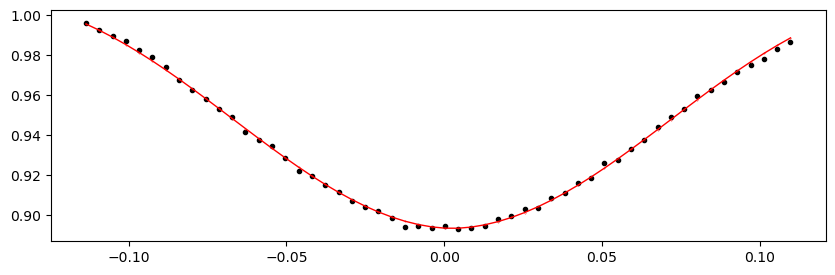

1781.3796067 1.013081338351713 -0.11868709084275225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 394.35it/s]


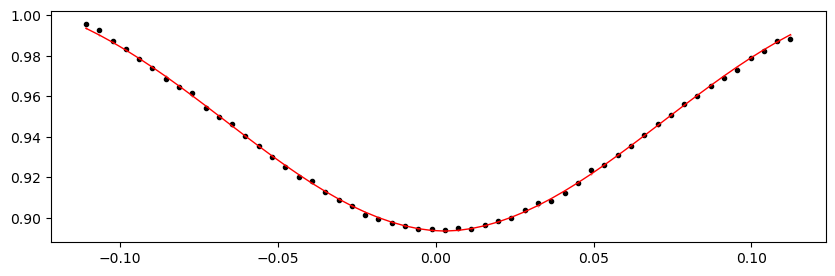

1781.7092801 1.013081338351713 -0.11868709084275225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 400.33it/s]


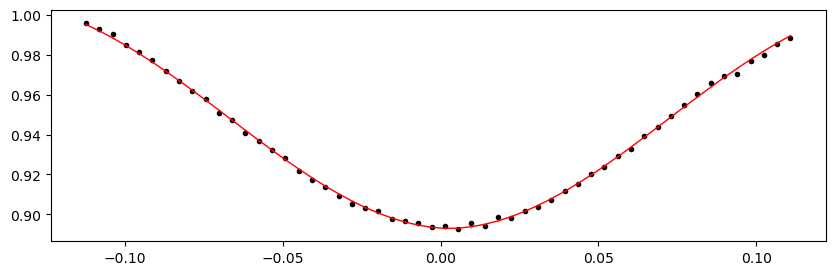

1782.0389535 1.013081338351713 -0.11868709084275225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 402.96it/s]


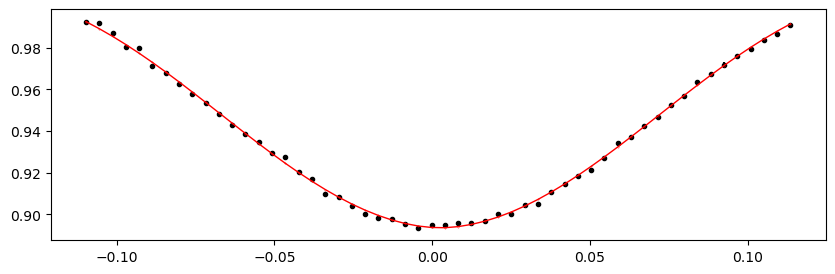

1782.3686269 1.013081338351713 -0.11868709084275225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 399.53it/s]


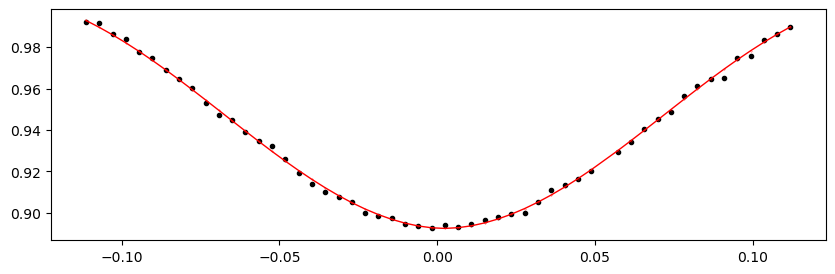

1782.6983003 1.013081338351713 -0.11868709084275225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 396.93it/s]


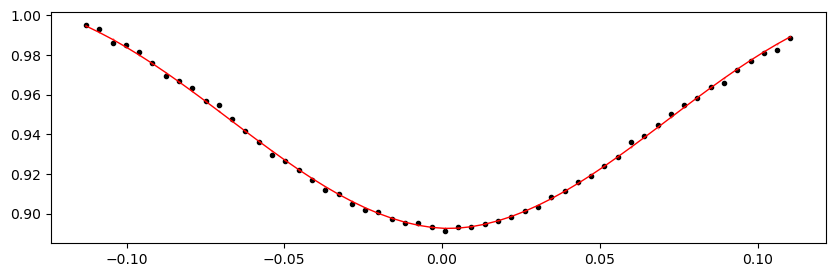

1783.0279737 1.013081338351713 -0.11868709084275225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 400.56it/s]


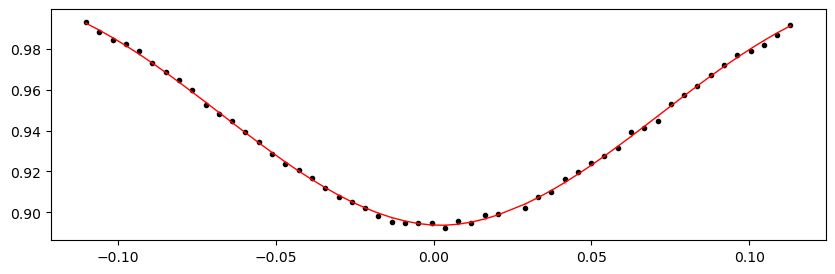

1783.3576471 1.013081338351713 -0.11868709084275225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 401.25it/s]


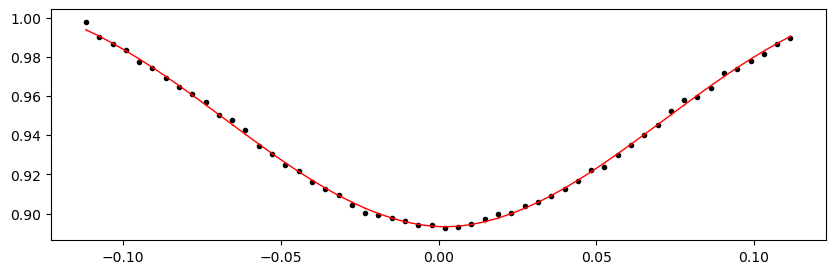

1783.6873205 1.013081338351713 -0.11868709084275225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 402.91it/s]


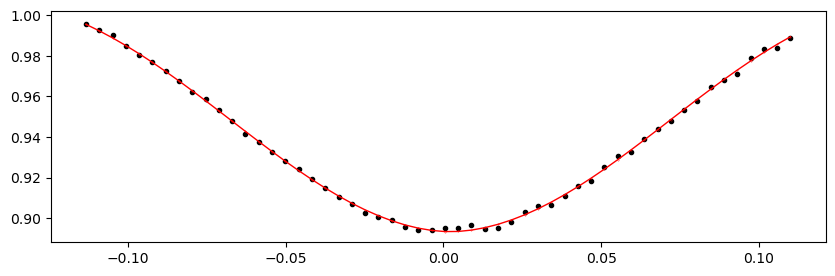

1784.0169939 1.013081338351713 -0.11868709084275225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 403.33it/s]


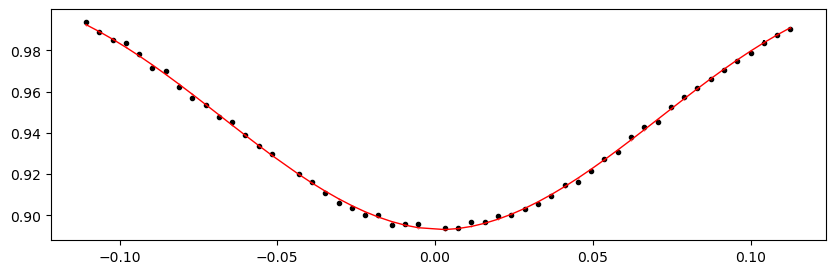

1784.3466673 1.013081338351713 -0.11868709084275225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 401.34it/s]


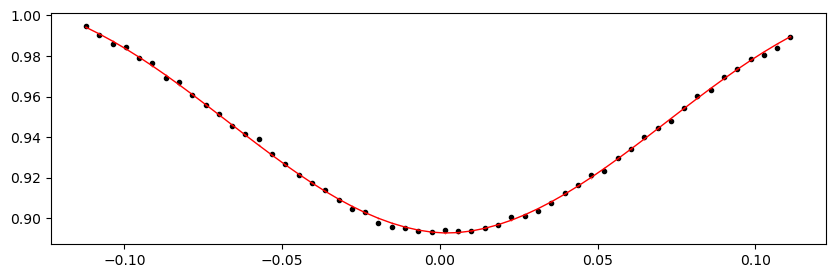

1784.6763407 1.013081338351713 -0.11868709084275225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 403.30it/s]


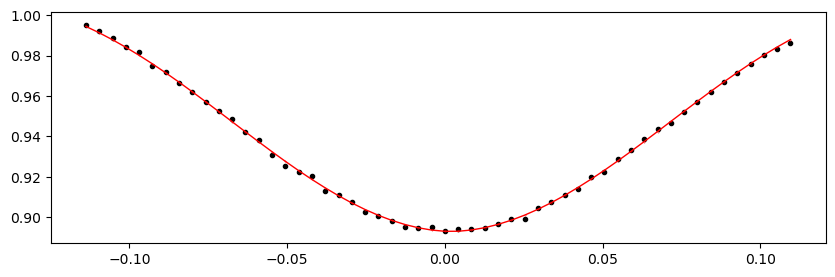

1785.0060141 1.013081338351713 -0.11868709084275225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 394.11it/s]


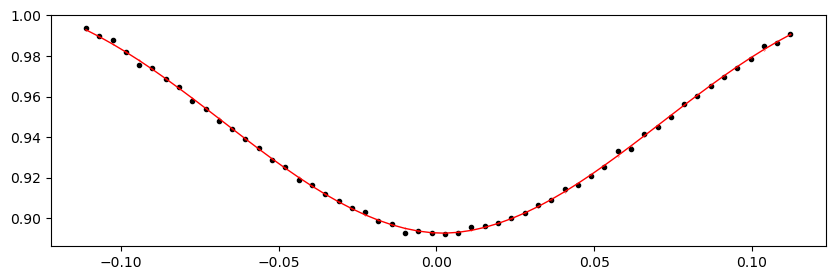

1785.3356875 1.013081338351713 -0.11868709084275225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 399.89it/s]


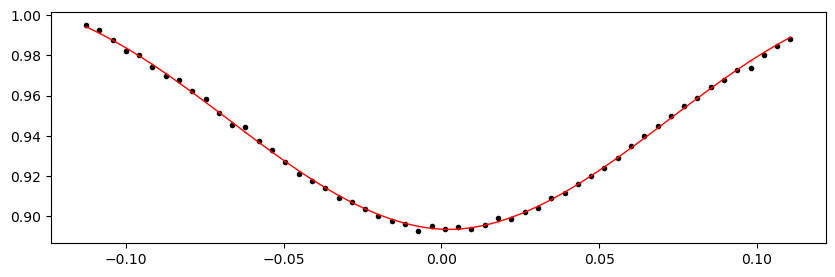

1785.6653609 1.013081338351713 -0.11868709084275225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 400.29it/s]


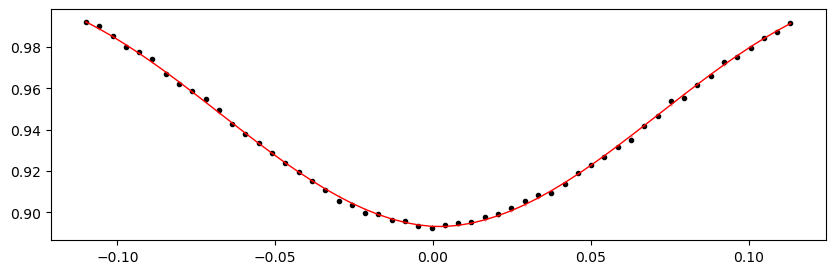

1785.9950343 1.013081338351713 -0.11868709084275225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 398.52it/s]


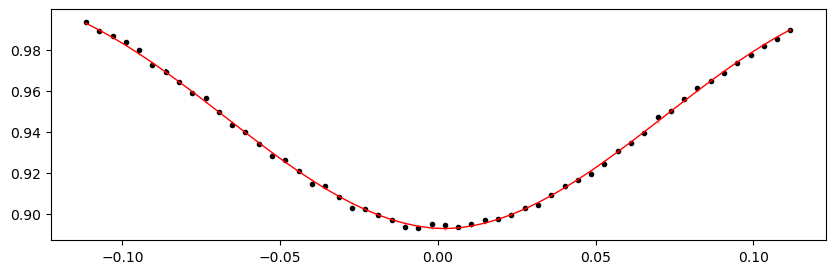

1786.3247077 1.013081338351713 -0.11868709084275225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 400.93it/s]


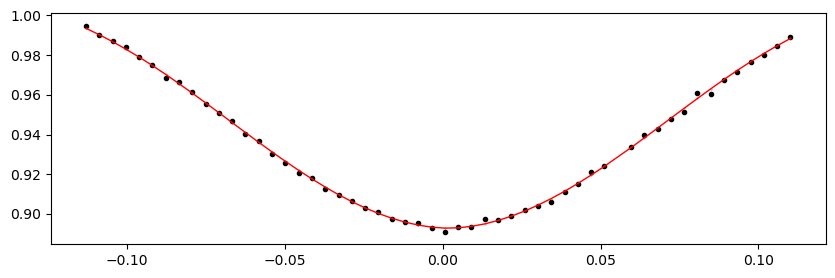

1786.6543811 1.013081338351713 -0.11868709084275225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 390.58it/s]


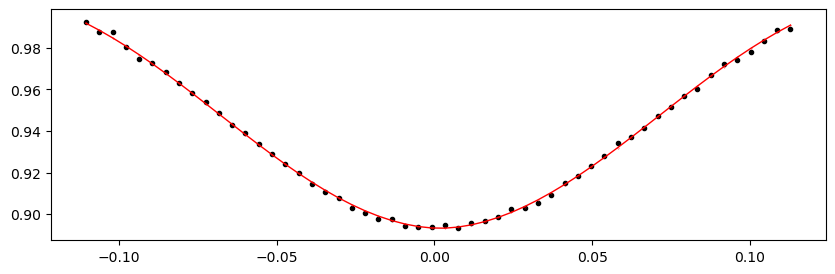

1786.9840545 1.013081338351713 -0.11868709084275225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 407.28it/s]


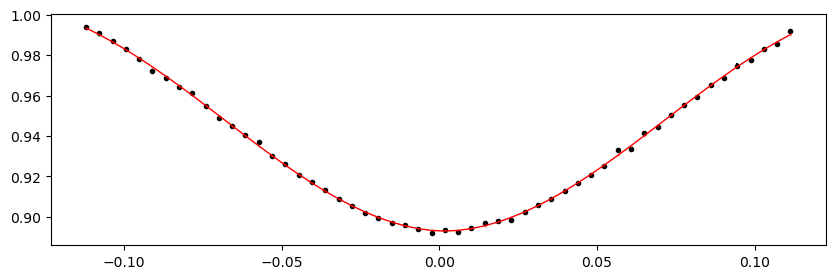

1787.3137279 1.013081338351713 -0.11868709084275225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 399.32it/s]


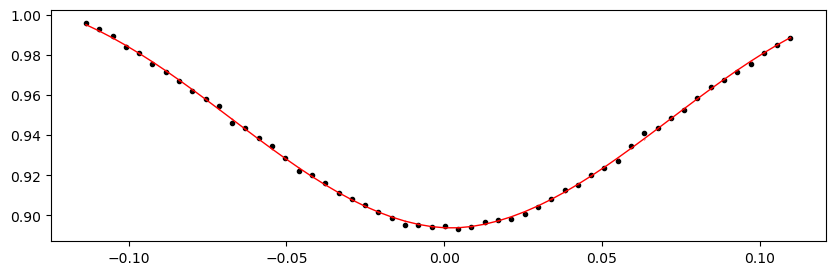

1787.6434013 1.013081338351713 -0.11868709084275225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 403.67it/s]


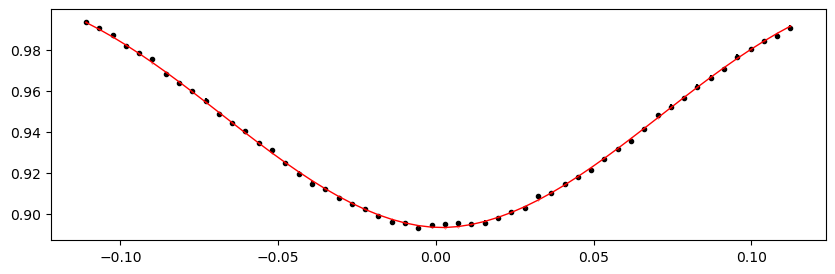

1787.9730747 1.013081338351713 -0.11868709084275225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 424.34it/s]


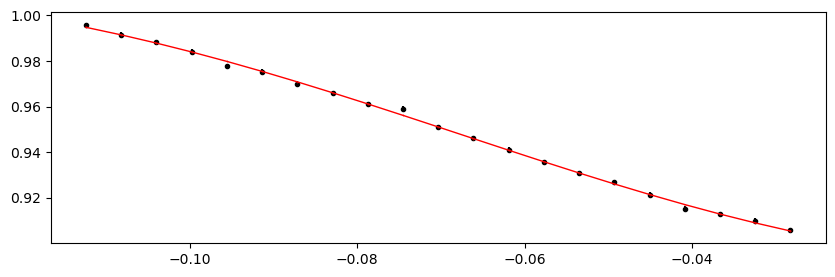

2853.4775035000002 1.013081338351713 -0.11868709084275225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 402.50it/s]


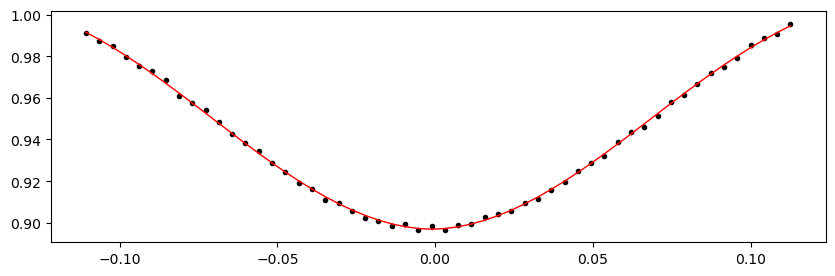

2853.8071769 1.013081338351713 -0.11868709084275225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 405.32it/s]


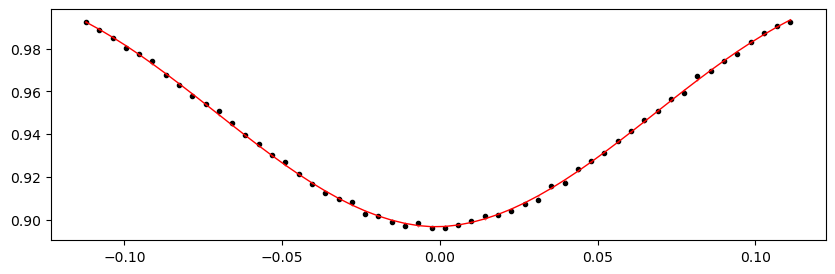

2854.1368503000003 1.013081338351713 -0.11868709084275225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 405.76it/s]


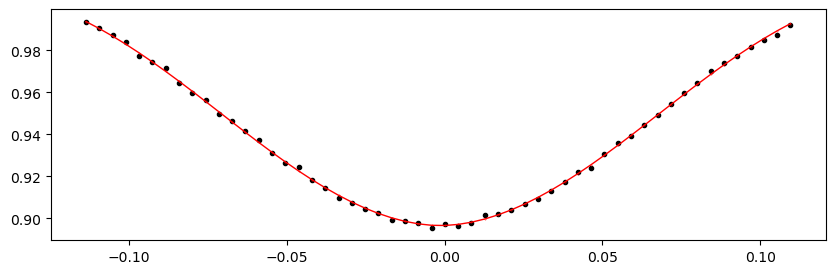

2854.4665237 1.013081338351713 -0.11868709084275225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 405.03it/s]


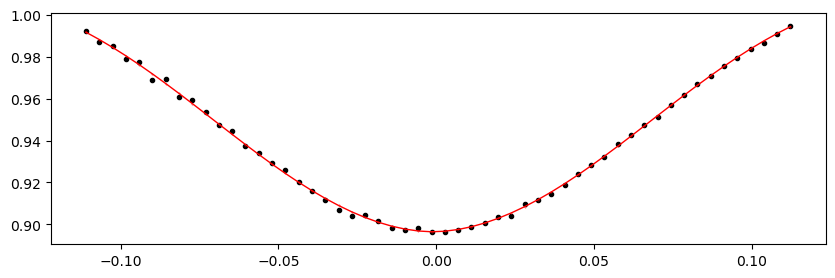

2854.7961971 1.013081338351713 -0.11868709084275225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 402.00it/s]


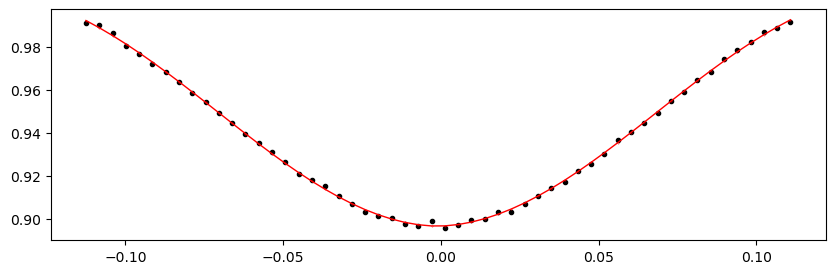

2855.1258705 1.013081338351713 -0.11868709084275225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 404.39it/s]


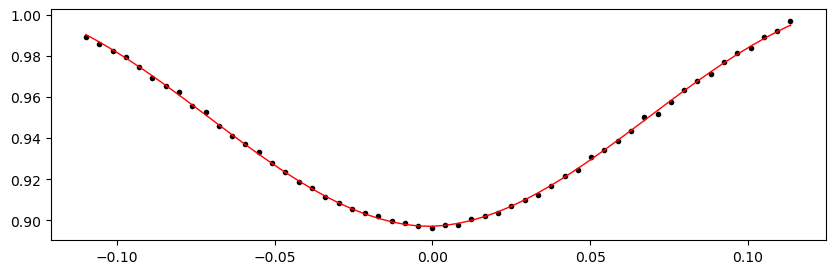

2855.4555439 1.013081338351713 -0.11868709084275225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 403.42it/s]


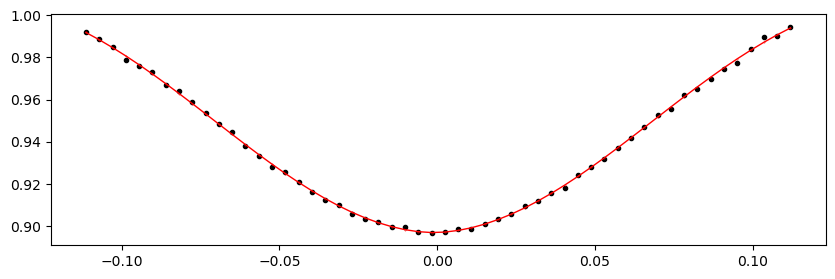

2855.7852173 1.013081338351713 -0.11868709084275225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 410.11it/s]


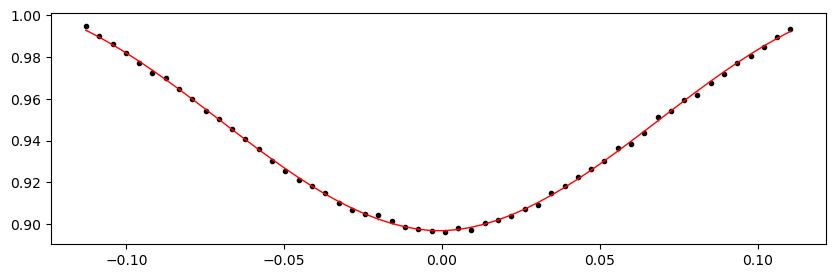

2856.1148906999997 1.013081338351713 -0.11868709084275225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 411.16it/s]


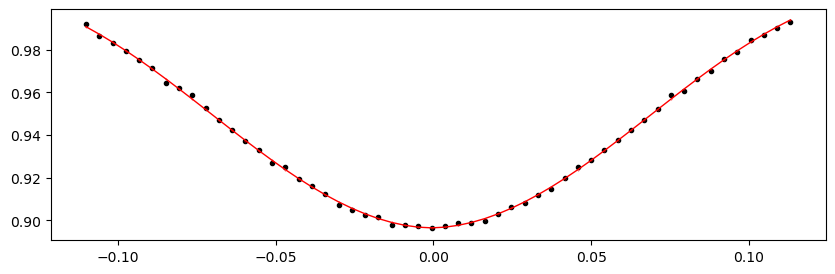

2856.4445641 1.013081338351713 -0.11868709084275225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 412.33it/s]


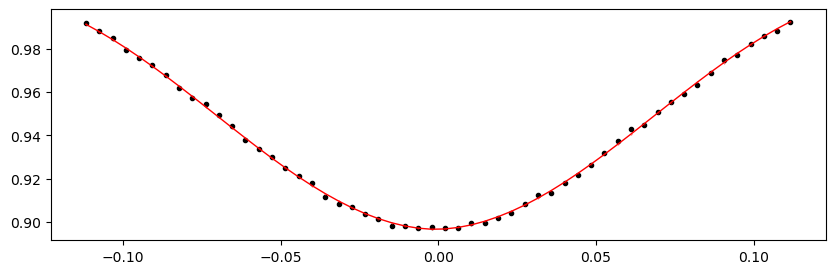

2856.7742375 1.013081338351713 -0.11868709084275225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 415.60it/s]


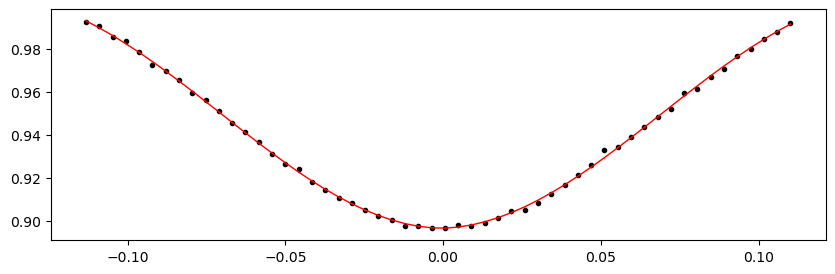

2857.1039109000003 1.013081338351713 -0.11868709084275225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 414.84it/s]


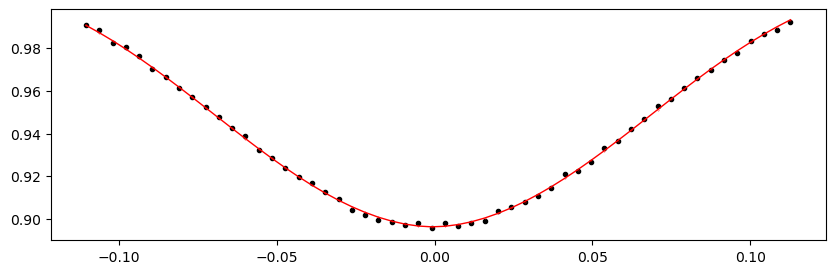

2857.4335843 1.013081338351713 -0.11868709084275225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 411.58it/s]


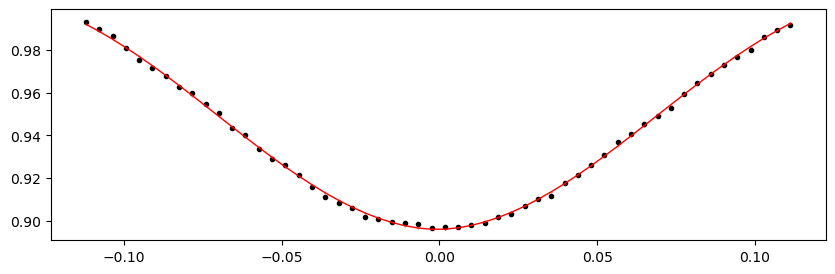

2857.7632577 1.013081338351713 -0.11868709084275225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 413.12it/s]


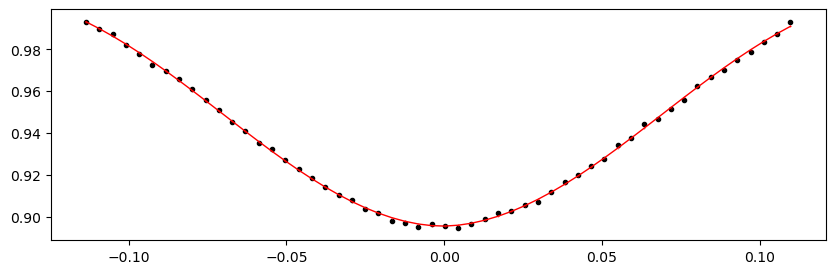

2858.0929311 1.013081338351713 -0.11868709084275225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:34<00:00, 290.28it/s]


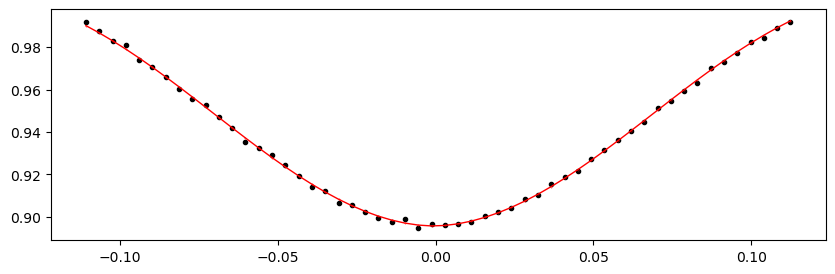

2858.4226045 1.013081338351713 -0.11868709084275225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 398.28it/s]


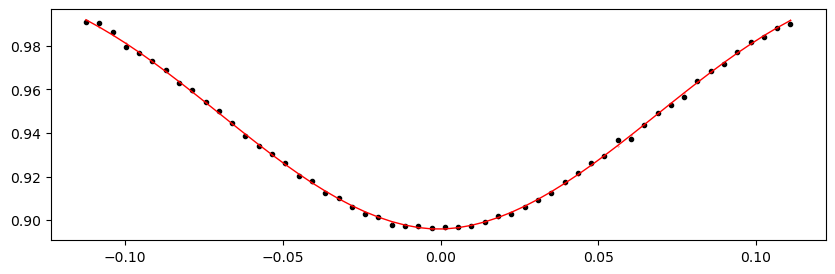

2858.7522779 1.013081338351713 -0.11868709084275225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 407.92it/s]


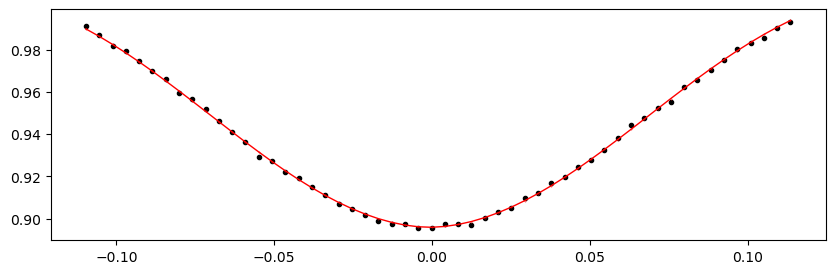

2859.0819512999997 1.013081338351713 -0.11868709084275225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 407.37it/s]


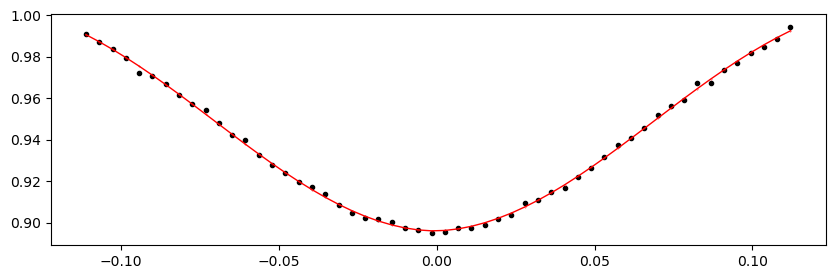

2859.4116247 1.013081338351713 -0.11868709084275225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 406.84it/s]


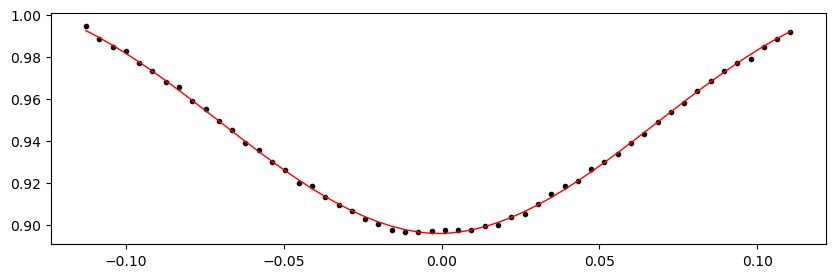

2859.7412980999998 1.013081338351713 -0.11868709084275225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 408.63it/s]


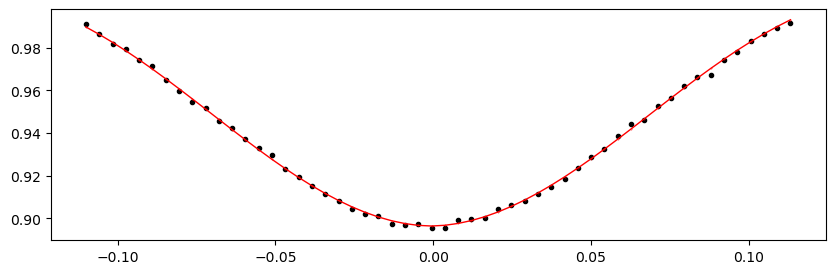

2860.0709715000003 1.013081338351713 -0.11868709084275225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 407.89it/s]


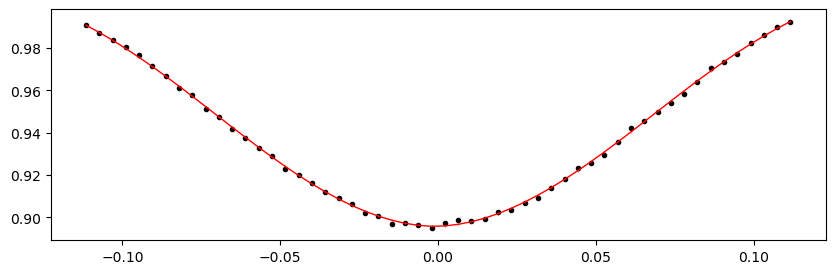

2860.4006449 1.013081338351713 -0.11868709084275225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 406.63it/s]


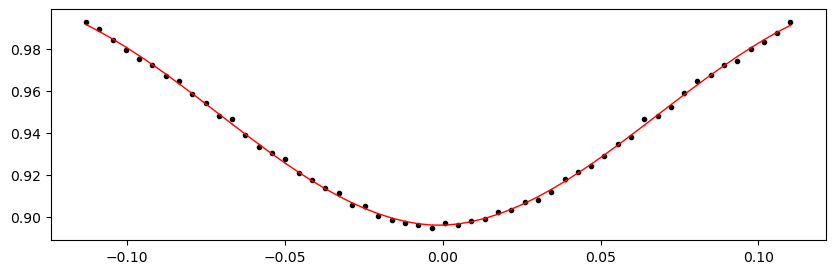

2861.0599917 1.013081338351713 -0.11868709084275225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 402.87it/s]


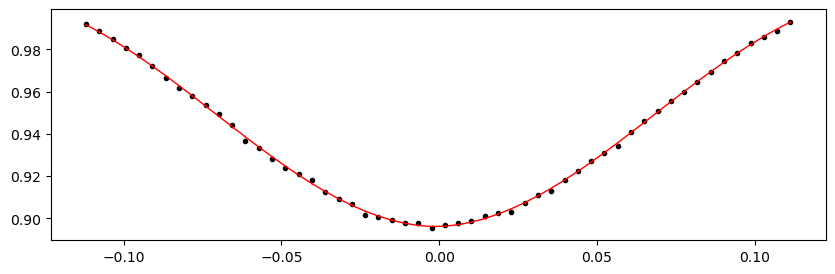

2861.3896651 1.013081338351713 -0.11868709084275225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 408.94it/s]


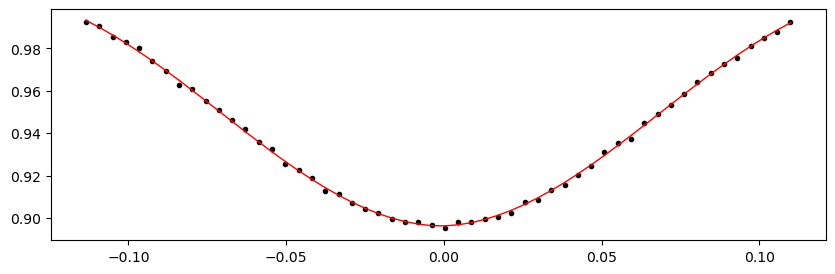

2861.7193385 1.013081338351713 -0.11868709084275225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 406.88it/s]


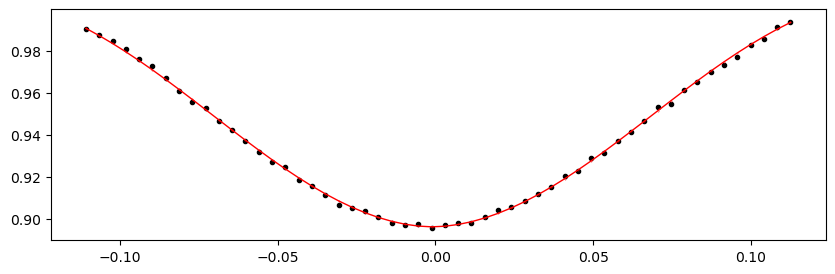

2862.0490119 1.013081338351713 -0.11868709084275225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 405.32it/s]


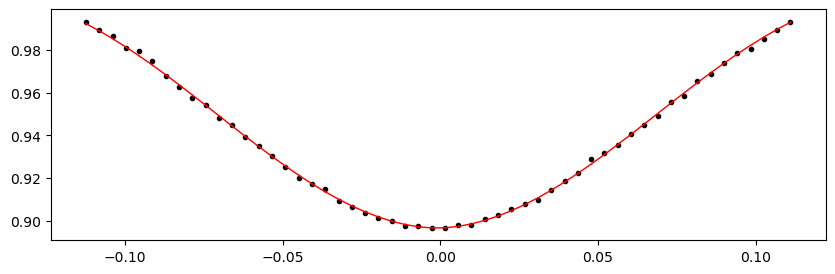

2862.3786853 1.013081338351713 -0.11868709084275225 0


100%|██████████████████████████████████████████████████████| 10000/10000 [6:11:59<00:00,  2.23s/it]


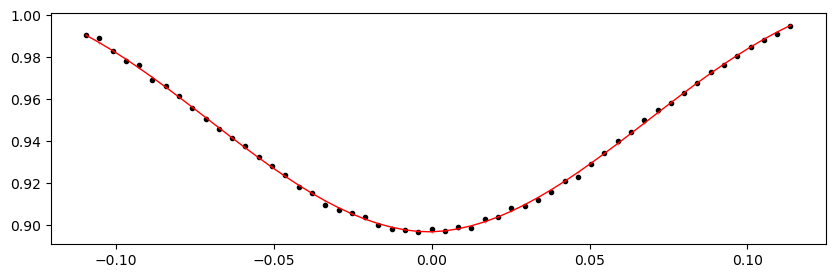

2862.7083586999997 1.013081338351713 -0.11868709084275225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 373.90it/s]


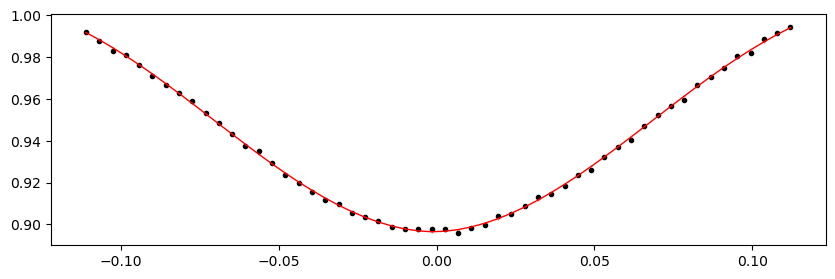

2863.0380321000002 1.013081338351713 -0.11868709084275225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 371.27it/s]


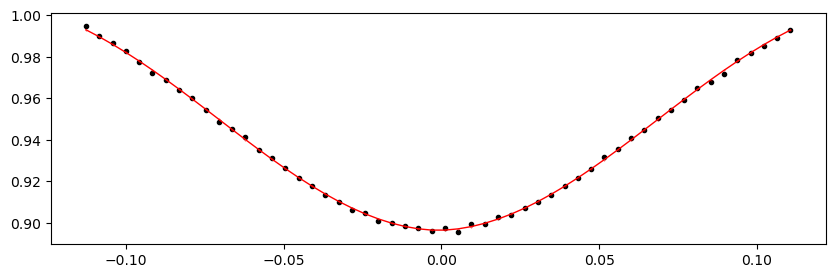

2866.6644395000003 1.013081338351713 -0.11868709084275225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 404.54it/s]


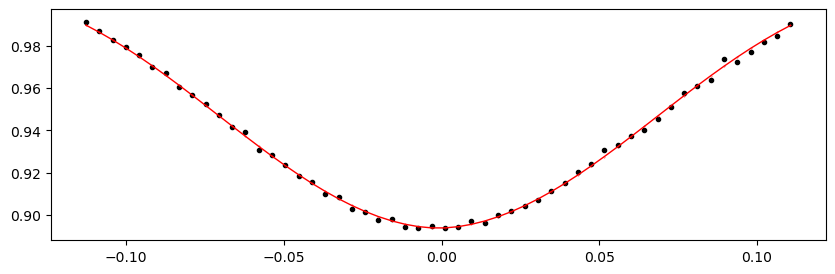

2866.9941129 1.013081338351713 -0.11868709084275225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 409.08it/s]


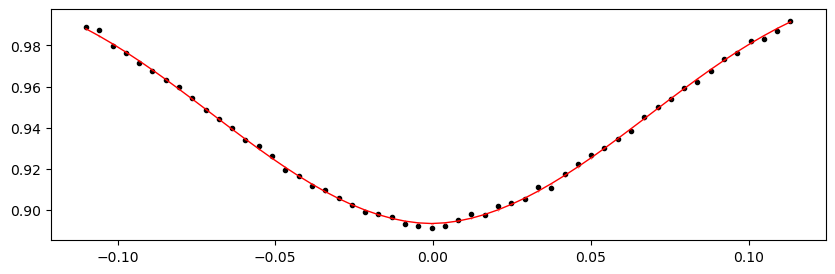

2867.6534597 1.013081338351713 -0.11868709084275225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 400.56it/s]


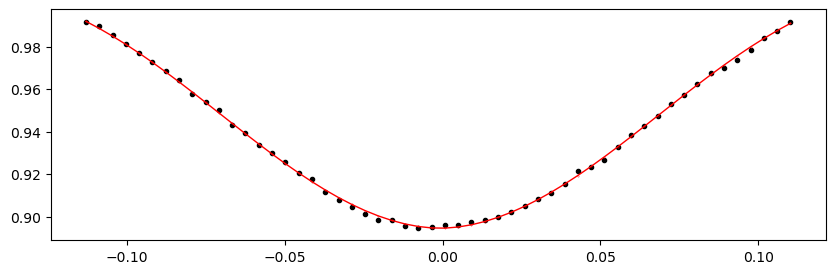

2867.9831331 1.013081338351713 -0.11868709084275225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 403.82it/s]


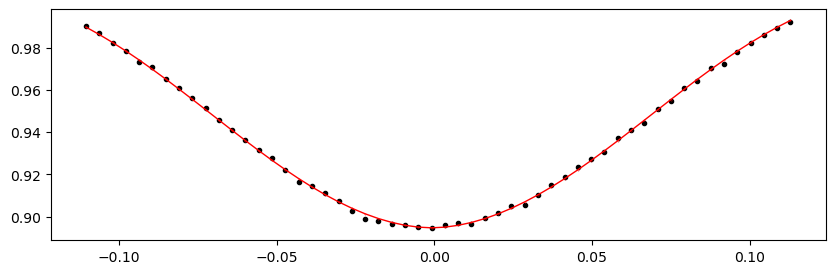

2868.3128065 1.013081338351713 -0.11868709084275225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 405.87it/s]


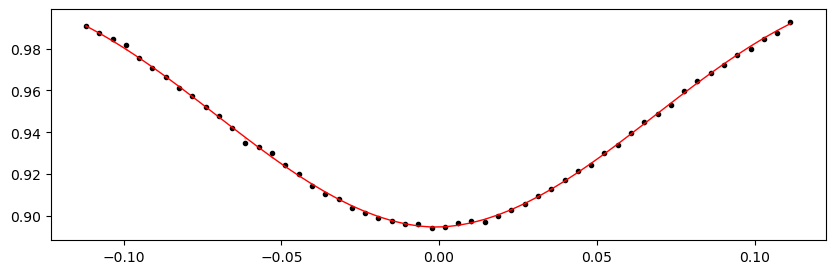

2868.6424798999997 1.013081338351713 -0.11868709084275225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 404.84it/s]


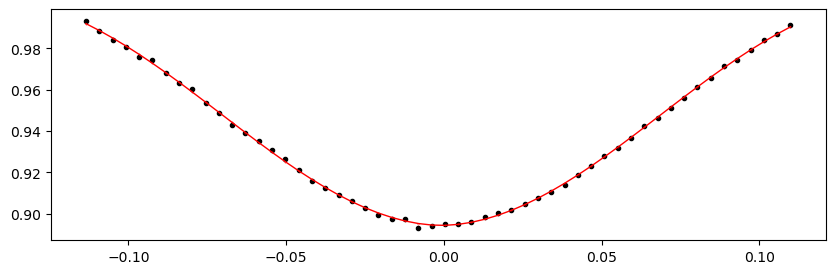

2868.9721533 1.013081338351713 -0.11868709084275225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 400.68it/s]


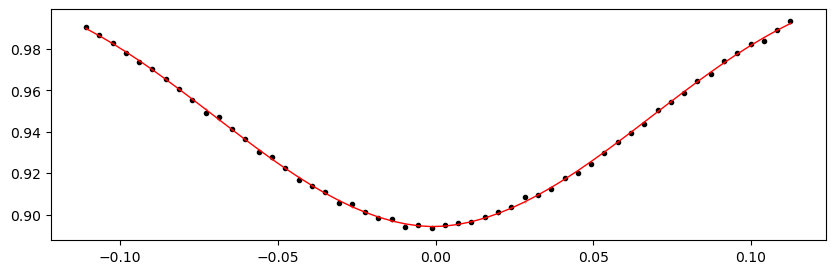

2869.3018266999998 1.013081338351713 -0.11868709084275225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 402.06it/s]


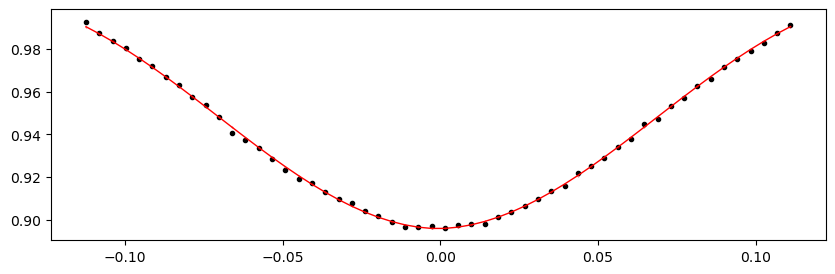

2869.6315001000003 1.013081338351713 -0.11868709084275225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 403.31it/s]


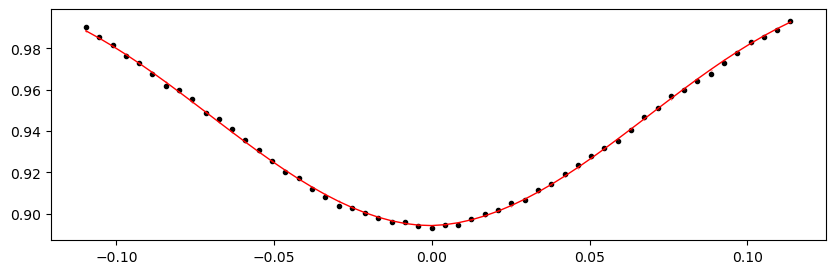

2869.9611735 1.013081338351713 -0.11868709084275225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 393.96it/s]


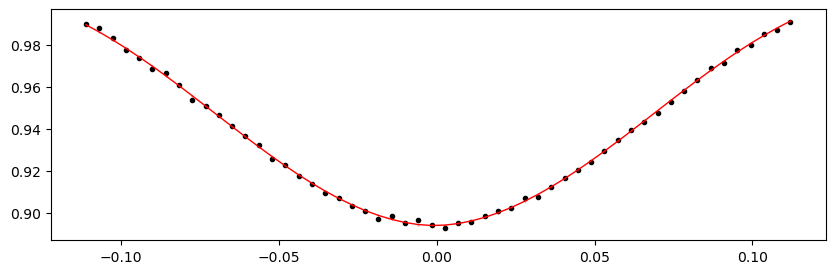

2870.2908469 1.013081338351713 -0.11868709084275225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 378.58it/s]


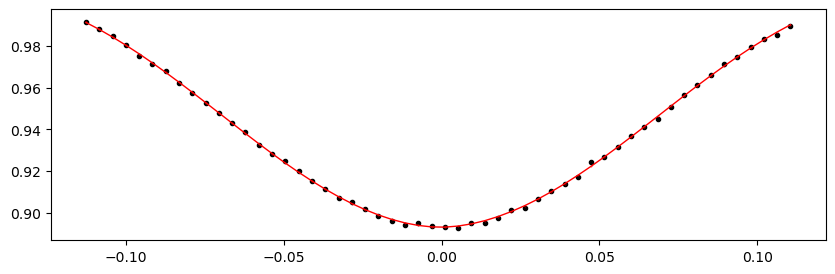

2870.6205203 1.013081338351713 -0.11868709084275225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 328.57it/s]


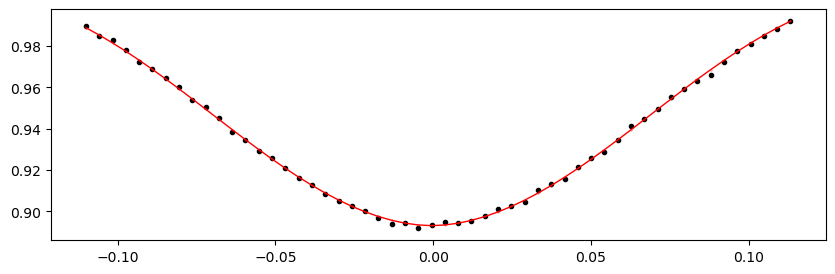

2870.9501937 1.013081338351713 -0.11868709084275225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 394.09it/s]


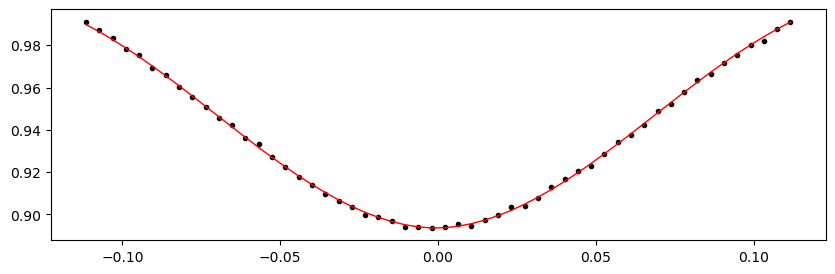

2871.2798671 1.013081338351713 -0.11868709084275225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 399.98it/s]


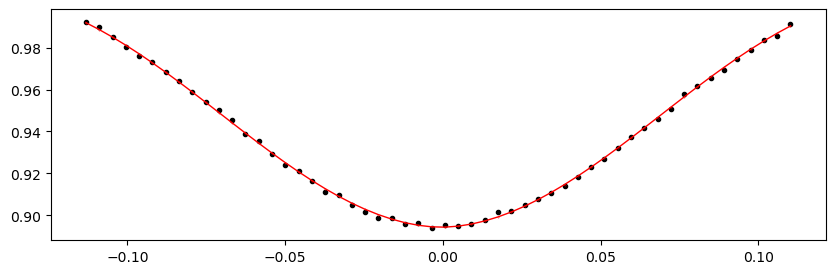

2871.6095405 1.013081338351713 -0.11868709084275225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 401.99it/s]


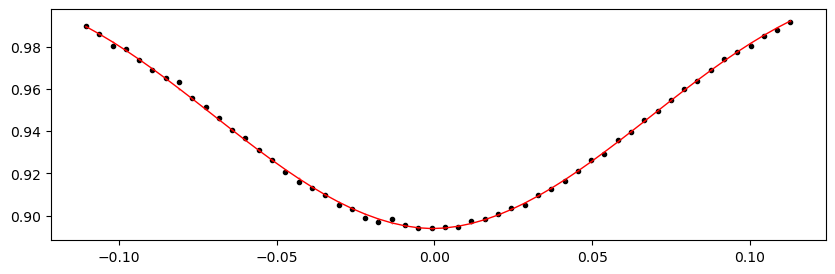

2871.9392139 1.013081338351713 -0.11868709084275225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 392.57it/s]


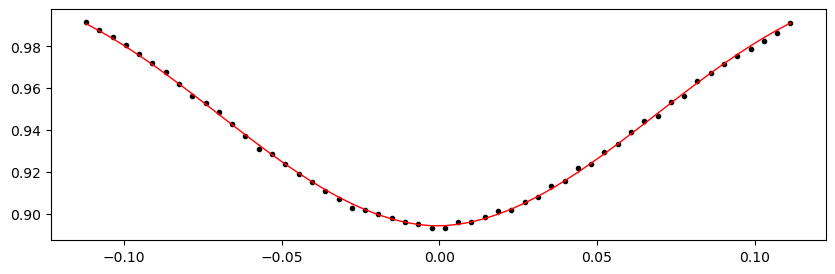

2872.2688872999997 1.013081338351713 -0.11868709084275225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 384.85it/s]


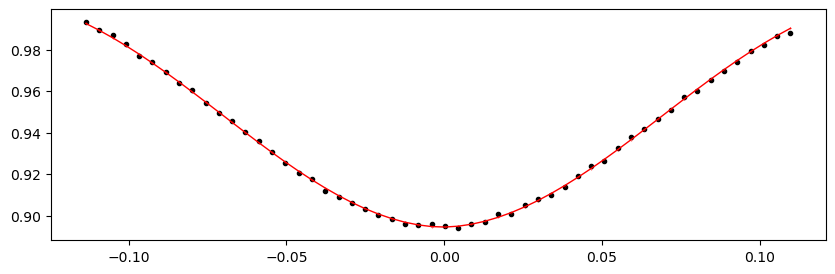

2872.5985607000002 1.013081338351713 -0.11868709084275225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 388.65it/s]


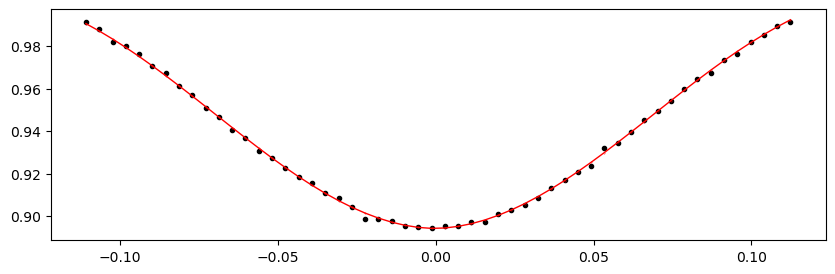

2872.9282341 1.013081338351713 -0.11868709084275225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 389.42it/s]


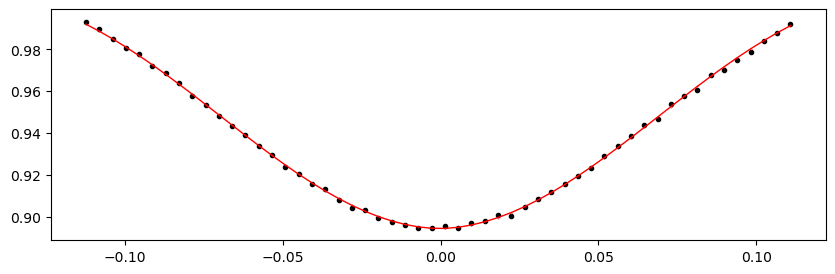

2873.2579075000003 1.013081338351713 -0.11868709084275225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 386.89it/s]


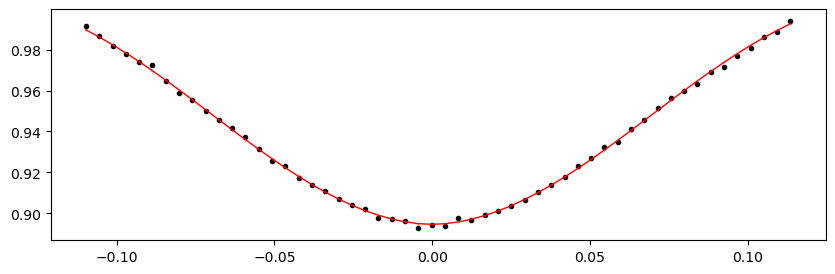

2873.5875809 1.013081338351713 -0.11868709084275225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 368.59it/s]


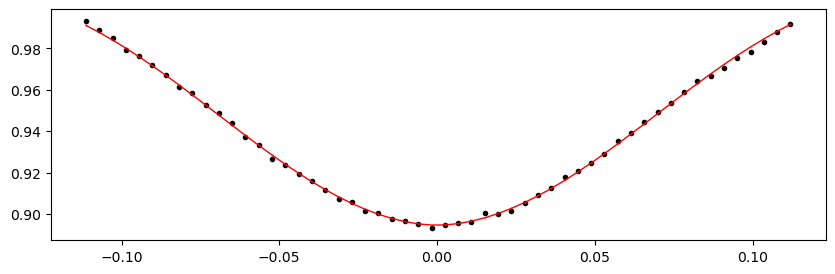

2873.9172543 1.013081338351713 -0.11868709084275225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 391.13it/s]


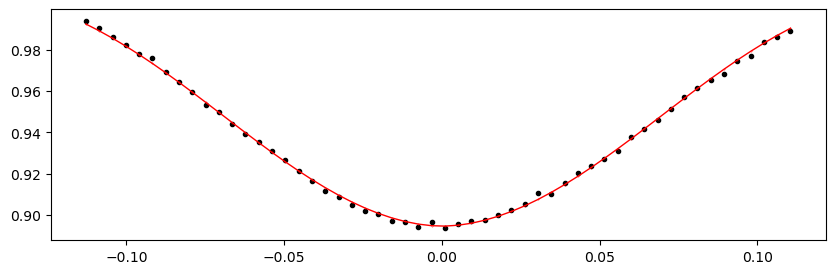

2874.2469277 1.013081338351713 -0.11868709084275225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 379.06it/s]


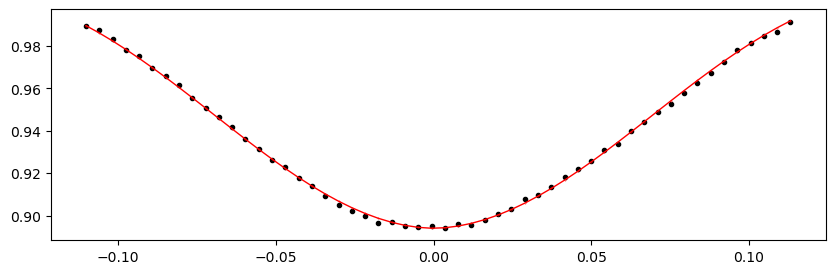

2874.5766011 1.013081338351713 -0.11868709084275225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 383.05it/s]


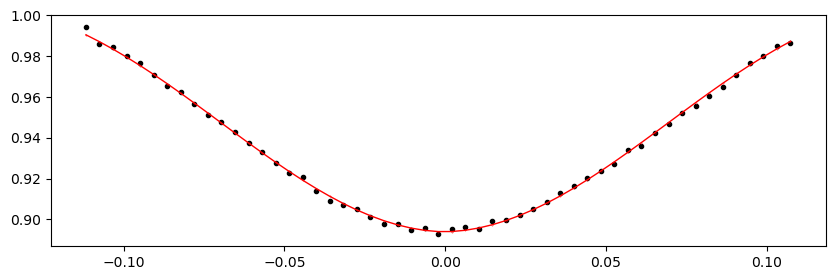

2874.9062745 1.013081338351713 -0.11868709084275225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 379.36it/s]


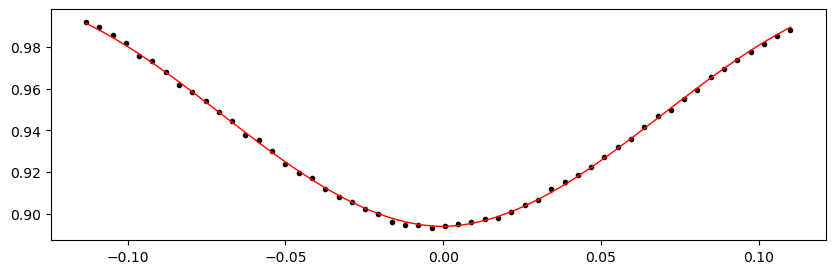

2875.2359478999997 1.013081338351713 -0.11868709084275225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 377.05it/s]


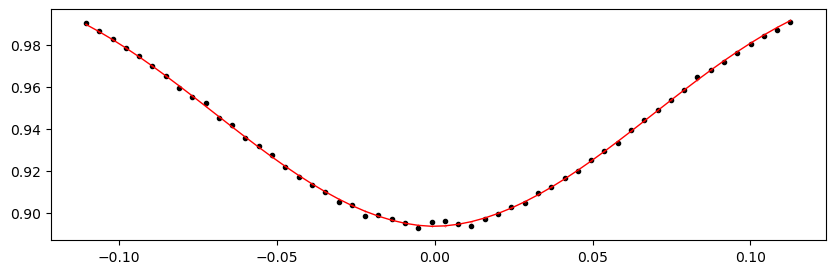

2875.5656213 1.013081338351713 -0.11868709084275225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 391.85it/s]


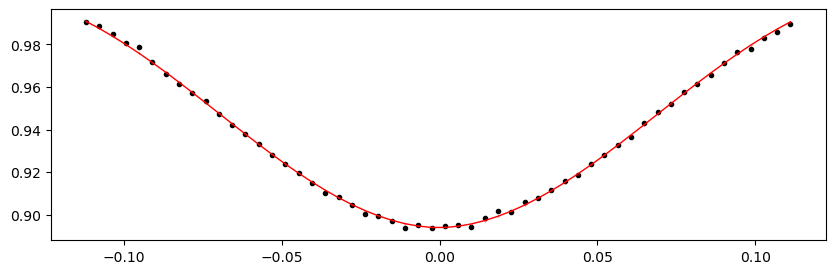

2875.8952947 1.013081338351713 -0.11868709084275225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 380.94it/s]


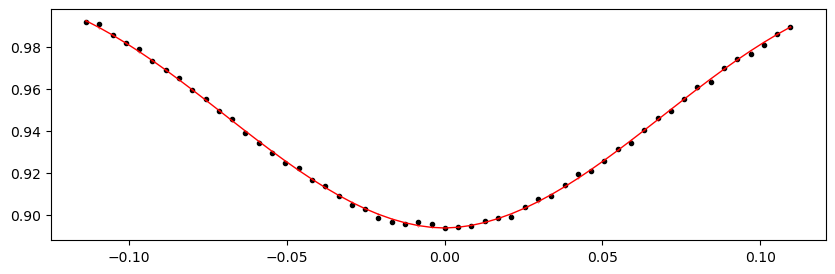

2876.2249681000003 1.013081338351713 -0.11868709084275225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 376.99it/s]


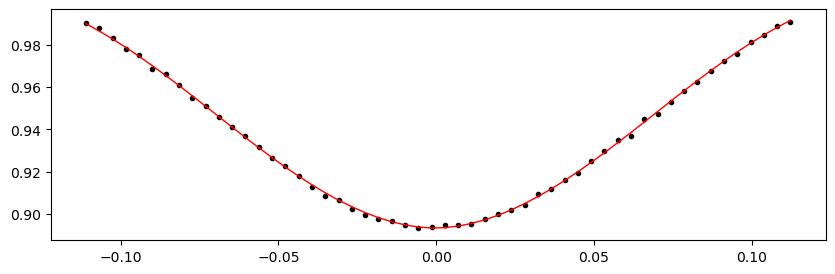

2876.5546415 1.013081338351713 -0.11868709084275225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 384.54it/s]


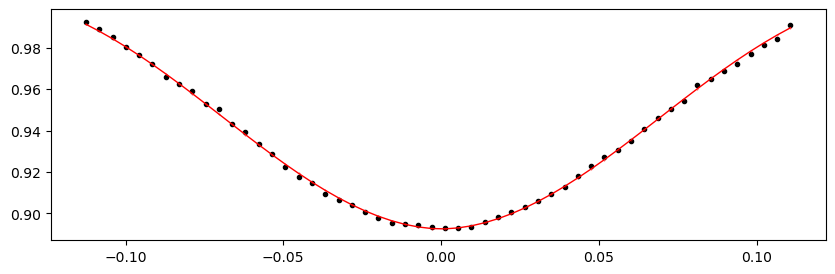

2876.8843149 1.013081338351713 -0.11868709084275225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 385.88it/s]


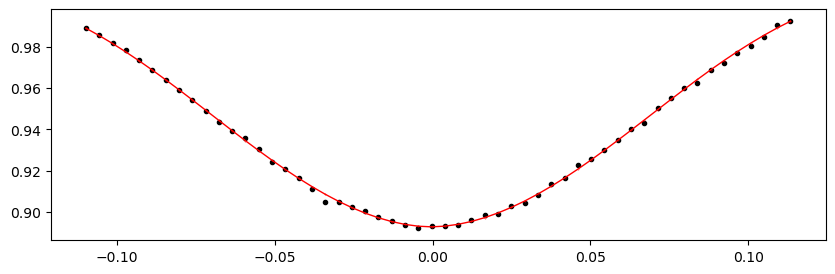

2877.2139883 1.013081338351713 -0.11868709084275225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 386.66it/s]


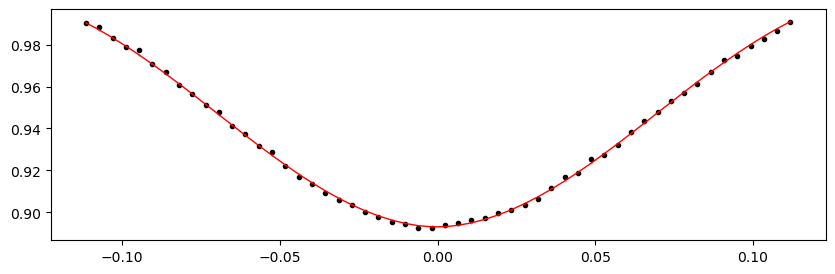

2877.5436617 1.013081338351713 -0.11868709084275225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 393.12it/s]


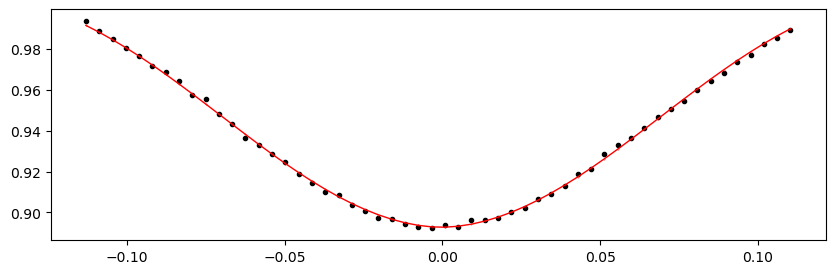

2877.8733351 1.013081338351713 -0.11868709084275225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 406.66it/s]


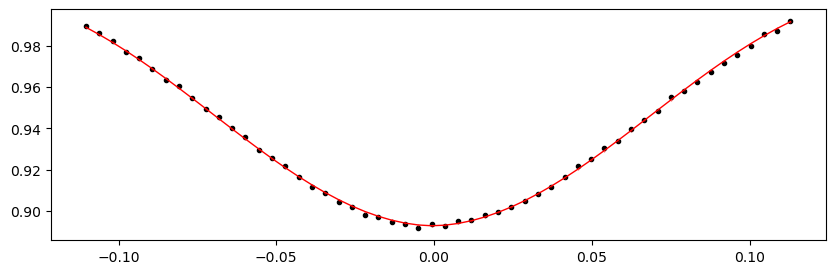

2878.2030085 1.013081338351713 -0.11868709084275225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 401.28it/s]


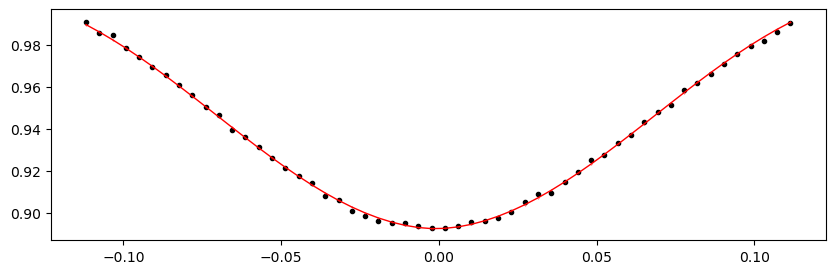

2878.5326819 1.013081338351713 -0.11868709084275225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 403.56it/s]


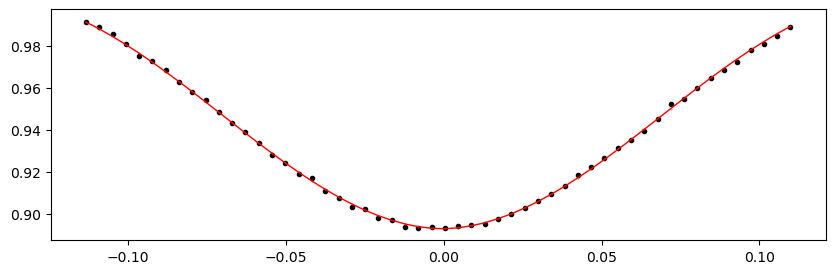

2878.8623552999998 1.013081338351713 -0.11868709084275225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 405.56it/s]


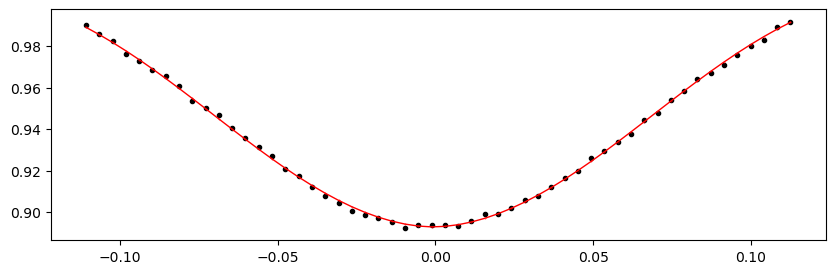

2879.1920287000003 1.013081338351713 -0.11868709084275225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 406.94it/s]


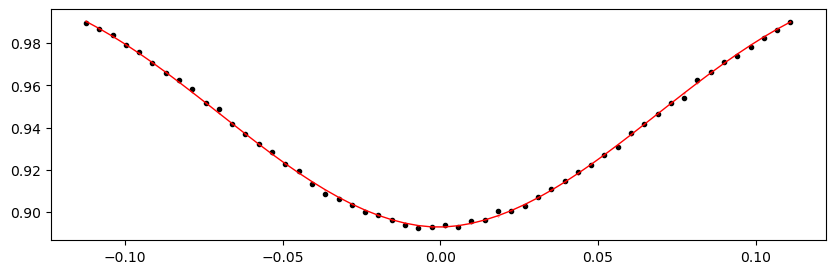

2879.5217021 1.013081338351713 -0.11868709084275225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 406.64it/s]


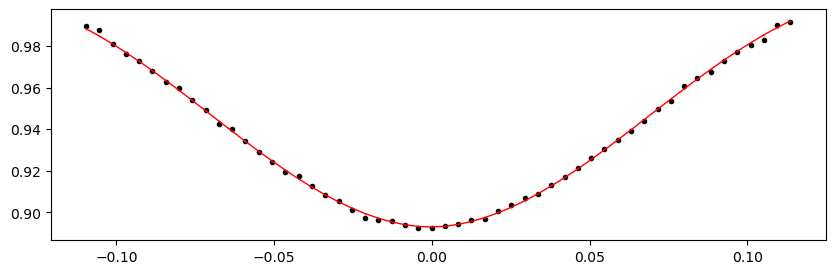

2879.8513755 1.013081338351713 -0.11868709084275225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 405.59it/s]


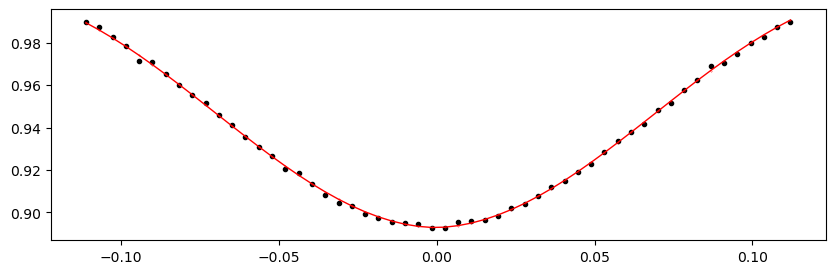

2880.1810489 1.013081338351713 -0.11868709084275225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 404.91it/s]


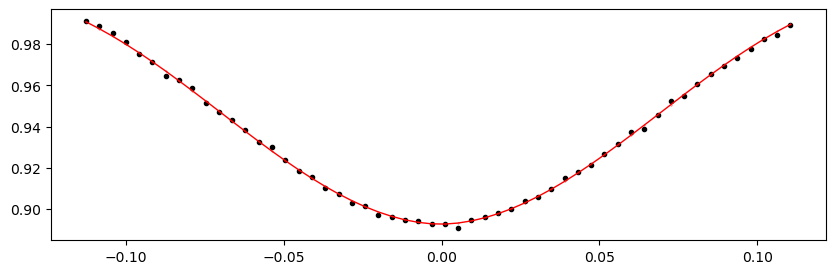

2880.5107223 1.013081338351713 -0.11868709084275225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 399.07it/s]


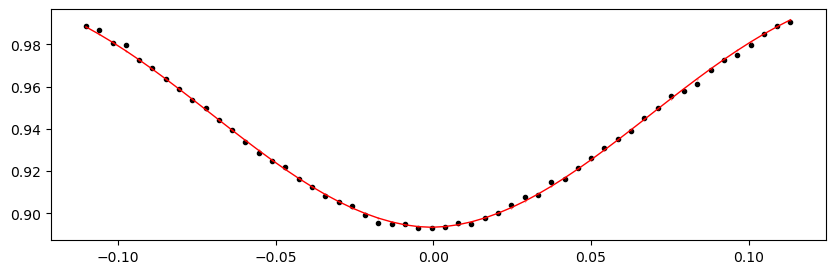

2880.8403957 1.013081338351713 -0.11868709084275225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 403.01it/s]


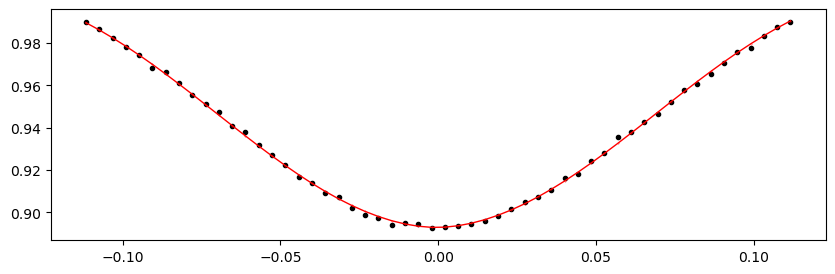

2881.1700691 1.013081338351713 -0.11868709084275225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 402.96it/s]


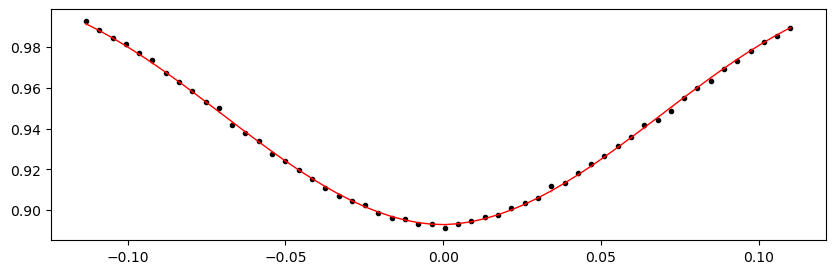

2881.4997425 1.013081338351713 -0.11868709084275225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 398.59it/s]


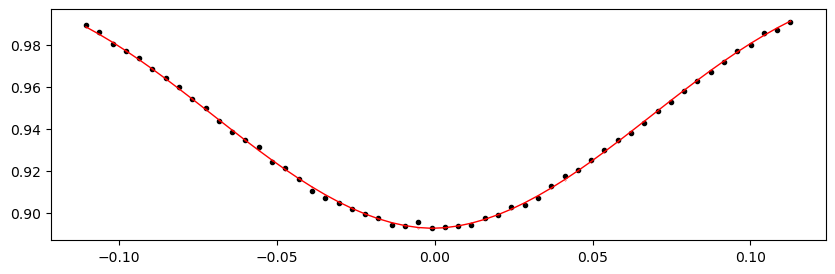

2881.8294158999997 1.013081338351713 -0.11868709084275225 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 414.35it/s]


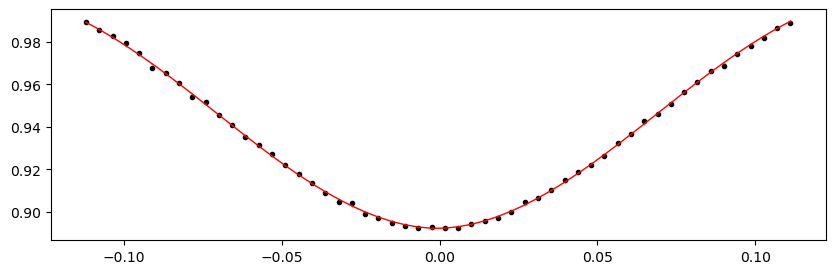

In [59]:
%matplotlib inline

if t0_secondary is not None:
    print("Fitting individual secondary eclipses...")
    etv_functions.fit_each_eclipse(data_secondary, n_transits, t0_secondary, period, mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s, outfile_path_s,
                                   min_number_data=20, 
                                  )
    !$NOTIFY_CMD "Individual secondary eclipses fit done"
else:
    print("No secondary eclipses defined. No-Op.")

## ETV O-C plot

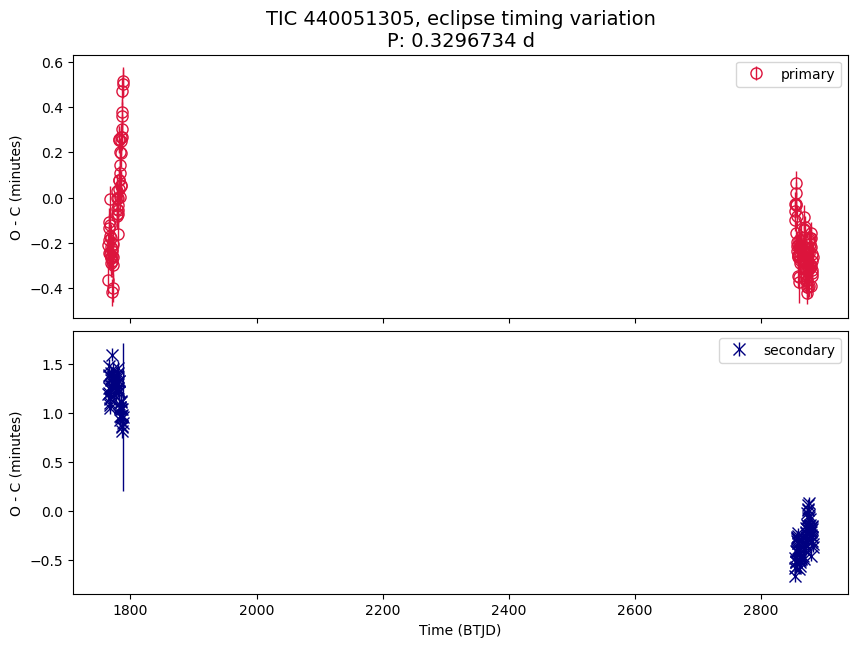

In [60]:
%matplotlib inline
# %matplotlib widget


title_suffix = "eclipse timing variation"

#plot the extracted transit times to check for ETVs

num_rows = 2 if t0_secondary is not None else 1
figsize_y = 3.3 if num_rows == 1 else num_rows * 3.5
# num_rows = 1  # force to plot primary only
# figsize_y = 3.3

fig, axs = plt.subplots(num_rows, 1, figsize=(10, figsize_y), sharex=True)
if isinstance(axs, plt.Axes):  # handle edge case that num_rows == 1, returned axs is not a list
    axs = [axs]

in_df_primary = pd.read_csv(outfile_path)
in_df_primary['midpoint'] = in_df_primary['epoch'] + (in_df_primary['t0']*period)
in_df_primary['shift_mins'] = in_df_primary['t0']*period*24*60
in_df_primary['std_mins'] = in_df_primary['stdv_t0']*period*24*60
in_df_primary_all = in_df_primary  # in case filtering is helpful

# in_df_primary = in_df_primary[in_df_primary.std_mins < 10]  # filter out outliers in error
# print(f"Note: {len(in_df_primary_all) - len(in_df_primary)} data points in df_primary filtered out due to huge O-C error.")

# axs[0].plot(in_df_primary['epoch'], in_df_primary['shift_mins'],
#              lw = 1, color = 'crimson', )
# axs[0].scatter(in_df_primary['epoch'], in_df_primary['shift_mins'],
#              marker = 'o', s=8**2, color = 'None', edgecolor = 'crimson', label="primary")
axs[0].errorbar(in_df_primary['epoch'], in_df_primary['shift_mins'], yerr = in_df_primary['std_mins'],
             lw = 0, marker = 'o', elinewidth = 1, markersize = 8, color = 'None', ecolor='crimson', markeredgecolor = 'crimson', label="primary")

# if False:
if t0_secondary is not None:
    in_df_secondary = pd.read_csv(outfile_path_s)
    in_df_secondary['midpoint'] = in_df_secondary['epoch'] + (in_df_secondary['t0']*period)
    in_df_secondary['shift_mins'] = in_df_secondary['t0']*period*24*60
    in_df_secondary['std_mins'] = in_df_secondary['stdv_t0']*period*24*60
    in_df_secondary_all = in_df_secondary  # in case filtering is helpful

    # in_df_secondary = in_df_secondary[in_df_secondary.std_mins < 10]  # filter out outliers in error
    # print(f"Note: {len(in_df_secondary_all) - len(in_df_secondary)} data points in in_df_secondary filtered out due to huge O-C error.")

    # axs[1].plot(in_df_secondary['epoch'], in_df_secondary['shift_mins'],
    #              lw = 1, color = 'navy', )
    # axs[1].scatter(in_df_secondary['epoch'], in_df_secondary['shift_mins'],
    #              marker = 'x',  s=9**2, color = 'navy', zorder = -2, label="secondary" );
    axs[1].errorbar(in_df_secondary['epoch'], in_df_secondary['shift_mins'], yerr = in_df_secondary['std_mins'],
                 lw = 0, marker = 'x', elinewidth = 1, markersize = 9, color = 'navy', zorder = -2, label="secondary" );
else:
    in_df_secondary = None

for ax in axs:
    ax.set_ylabel("O - C (minutes)")
    ax.legend();

axs[-1].set_xlabel(f"Time ({search_result.time.format.upper()})")
axs[0].set_title(f"TIC {ticid}, {title_suffix}\nP: {period} d", fontsize=14)

plt.subplots_adjust(hspace=0.05)
# plt.ylim(-3, 8)
plt.show()

### O-C Plot, Zoom In

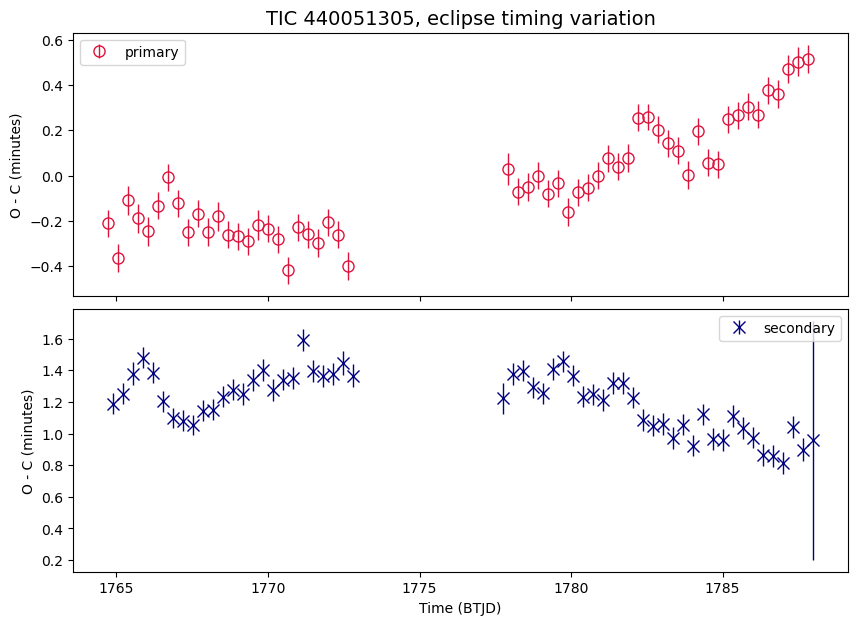

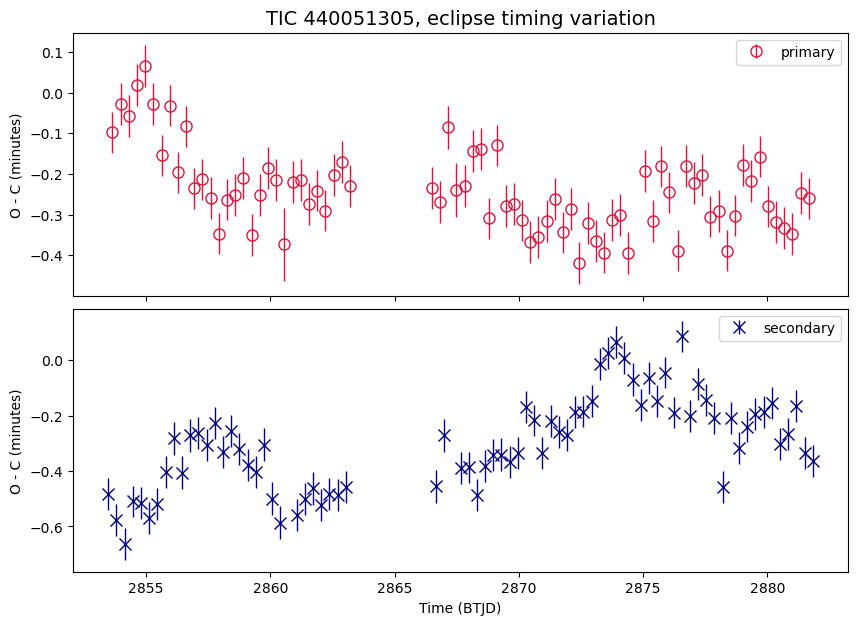

In [61]:
%matplotlib inline
# %matplotlib widget

zoom_ranges = [
    (1700, 1900),
    (2800, 3000),
]

def tweak_axs_list(axs_list):
    # axs_list[0][1].set_ylim(-20, 30);
    # axs_list[1][0].set_ylim(None, 0.5);
    # axs_list[1][1].set_ylim(-5.5, 2);

    # ax = axs_list[0][0]
    # ax.set_title(f"{ax.get_title()} (2min cadence)")
    # ax = axs_list[1][0]
    # ax.set_title(f"{ax.get_title()} (2min cadence)")
    
    pass


def plot_oc_in_zoom_ranges(in_df_primary, in_df_secondary, zoom_ranges):
    axs_list = []
    for zoom_start, zoom_end in zoom_ranges:
        num_rows = 2 if t0_secondary is not None else 1
        figsize_y = 3.3 if num_rows == 1 else num_rows * 3.5

        fig, axs = plt.subplots(num_rows, 1, figsize=(10, figsize_y), sharex=True)
        if isinstance(axs, plt.Axes):  # handle edge case that num_rows == 1, returned axs is not a list
            axs = [axs]

        df_zoom = in_df_primary[(in_df_primary['epoch'] > zoom_start) & (in_df_primary['epoch'] < zoom_end)]

        # axs[0].scatter(df_zoom['epoch'], df_zoom['shift_mins'],
        #                marker = 'o', s=8**2, color = 'None', edgecolor = 'crimson', label="primary")
        axs[0].errorbar(df_zoom['epoch'], df_zoom['shift_mins'], yerr = df_zoom['std_mins'],
                        lw = 0, marker = 'o', elinewidth = 1, markersize = 8, color = 'None', ecolor='crimson', markeredgecolor = 'crimson', label="primary")

        if in_df_secondary is not None:
            df_zoom = in_df_secondary[(in_df_secondary['epoch'] > zoom_start) & (in_df_secondary['epoch'] < zoom_end)]

            # axs[1].scatter(df_zoom['epoch'], df_zoom['shift_mins'],
            #                marker = 'x',  s=9**2, color = 'navy', zorder = -2, label="secondary" );
            axs[1].errorbar(df_zoom['epoch'], df_zoom['shift_mins'], yerr = df_zoom['std_mins'],
                            lw = 0, marker = 'x', elinewidth = 1, markersize = 9, color = 'navy', zorder = -2, label="secondary" );

        for ax in axs:
            ax.set_ylabel("O - C (minutes)")
            ax.legend();

        axs[-1].set_xlabel("Time (BTJD)")
        axs[0].set_title(f"TIC {ticid}, {title_suffix}", fontsize=14)

        plt.subplots_adjust(hspace=0.05)
        axs_list.append(axs)
    return axs_list


axs_list = plot_oc_in_zoom_ranges(in_df_primary, in_df_secondary, zoom_ranges)
tweak_axs_list(axs_list);

## make a periodogram 

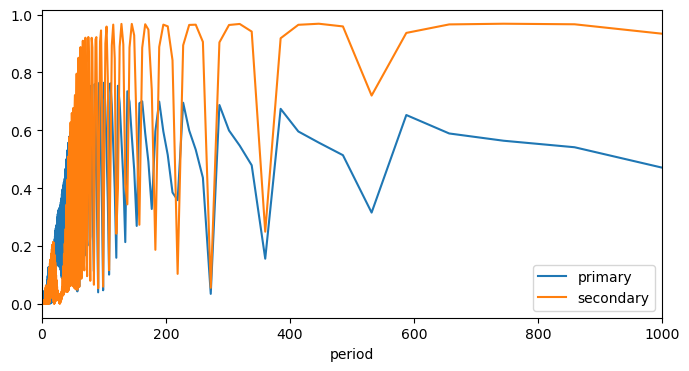

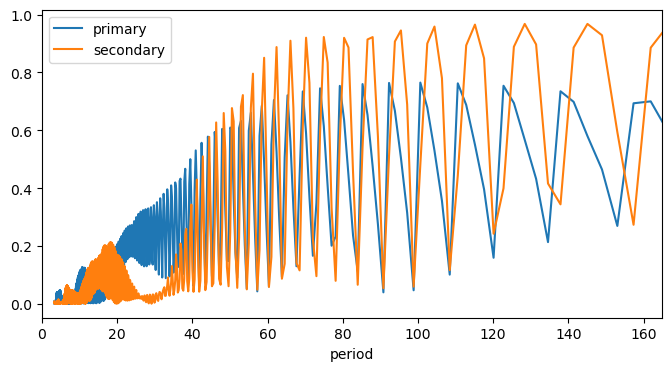

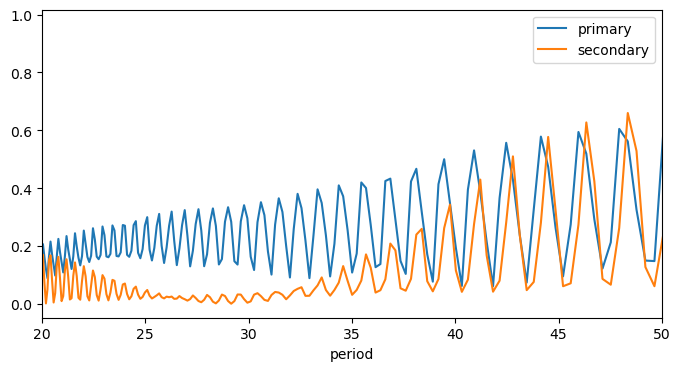

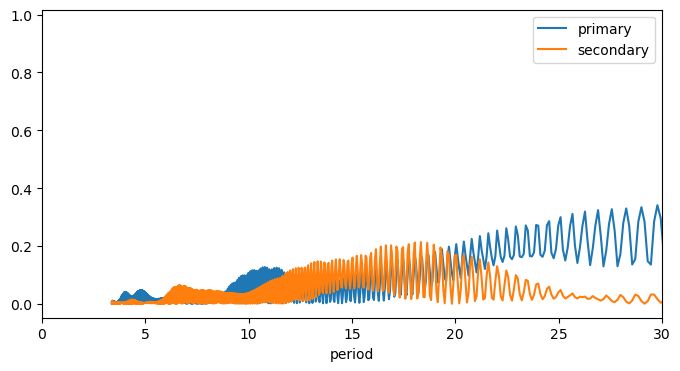

In [63]:
frequency, power = LombScargle(in_df_primary['epoch'], in_df_primary['shift_mins']).autopower()

fig, ax = plt.subplots(figsize=(8, 4))

plt.plot(1/frequency, power, label = 'primary')    

if t0_secondary is not None:
    frequency_s, power_s = LombScargle(in_df_secondary['epoch'], in_df_secondary['shift_mins']).autopower()
    plt.plot(1/frequency_s, power_s, label = 'secondary')    

plt.xlabel("period")

plt.legend()
plt.xlim(0, 1000)
plt.show()


if True:
    fig, ax = plt.subplots(figsize=(8, 4))
    
    plt.plot(1/frequency, power, label = 'primary')    
    
    if t0_secondary is not None:
        frequency_s, power_s = LombScargle(in_df_secondary['epoch'], in_df_secondary['shift_mins']).autopower()
        plt.plot(1/frequency_s, power_s, label = 'secondary')    
    
    plt.xlabel("period")
    
    plt.legend()
    plt.xlim(0, period*500)
    plt.show()


    fig, ax = plt.subplots(figsize=(8, 4))
    
    plt.plot(1/frequency, power, label = 'primary')    
    
    if t0_secondary is not None:
        frequency_s, power_s = LombScargle(in_df_secondary['epoch'], in_df_secondary['shift_mins']).autopower()
        plt.plot(1/frequency_s, power_s, label = 'secondary')    
    
    plt.xlabel("period")
    
    plt.legend()
    plt.xlim(20, 50)
    plt.show()

    
    fig, ax = plt.subplots(figsize=(8, 4))
    
    plt.plot(1/frequency, power, label = 'primary')    
    
    if t0_secondary is not None:
        frequency_s, power_s = LombScargle(in_df_secondary['epoch'], in_df_secondary['shift_mins']).autopower()
        plt.plot(1/frequency_s, power_s, label = 'secondary')    
    
    plt.xlabel("period")
    
    plt.legend()
    plt.xlim(0, 30)
    plt.show()



## O-C plot, folded

- for periodic trend in O-C

In [17]:
def truncate_freq_power_to_period_range(freq, power, period_min, period_max):
    f, p = freq, power
    if period_min is not None:
        f, p = f[f < 1 / period_min], p[f < 1 / period_min]
    if period_max is not None:
        f, p = f[f > 1 / period_max], p[f >  1 / period_max]
    return f, p


def plot_oc_folded(period_min=None, period_max=None, period_min_s=None, period_max_s=None, period=None, period_s=None):

    if period is None:
        _f, _p = truncate_freq_power_to_period_range(frequency, power, period_min, period_max)
        period = 1 / _f[np.argmax(_p)]
    phase_oc = etv_functions.phase_data(in_df_primary.epoch, 0, period)

    fig, axs = plt.subplots(num_rows, 1, figsize=(10, figsize_y * 1.1), sharex=False)
    if isinstance(axs, plt.Axes):  # handle edge case that num_rows == 1, returned axs is not a list
        axs = [axs]
    
    axs[0].scatter(phase_oc, in_df_primary.shift_mins, marker = 'o', s=12**2, c=in_df_primary.epoch);
    axs[0].errorbar(phase_oc, in_df_primary['shift_mins'], yerr = in_df_primary['std_mins'],
                    lw = 0, marker = 'o', elinewidth = 1, markersize = 8, color = 'None', ecolor='crimson', markeredgecolor = 'None', label="primary")
    axs[0].set_title(f"TIC {ticid}, {title_suffix}\nfolded with P={period:.4f} d", fontsize=14)

    if in_df_secondary is not None:
        if period_s is None:
            _f, _p = truncate_freq_power_to_period_range(frequency_s, power_s, period_min_s, period_max_s)
            period_s= 1 / _f[np.argmax(_p)]
        phase_oc_s = etv_functions.phase_data(in_df_secondary.epoch, 0, period_s)
        axs[1].scatter(phase_oc_s, in_df_secondary.shift_mins, marker = 'o',  s=12**2, c=in_df_secondary.epoch);
        axs[1].errorbar(phase_oc_s, in_df_secondary['shift_mins'], yerr = in_df_secondary['std_mins'],
                        lw = 0, marker = 'o', elinewidth = 1, markersize = 8, color='None', ecolor='navy', markeredgecolor = 'None', label="secondary" );
        axs[1].set_title(f"TIC {ticid}, {title_suffix}\nfolded with P={period_s:.4f} d", fontsize=14)

    for ax in axs:
        ax.set_ylabel("O - C (minutes)")
        ax.set_xlabel("Phase (Normalized)")
        ax.legend();
    plt.subplots_adjust(hspace=0.4)
    return axs

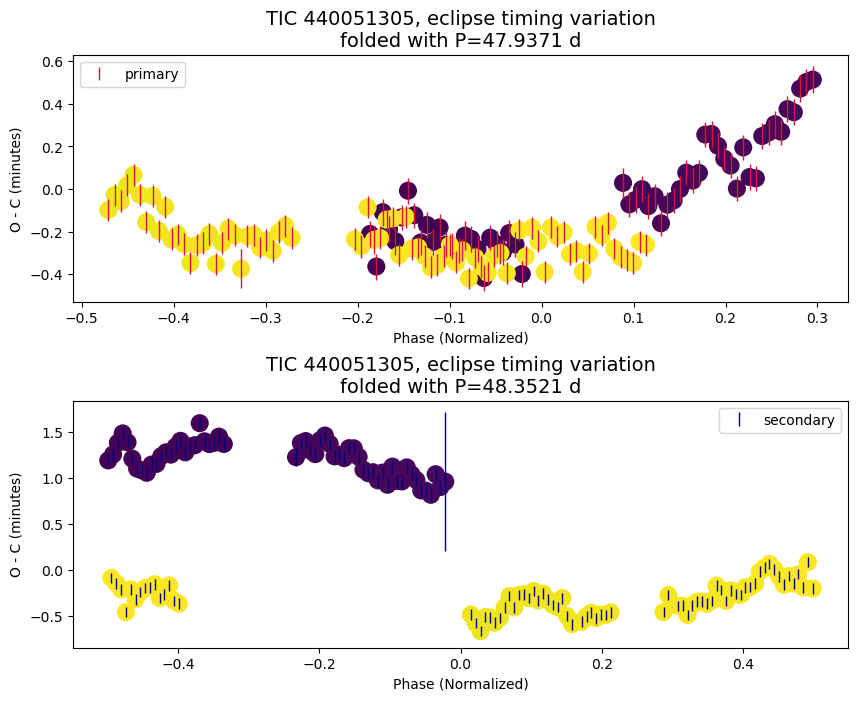

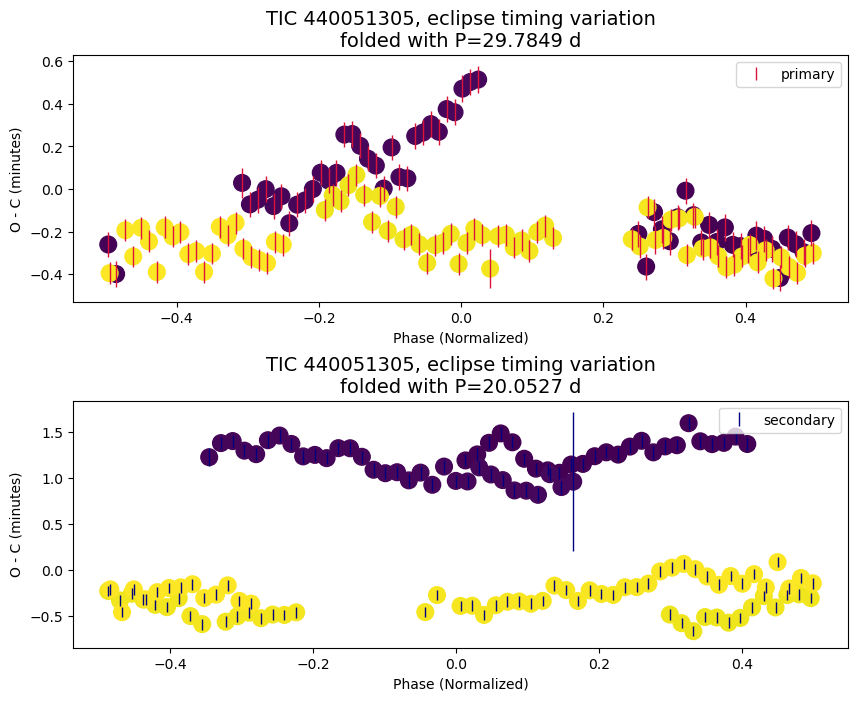

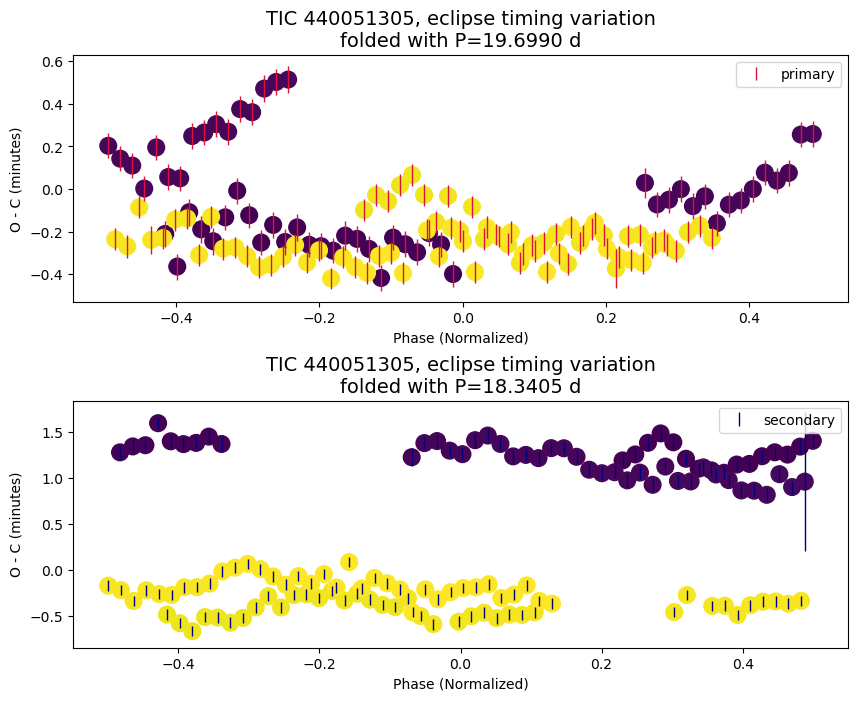

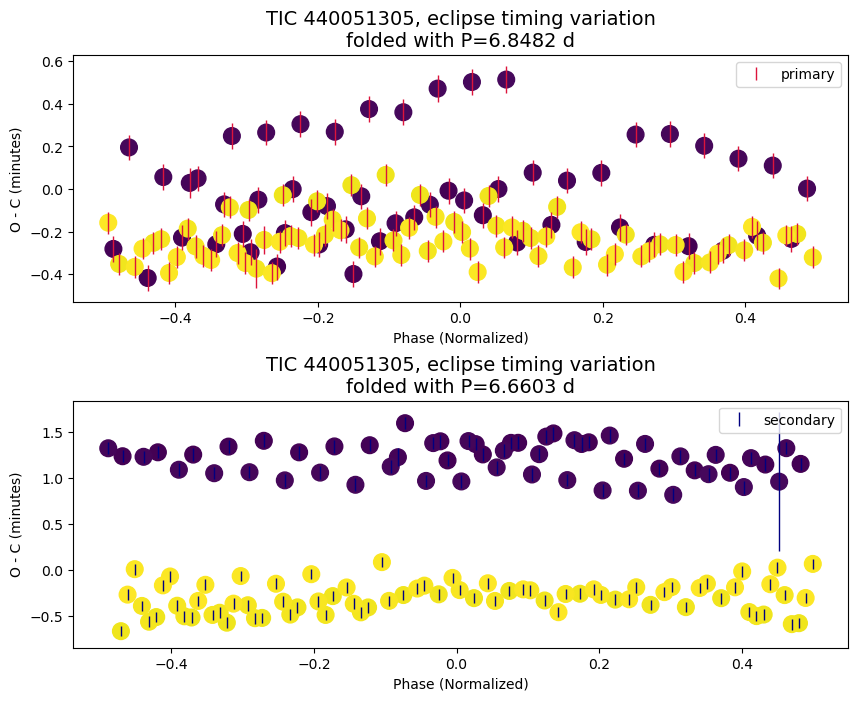

In [67]:
%matplotlib inline
# %matplotlib widget

if True:  # plot O-C periodic trend by folding with a period (from LS Periodogram by default)
    def tweak_axs(axs):
        pass

    axs = plot_oc_folded(
        period_min=30, period_max=50,
        period_min_s=30, period_max_s=50,
    )

    axs = plot_oc_folded(
        period_min=20, period_max=30,
        period_min_s=20, period_max_s=30,
    )

    axs = plot_oc_folded(
        period_min=None, period_max=20,
        period_min_s=None, period_max_s=20,
    )
    
    axs = plot_oc_folded(
        period_min=None, period_max=7,
        period_min_s=None, period_max_s=7,
    )
    # tweak_axs(axs)

## Results Summary

In [68]:
# FILL-IN the ETV results / comments
has_etv = "Y?"
comments = "Mightbe long-term (1000+ d) change with ampltiude < ~2imin for both primary and secondary in 2 sectors. Possibly O-C period of 48 d in primary. The trend of primary is opposite of the one of secondary."

# Eclipse depth from the model
depth_pct_p = round(-mean_alpha1 * 100, 2)
if t0_secondary is not None:
    depth_pct_s = round(-mean_alpha1_s * 100, 2)
else:
    depth_pct_s = None

summary = {
    "tic": ticid,
    "has_etv": has_etv,
    "comments": comments,
    "period": period,  # the period used in ETV analysis
    "depth_pct_p": depth_pct_p,
    "depth_pct_s": depth_pct_s,
    "epoch_p": t0_primary,
    "epoch_s": t0_secondary,
    "num_sectors": len(sr),
    "time_span": round(time[-1] - time[0], 2),
    "time_start": round(time[0], 2),
    "time_end": round(time[-1], 2),
}

summary = pd.DataFrame.from_dict(summary, orient="index")
with pd.option_context('display.max_colwidth', None, 'display.max_rows', 999, 'display.max_columns', 99):
    display(summary);

# Single line to be added to a CSV
print("")
print(summary.transpose().to_csv(
    index=False,
    header=True, 
))

0
tic                                                                                                                                                                                                          440051305
has_etv                                                                                                                                                                                                             Y?
comments     Mightbe long-term (1000+ d) change with ampltiude < ~2imin for both primary and secondary in 2 sectors. Possibly O-C period of 48 d in primary. The trend of primary is opposite of the one of secondary.
period                                                                                                                                                                                                        0.329673
depth_pct_p                                                                                                                                                                                                       13.0
depth_pct_s                                                                                                                                                                                                      11.87
epoch_p                                                                                                                                                                                                      1764.7311
epoch_s                                                                                                                                                                                                    1764.895937
num_sectors                                                                                                                                                                                                          2
time_span                                                                                                                                                                                                      1117.43
time_start                                                                                                                                                                                                     1764.69
time_end                                                                                                                                                                                                       2882.12


tic,has_etv,comments,period,depth_pct_p,depth_pct_s,epoch_p,epoch_s,num_sectors,time_span,time_start,time_end
440051305,Y?,Mightbe long-term (1000+ d) change with ampltiude < ~2imin for both primary and secondary in 2 sectors. Possibly O-C period of 48 d in primary. The trend of primary is opposite of the one of secondary.,0.3296734,13.0,11.87,1764.7311,1764.8959367,2,1117.43,1764.69,2882.12

